## 1 데이터 로드 및 데이터 파악

In [6]:
# 데이터 로드
import os
DATA_ROOT = "/home/jovyan/work/motorcycle/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
print(os.listdir(DATA_ROOT))

# COCO JSON 구조 분석
import json, os, math
from collections import Counter, defaultdict

import numpy as np
import pandas as pd

ann_path = DATA_ROOT + "/COCO_motorcycle (pixel).json"

with open(ann_path, "r") as f:
    coco_data = json.load(f)

print("keys:", coco_data.keys())

['images', 'COCO_motorcycle (pixel).json']
keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [7]:
# ===============================
# COCO Dataset EDA (통합 셀)
# ===============================

import json
import pandas as pd

# ---- COCO JSON 로드 ----
with open(ann_path, "r", encoding="utf-8") as f:
    coco_data = json.load(f)

print("===== COCO STRUCTURE =====")
print("keys:", coco_data.keys())

# ---- 카테고리 매핑 ----
cat_id_to_name = {c["id"]: c["name"] for c in coco_data["categories"]}
cat_name_to_id = {c["name"]: c["id"] for c in coco_data["categories"]}


# ==========================================================
# 1) INFO
# ==========================================================
print("\n===== DATASET INFO =====")

info = coco_data.get("info", {})
display(pd.DataFrame([info]))


# ==========================================================
# 2) LICENSES
# ==========================================================
print("\n===== LICENSES =====")

licenses = coco_data.get("licenses", [])
print("num_licenses:", len(licenses))
display(pd.DataFrame(licenses))


# ==========================================================
# 3) IMAGES 분석
# ==========================================================
print("\n===== IMAGES ANALYSIS =====")

images = coco_data["images"]
print("num_images:", len(images))

img_df = pd.DataFrame(images)

print("image columns:", img_df.columns.tolist())
display(img_df.head(3))

# ---- 해상도 통계 ----
if "width" in img_df.columns and "height" in img_df.columns:
    
    print("\n[Resolution stats]")
    print("width  min/mean/median/max:",
          int(img_df["width"].min()),
          round(img_df["width"].mean(), 2),
          img_df["width"].median(),
          int(img_df["width"].max()))

    print("height min/mean/median/max:",
          int(img_df["height"].min()),
          round(img_df["height"].mean(), 2),
          img_df["height"].median(),
          int(img_df["height"].max()))

    res_counts = (
        img_df.groupby(["width", "height"])
        .size()
        .sort_values(ascending=False)
        .head(5)
    )

    print("\nTop resolutions:")
    display(res_counts)


# ---- 파일명 패턴 ----
if "file_name" in img_df.columns:

    print("\n[file_name examples]")
    display(img_df["file_name"].head(10))

    has_subdir = img_df["file_name"].str.contains("/").mean()
    print(f"file_name에 하위 폴더 포함 비율: {has_subdir*100:.1f}%")


# ==========================================================
# 4) CATEGORIES 분석
# ==========================================================
print("\n===== CATEGORY ANALYSIS =====")

cat_df = pd.DataFrame(coco_data["categories"]).sort_values("id")
display(cat_df)

print("\n[Category list]")
for c in coco_data["categories"]:
    print(f"{c['id']} : {c['name']}")

===== COCO STRUCTURE =====
keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

===== DATASET INFO =====


,description,url,version,year,contributor,date_created
0,This is dataset.,https://superannotate.ai,1.0,2022,Superannotate AI,15/09/2022



===== LICENSES =====
num_licenses: 1


,url,id,name
0,https://superannotate.ai,1,Superannotate AI



===== IMAGES ANALYSIS =====
num_images: 200
image columns: ['id', 'file_name', 'height', 'width', 'license']


,id,file_name,height,width,license
0,1,night ride (8).png,1080,1920,1
1,2,night ride (14).png,1080,1920,1
2,3,night ride (11).png,1080,1920,1



[Resolution stats]
width  min/mean/median/max: 1920 1920.0 1920.0 1920
height min/mean/median/max: 1080 1080.0 1080.0 1080

Top resolutions:


width  height
1920   1080      200
dtype: int64


[file_name examples]


0     night ride (8).png
1    night ride (14).png
2    night ride (11).png
3    night ride (24).png
4    night ride (23).png
5    night ride (10).png
6     night ride (9).png
7    night ride (20).png
8    night ride (12).png
9    night ride (17).png
Name: file_name, dtype: object

file_name에 하위 폴더 포함 비율: 0.0%

===== CATEGORY ANALYSIS =====


,id,name,supercategory,isthing,color
5,1323880,Undrivable,Undrivable,1,"[104, 51, 20]"
4,1323881,Road,Road,1,"[105, 51, 20]"
3,1323882,Lane Mark,Lane Mark,1,"[106, 51, 20]"
2,1323884,Moveable,Moveable,1,"[108, 51, 20]"
1,1323885,My bike,My bike,1,"[109, 51, 20]"
0,1329681,Rider,Rider,1,"[17, 74, 20]"



[Category list]
1329681 : Rider
1323885 : My bike
1323884 : Moveable
1323882 : Lane Mark
1323881 : Road
1323880 : Undrivable


In [8]:
# ===============================
# 5) ANNOTATIONS EDA 
# ===============================

import numpy as np
import pandas as pd

annotations = coco_data["annotations"]
print("\n===== ANNOTATIONS ANALYSIS =====")
print("num_annotations:", len(annotations))

ann_df = pd.DataFrame(annotations)
print("annotation columns:", ann_df.columns.tolist())
display(ann_df.head(3))


# ==========================================================
# 5-2) 클래스별 annotation 개수 (category_id 기준)
# ==========================================================
print("\n===== PER-CLASS ANNOTATION COUNT =====")

cat_counts = ann_df["category_id"].value_counts()

summary_df = pd.DataFrame({
    "category_id": cat_counts.index.astype(int),
    "category_name": [cat_id_to_name.get(int(cid), "UNKNOWN") for cid in cat_counts.index],
    "ann_count": cat_counts.values.astype(int),
    "ann_ratio(%)": (cat_counts.values / len(ann_df) * 100)
})

display(summary_df)


# ==========================================================
# 5-3) 이미지당 annotation 개수 분포
# ==========================================================
print("\n===== ANNOTATIONS PER IMAGE =====")

ann_per_img = ann_df.groupby("image_id").size()
print("images with annotations:", ann_per_img.shape[0], "/", len(images))
print("anns per image: min/mean/median/max =",
      int(ann_per_img.min()),
      round(float(ann_per_img.mean()), 3),
      float(ann_per_img.median()),
      int(ann_per_img.max()))

display(ann_per_img.describe())


# ==========================================================
# 5-4) area / bbox 통계
# ==========================================================
print("\n===== AREA / BBOX STATS =====")

# ---- area ----
if "area" in ann_df.columns:
    print("\n[Area stats]")
    print("area min/mean/median/max =",
          float(ann_df["area"].min()),
          round(float(ann_df["area"].mean()), 3),
          float(ann_df["area"].median()),
          float(ann_df["area"].max()))

    area_by_cat = (
        ann_df.groupby("category_id")["area"]
        .agg(["count","mean","median","min","max"])
        .reset_index()
    )
    area_by_cat["category_name"] = area_by_cat["category_id"].map(cat_id_to_name)
    area_by_cat = area_by_cat.sort_values("mean")

    print("\n[Area stats by category (sorted by mean)]")
    display(area_by_cat)

else:
    print("⚠️ 'area' column not found in annotations.")


# ---- bbox ----
if "bbox" in ann_df.columns:
    # bbox = [x, y, w, h]
    wh = np.array([
        b[2:4] for b in ann_df["bbox"].values
        if isinstance(b, list) and len(b) >= 4
    ])

    if len(wh) > 0:
        w = wh[:, 0]
        h = wh[:, 1]

        print("\n[BBox width/height stats]")
        print("w min/mean/median/max:",
              float(w.min()), round(float(w.mean()), 3), float(np.median(w)), float(w.max()))
        print("h min/mean/median/max:",
              float(h.min()), round(float(h.mean()), 3), float(np.median(h)), float(h.max()))

        bbox_df = pd.DataFrame({
            "w": w,
            "h": h,
            "bbox_area(w*h)": w*h
        })
        display(bbox_df.describe())

    else:
        print("⚠️ bbox는 존재하지만, 파싱 가능한 bbox 리스트가 없습니다.")
else:
    print("⚠️ 'bbox' column not found in annotations.")


===== ANNOTATIONS ANALYSIS =====
num_annotations: 2305
annotation columns: ['id', 'image_id', 'segmentation', 'iscrowd', 'bbox', 'area', 'category_id']


,id,image_id,segmentation,iscrowd,bbox,area,category_id
0,1,1,"[[0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0,...",0,"[0.0, 0.0, 1920.0, 551.0]",586530,1323880
1,2,1,"[[1383, 932, 1382, 933, 1381, 934, 1380, 934, ...",0,"[0.0, 243.0, 1920.0, 837.0]",819509,1323881
2,3,1,"[[884, 524, 883, 525, 882, 525, 881, 525, 880,...",0,"[0.0, 280.0, 1659.0, 277.0]",17414,1323882



===== PER-CLASS ANNOTATION COUNT =====


,category_id,category_name,ann_count,ann_ratio(%)
0,1323884,Moveable,1298,56.312364
1,1323882,Lane Mark,207,8.980477
2,1323881,Road,200,8.676790
3,1323880,Undrivable,200,8.676790
4,1323885,My bike,200,8.676790
5,1329681,Rider,200,8.676790



===== ANNOTATIONS PER IMAGE =====
images with annotations: 200 / 200
anns per image: min/mean/median/max = 5 11.525 11.0 26


count    200.000000
mean      11.525000
std        4.504534
min        5.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       26.000000
dtype: float64


===== AREA / BBOX STATS =====

[Area stats]
area min/mean/median/max = 5.0 179919.144 14907.0 1515454.0

[Area stats by category (sorted by mean)]


,category_id,count,mean,median,min,max,category_name
3,1323884,1298,15041.065485,1692.0,5,424086,Moveable
2,1323882,207,28824.676329,22196.0,103,170137,Lane Mark
5,1329681,200,167151.545000,181064.5,40709,269838,Rider
4,1323885,200,327562.445000,319764.0,108350,711443,My bike
1,1323881,200,562131.875000,593954.0,146843,1035064,Road
0,1323880,200,889272.210000,893769.5,351188,1515454,Undrivable



[BBox width/height stats]
w min/mean/median/max: 1.0 792.071 259.0 1920.0
h min/mean/median/max: 2.0 293.641 162.0 1080.0


,w,h,bbox_area(w*h)
count,2305.000000,2305.000000,2.305000e+03
mean,792.070716,293.640781,4.353286e+05
std,817.403358,286.571006,5.629247e+05
min,1.000000,2.000000,5.000000e+00
25%,47.000000,42.000000,1.960000e+03
50%,259.000000,162.000000,4.006800e+04
75%,1920.000000,533.000000,8.198400e+05
max,1920.000000,1080.000000,2.073600e+06


In [ ]:
!pip install opencv-python
!pip install pycocotools-windows
!pip install segmentation-models-pytorch
!pip install wandb
!pip install tqdm
!pip install pycocotools

===== FILE MATCH CHECK =====
missing files: 0

===== BASIC COUNTS =====
이미지 수: 200
annotation 수: 2305

===== SAMPLE VISUALIZATION =====
loading annotations into memory...
Done (t=2.15s)
creating index...
index created!


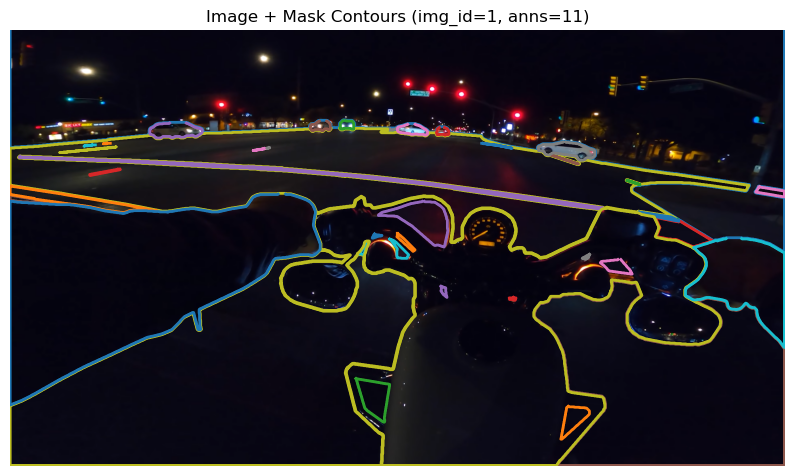

In [10]:
# ===============================
# 6) 파일 매칭 체크 + 샘플 시각화 (통합 셀)
# ===============================

import os, json
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ---- 1) images 폴더와 JSON 매칭 체크 ----
img_dir = os.path.join(DATA_ROOT, "images")

missing = []
for im in images:
    fp = os.path.join(img_dir, im["file_name"])
    if not os.path.exists(fp):
        missing.append(im["file_name"])

print("===== FILE MATCH CHECK =====")
print("missing files:", len(missing))
if len(missing) > 0:
    print("ex) missing sample:", missing[:5])

# ---- 2) 이미지/annotation 수 ----
print("\n===== BASIC COUNTS =====")
print("이미지 수:", len(coco_data["images"]))
print("annotation 수:", len(coco_data["annotations"]))

# ---- 3) 샘플 이미지 + 마스크 윤곽선 시각화 ----
print("\n===== SAMPLE VISUALIZATION =====")

# OpenCV / pycocotools import (없으면 설치 필요)
import cv2
from pycocotools.coco import COCO

coco = COCO(ann_path)

# 첫 샘플 선택
img_id = coco.getImgIds()[0]
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(DATA_ROOT, "images", img_info["file_name"])

# 이미지 읽기
image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"cv2.imread failed: {img_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# annotation 가져오기
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

plt.figure(figsize=(10, 8))
plt.imshow(image)
ax = plt.gca()

# 윤곽선 그리기
for ann in anns:
    mask = coco.annToMask(ann).astype(np.uint8)  # (H,W) 0/1

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        cnt = cnt.squeeze()
        if cnt.ndim == 2 and len(cnt) >= 3:
            ax.plot(cnt[:, 0], cnt[:, 1], linewidth=2)

plt.title(f"Image + Mask Contours (img_id={img_id}, anns={len(anns)})")
plt.axis("off")
plt.show()



===== CLASS DISTRIBUTION (Annotation 기준) =====


,category_id,category_name,annotation_count,ratio(%)
0,1323884,Moveable,1298,56.31
1,1323882,Lane Mark,207,8.98
2,1323881,Road,200,8.68
3,1323880,Undrivable,200,8.68
4,1323885,My bike,200,8.68
5,1329681,Rider,200,8.68


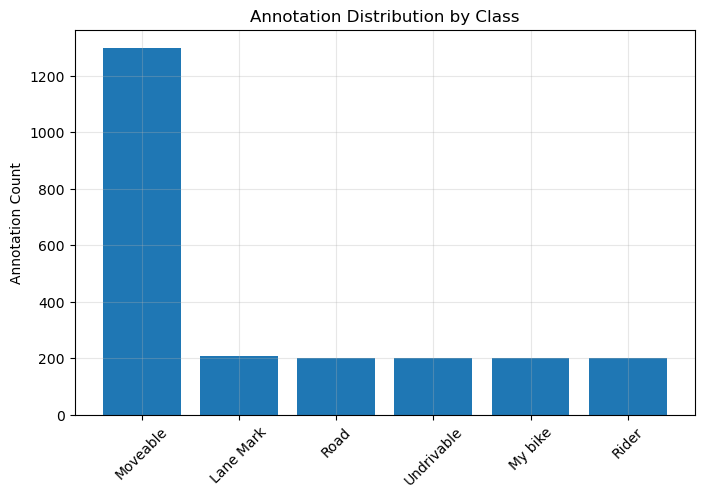

In [11]:
# ===============================
# CLASS DISTRIBUTION + NIGHT BRIGHTNESS ANALYSIS
# ===============================

from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


# ==========================================================
# 1) 클래스 분포 분석 (annotation 기준)
# ==========================================================
print("\n===== CLASS DISTRIBUTION (Annotation 기준) =====")

cls_counter = Counter(ann["category_id"] for ann in coco_data["annotations"])
total = sum(cls_counter.values())

df_cls = (
    pd.DataFrame([
        {
            "category_id": cid,
            "category_name": cat_id_to_name.get(cid, "UNKNOWN"),
            "annotation_count": int(cnt),
            "ratio(%)": round(cnt / total * 100, 2),
        }
        for cid, cnt in cls_counter.items()
    ])
    .sort_values("annotation_count", ascending=False)
    .reset_index(drop=True)
)

display(df_cls)


# ---- 클래스 분포 시각화 ----
plt.figure(figsize=(8,5))
plt.bar(df_cls["category_name"], df_cls["annotation_count"])
plt.title("Annotation Distribution by Class")
plt.ylabel("Annotation Count")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()



===== NIGHT BRIGHTNESS ANALYSIS =====
이미지 수 (Number of Images): 200  (읽기 실패: 0)
평균 픽셀 밝기 (Mean Pixel Intensity): 45.66
중앙값 픽셀 밝기 (Median Pixel Intensity): 33.61
픽셀 밝기 표준편차 (Pixel Intensity Std): 26.01
최소 픽셀 밝기 (Min Pixel Intensity): 10.35
최대 픽셀 밝기 (Max Pixel Intensity): 120.78


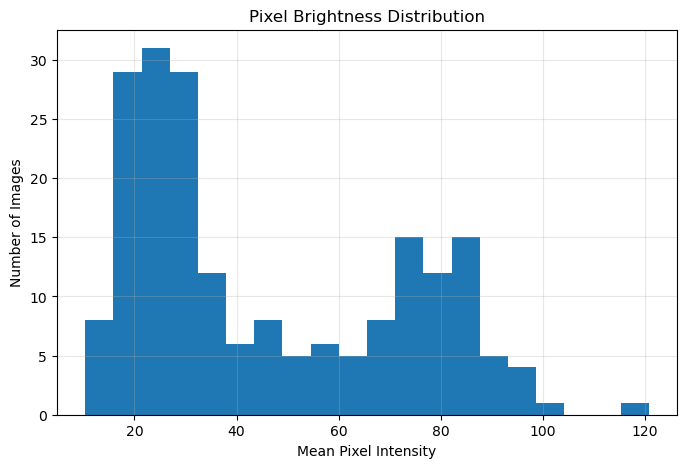

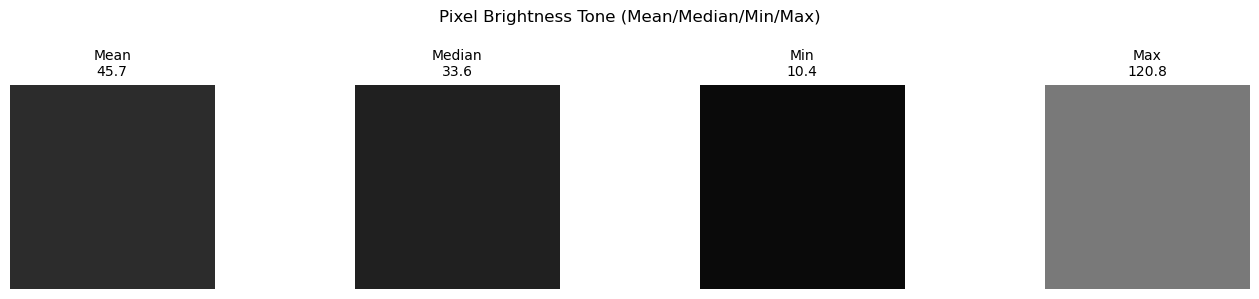

In [12]:

# ----------------------------------------------------------
# 2) 야간 밝기 특성 분석 (Mean Pixel Intensity per Image)
# ----------------------------------------------------------
print("\n===== NIGHT BRIGHTNESS ANALYSIS =====")

brightness = []
bad_files = 0

for img in coco_data["images"]:
    img_path = os.path.join(DATA_ROOT, "images", img["file_name"])
    im = cv2.imread(img_path)
    if im is None:
        bad_files += 1
        continue
    brightness.append(im.mean())

brightness_np = np.array(brightness)

print(f"이미지 수 (Number of Images): {len(brightness_np)}  (읽기 실패: {bad_files})")
print(f"평균 픽셀 밝기 (Mean Pixel Intensity): {brightness_np.mean():.2f}")
print(f"중앙값 픽셀 밝기 (Median Pixel Intensity): {np.median(brightness_np):.2f}")
print(f"픽셀 밝기 표준편차 (Pixel Intensity Std): {brightness_np.std():.2f}")
print(f"최소 픽셀 밝기 (Min Pixel Intensity): {brightness_np.min():.2f}")
print(f"최대 픽셀 밝기 (Max Pixel Intensity): {brightness_np.max():.2f}")

plt.figure(figsize=(8, 5))
plt.hist(brightness_np, bins=20)
plt.title("Pixel Brightness Distribution")
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Number of Images")
plt.grid(alpha=0.3)
plt.show()


# ----------------------------------------------------------
# 3) 밝기 통계(Mean/Median/Min/Max)를 회색 Tone으로 표시
#    (Std는 톤으로 표현해도 직관성이 떨어져서 제외)
# ----------------------------------------------------------
values = [
    brightness_np.mean(),
    np.median(brightness_np),
    brightness_np.min(),
    brightness_np.max()
]
labels = ["Mean", "Median", "Min", "Max"]

plt.figure(figsize=(14, 3))  # 톤 이미지를 좀 더 크게
for i, val in enumerate(values):
    gray = float(val) / 255.0  # 0~1 정규화
    ax = plt.subplot(1, len(values), i + 1)
    ax.imshow([[gray]], cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"{labels[i]}\n{val:.1f}", fontsize=10)
    ax.axis("off")

plt.suptitle("Pixel Brightness Tone (Mean/Median/Min/Max)", fontsize=12)
plt.tight_layout()
plt.show()


## 2. Baseline 선택 (DeepLabV3+ vs U-Net)
### 기준: 동일한 backbone(ResNet 50)을 기준으로 성능이 좋은 모델 선택

### 2.1.1. DeepLab V3

In [13]:
import os, random
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset

class COCOSemSeg(Dataset):
    """
    COCO instance/pixel annotations -> semantic mask (H,W) with train ids.
    공정 비교(DeepLabV3+ vs U-Net, backbone=ResNet50)를 위해:
      - 동일한 resize
      - 동일한 normalize(외부 주입 가능)
      - train에만 augmentation
    """
    def __init__(
        self,
        coco,                 # COCO object
        img_dir: str,
        img_ids,
        id2train: dict,
        size=(512, 512),
        train=True,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        hflip_p=0.5,
        priority_order=None,   # 예: [Undrivable, Moveable, ...] 처럼 "위험 우선" 덮어쓰기 순서 지정 가능
    ):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.size = size
        self.train = train
        self.hflip_p = hflip_p

        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=list(mean), std=list(std))

        # priority_order가 들어오면 category_id 기준으로 덮어쓰기 우선순위를 정함
        # (기본 None이면 기존처럼 COCO anns 순서대로 덮어쓰기)
        self.priority_order = priority_order
        if self.priority_order is not None:
            # priority_order는 category_id 리스트라고 가정
            self._prio_rank = {cid: i for i, cid in enumerate(self.priority_order)}

    def __len__(self):
        return len(self.img_ids)

    def _build_mask(self, img_id, H, W):
        mask = np.zeros((H, W), dtype=np.uint8)

        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        # (옵션) 위험 우선순위 덮어쓰기: priority_order 앞쪽/뒤쪽 중 무엇이 우선인지 실험 가능
        if self.priority_order is not None:
            # rank가 작은 것부터 먼저 칠하고, rank 큰 것이 마지막에 덮어쓰도록(=우선)
            anns = sorted(
                anns,
                key=lambda a: self._prio_rank.get(a["category_id"], -1)
            )

        for ann in anns:
            cid = ann["category_id"]
            if cid not in self.id2train:
                continue
            m = self.coco.annToMask(ann).astype(bool)
            mask[m] = self.id2train[cid]

        return mask

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]
        fp = os.path.join(self.img_dir, img_info["file_name"])

        img = Image.open(fp).convert("RGB")
        W, H = img.size

        mask = self._build_mask(img_id, H, W)
        mask = Image.fromarray(mask)

        # ---- 공정 비교를 위한 동일 resize ----
        img = TF.resize(img, self.size, interpolation=Image.BILINEAR)
        mask = TF.resize(mask, self.size, interpolation=Image.NEAREST)

        # ---- train에만 augmentation ----
        if self.train and random.random() < self.hflip_p:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        img = self.normalize(self.to_tensor(img))
        mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

In [14]:
# ======================
# COCO 이미지 ID 무작위 분할 + SemSeg Dataset/DataLoader
# ======================

import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader

# ======================
# 재현성 설정
# ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

g = torch.Generator()
g.manual_seed(SEED)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ======================
# 이미지 폴더 경로
# ======================
IMG_DIR = os.path.join(DATA_ROOT, "images")

# ======================
# category_id → 학습용 class index 매핑 (background=0, classes=1..K)
# ======================
categories = sorted(coco.loadCats(coco.getCatIds()), key=lambda x: x["id"])
id2train = {cat["id"]: i + 1 for i, cat in enumerate(categories)}
NUM_CLASSES = len(categories) + 1  # background 포함

# (옵션) 학습 class index -> name (IoU 출력용)
train2name = {0: "background"}
for cat in categories:
    train2name[id2train[cat["id"]]] = cat["name"]

# ======================
# 이미지 ID 분할 (중요: rng.shuffle로 재현성 고정)
# ======================
all_img_ids = sorted(coco.getImgIds())
rng = random.Random(SEED)
rng.shuffle(all_img_ids)  # ✅ 전역 random.shuffle 대신 rng.shuffle 사용

n = len(all_img_ids)
n_train = int(n * 0.8)
n_val   = int(n * 0.1)

train_ids = all_img_ids[:n_train]
val_ids   = all_img_ids[n_train:n_train + n_val]
test_ids  = all_img_ids[n_train + n_val:]

# ======================
# Dataset 생성
# ======================
train_ds = COCOSemSeg(coco, IMG_DIR, train_ids, id2train, size=(512, 512), train=True)
val_ds   = COCOSemSeg(coco, IMG_DIR, val_ids,   id2train, size=(512, 512), train=False)

# ======================
# DataLoader 생성
# ======================
NUM_WORKERS = 2

# Windows/Jupyter 안정성: persistent_workers 조건부
persistent_ok = (NUM_WORKERS > 0 and os.name != "nt")

train_loader = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
    worker_init_fn=seed_worker,
    generator=g,
    persistent_workers=persistent_ok
)

val_loader = DataLoader(
    val_ds,
    batch_size=4,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
    worker_init_fn=seed_worker,
    generator=g,
    persistent_workers=persistent_ok
)

print("train/val/test:", len(train_ids), len(val_ids), len(test_ids))
print("NUM_CLASSES:", NUM_CLASSES)
print("classes:", [train2name[i] for i in range(1, NUM_CLASSES)])

train/val/test: 160 20 20
NUM_CLASSES: 7
classes: ['Undrivable', 'Road', 'Lane Mark', 'Moveable', 'My bike', 'Rider']


### DeepLab V3 모델 결정

In [15]:
# =========================================
# 0) train index -> class name (공통)
# =========================================
train2name = {0: "background"}
for cat in categories:
    train_idx = id2train[cat["id"]]
    train2name[train_idx] = cat["name"]


# =========================================
# 1) 공통 유틸: 모델 출력(logits) 통일
#    - torchvision DeepLabV3: dict["out"]
#    - smp(Unet/DeepLabV3Plus): tensor
# =========================================
def _get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out


# =========================================
# 2) 모델 생성 함수 (교체 가능 구조)
#    mode="deeplabv3_torchvision" (현재)
#    mode="unet_smp" / "deeplabv3plus_smp" (나중)
# =========================================
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50

def build_model(mode: str, num_classes: int, device: str,
                encoder_name: str = "resnet50", encoder_weights: str = "imagenet"):
    """
    mode:
      - "deeplabv3_torchvision": (ResNet50 backbone만 현실적으로 사용)
      - "unet_smp": EfficientNet/ResNet 등 encoder 자유
      - "deeplabv3plus_smp": EfficientNet/ResNet 등 encoder 자유

    encoder_name/encoder_weights는 smp 계열에서만 사용됨.
    """
    if mode == "deeplabv3_torchvision":
        # torchvision DeepLabV3: backbone=ResNet50 고정(공식 제공)
        model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
        model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
        return model.to(device)

    elif mode in ["unet_smp", "deeplabv3plus_smp"]:
        import segmentation_models_pytorch as smp

        if mode == "unet_smp":
            model = smp.Unet(
                encoder_name=encoder_name,        # 예: "efficientnet-b0", "resnet50"
                encoder_weights=encoder_weights,  # "imagenet" or None
                in_channels=3,
                classes=num_classes,
                activation=None
            )
        else:
            model = smp.DeepLabV3Plus(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes,
                activation=None
            )
        return model.to(device)

    else:
        raise ValueError(f"Unknown mode: {mode}")


# =========================================
# 3) Optim/Loss 생성 함수 (공통)
#    - 어떤 모델로 바꿔도 동일하게 사용
# =========================================
def build_optim_and_loss(model, lr=3e-4, wd=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    return criterion, optimizer


# =========================================
# 4) 지금은 DeepLabV3(ResNet50)로 시작
# =========================================
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

MODEL_MODE = "deeplabv3_torchvision"  # ✅ 현재 baseline
model = build_model(MODEL_MODE, NUM_CLASSES, device=device)

criterion, optimizer = build_optim_and_loss(model, lr=3e-4, wd=1e-4)

print(f"model ready: {MODEL_MODE}")

device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


model ready: deeplabv3_torchvision


In [16]:
# =========================================
# 0) train index -> class name (공통)
# =========================================
train2name = {0: "background"}
for cat in categories:
    train_idx = id2train[cat["id"]]
    train2name[train_idx] = cat["name"]


# =========================================
# 1) 공통 유틸: 모델 출력(logits) 통일
#    - torchvision DeepLabV3: dict["out"]
#    - smp(Unet/DeepLabV3Plus): tensor
# =========================================
def _get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out


# =========================================
# 2) 모델 생성 함수 (교체 가능 구조)
#    mode="deeplabv3_torchvision" (현재)
#    mode="unet_smp" / "deeplabv3plus_smp" (나중)
# =========================================
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50

def build_model(mode: str, num_classes: int, device: str,
                encoder_name: str = "resnet50", encoder_weights: str = "imagenet"):
    """
    mode:
      - "deeplabv3_torchvision": (ResNet50 backbone만 현실적으로 사용)
      - "unet_smp": EfficientNet/ResNet 등 encoder 자유
      - "deeplabv3plus_smp": EfficientNet/ResNet 등 encoder 자유

    encoder_name/encoder_weights는 smp 계열에서만 사용됨.
    """
    if mode == "deeplabv3_torchvision":
        # torchvision DeepLabV3: backbone=ResNet50 고정(공식 제공)
        model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
        model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
        return model.to(device)

    elif mode in ["unet_smp", "deeplabv3plus_smp"]:
        import segmentation_models_pytorch as smp

        if mode == "unet_smp":
            model = smp.Unet(
                encoder_name=encoder_name,        # 예: "efficientnet-b0", "resnet50"
                encoder_weights=encoder_weights,  # "imagenet" or None
                in_channels=3,
                classes=num_classes,
                activation=None
            )
        else:
            model = smp.DeepLabV3Plus(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes,
                activation=None
            )
        return model.to(device)

    else:
        raise ValueError(f"Unknown mode: {mode}")


# =========================================
# 3) Optim/Loss 생성 함수 (공통)
#    - 어떤 모델로 바꿔도 동일하게 사용
# =========================================
def build_optim_and_loss(model, lr=3e-4, wd=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    return criterion, optimizer


# =========================================
# 4) 지금은 DeepLabV3(ResNet50)로 시작
# =========================================
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

MODEL_MODE = "deeplabv3_torchvision"  # ✅ 현재 baseline
model = build_model(MODEL_MODE, NUM_CLASSES, device=device)

criterion, optimizer = build_optim_and_loss(model, lr=3e-4, wd=1e-4)

print(f"model ready: {MODEL_MODE}")

device: cuda
model ready: deeplabv3_torchvision


In [17]:
import numpy as np
import torch

def _get_logits(model_out):
    """DeepLabV3(torchvision): dict['out'], U-Net(smp): tensor"""
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    """
    pred/target: (N,H,W) on CPU or GPU 상관없음 (여기선 CPU로 누적 추천)
    return: (C,C) confusion matrix (long)
    """
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)

    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]

    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background=True):
    """
    conf: (C,C) long
    return: miou(float), per_class_iou(np.ndarray shape (C,))
    """
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn
    iou = tp / torch.clamp(denom, min=1.0)  # (C,)
    iou = iou.cpu().numpy()

    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou


def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))          # ✅ DeepLab/UNet 공용
        loss = criterion(logits, masks)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def validate(model, loader, criterion, device, num_classes,
             exclude_background=True, ignore_index=None):
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))          # ✅ DeepLab/UNet 공용
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)                # (N,H,W) on GPU
        # confusion 누적은 CPU로 (메모리/속도 안정)
        conf += _confusion_from_pred(pred.detach().cpu(), masks.detach().cpu(),
                                     num_classes=num_classes, ignore_index=ignore_index)

    val_loss = total_loss / len(loader.dataset)
    val_miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)

    # 기존 출력 형식(per_class dict) 유지하고 싶으면
    per_class_mean = {cls: float(per_class_iou[cls]) for cls in range(num_classes)}

    return val_loss, val_miou, per_class_mean

In [18]:
import os
import numpy as np
import torch

# =========================
# CONFIG
# =========================
EPOCHS = 30
PATIENCE = 3
MODEL_NAME = "baseline_deeplabv3_resnet50.pth"
HISTORY_NAME = "history_deeplabv3_resnet50.npz"

best_miou = -1.0
patience_counter = 0

# =========================
# per-class 형태 통일 유틸
# =========================
def to_per_class_list(per_class, num_classes: int):
    out = [np.nan] * num_classes

    if isinstance(per_class, dict):
        for c in range(num_classes):
            if c in per_class:
                v = per_class[c]
                out[c] = float(v) if v is not None and np.isfinite(v) else np.nan
        return out

    if isinstance(per_class, (list, tuple, np.ndarray)):
        L = min(len(per_class), num_classes)
        for c in range(L):
            v = per_class[c]
            out[c] = float(v) if v is not None and np.isfinite(v) else np.nan
        return out

    return out

# =========================
# history 버퍼
# =========================
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "per_class_iou": []
}

# =========================
# TRAIN LOOP
# =========================
for epoch in range(1, EPOCHS + 1):

    # ---- train ----
    tr_loss = train_one_epoch(
        model,
        train_loader,
        criterion,
        optimizer,
        device
    )

    # ---- validate ----
    va_loss, va_miou, per_class = validate(
        model,
        val_loader,
        criterion,
        device,
        NUM_CLASSES,
        exclude_background=True
    )

    per_class_list = to_per_class_list(per_class, NUM_CLASSES)

    # ---- 출력 ----
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | mIoU={va_miou:.4f}")

    for cls in range(1, NUM_CLASSES):
        cls_name = train2name.get(cls, f"class_{cls}")
        iou = per_class_list[cls]
        print(f"  IoU {cls_name:10s}: {'nan' if np.isnan(iou) else f'{iou:.4f}'}")

    # ---- history 저장 ----
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["per_class_iou"].append(
        [float(x) if np.isfinite(x) else np.nan for x in per_class_list]
    )

    # ---- best model + early stopping ----
    if va_miou > best_miou:
        best_miou = va_miou
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_NAME)
        print(f"  ✅ saved: {MODEL_NAME} (best mIoU={best_miou:.4f})")
    else:
        patience_counter += 1
        print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE})")

    if patience_counter >= PATIENCE:
        print(f"\n🛑 Early stopping at epoch {epoch}")
        print(f"Best mIoU: {best_miou:.4f}")
        break

# =========================
# history 저장
# =========================
try:
    np.savez(
        HISTORY_NAME,
        epoch=np.array(history["epoch"], dtype=np.int32),
        train_loss=np.array(history["train_loss"], dtype=np.float32),
        val_loss=np.array(history["val_loss"], dtype=np.float32),
        val_miou=np.array(history["val_miou"], dtype=np.float32),
        per_class_iou=np.array(history["per_class_iou"], dtype=np.float32),
    )
    print(f"\n✅ history saved: {HISTORY_NAME}")
except Exception as e:
    print(f"\n⚠ history save skipped: {e}")

[01/30] train_loss=0.5399 | val_loss=0.4024 | mIoU=0.6468
  IoU Undrivable: 0.8576
  IoU Road      : 0.7415
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.6377
  IoU My bike   : 0.8344
  IoU Rider     : 0.8099
  ✅ saved: baseline_deeplabv3_resnet50.pth (best mIoU=0.6468)
[02/30] train_loss=0.2506 | val_loss=0.2662 | mIoU=0.6884
  IoU Undrivable: 0.9046
  IoU Road      : 0.8058
  IoU Lane Mark : 0.0042
  IoU Moveable  : 0.6645
  IoU My bike   : 0.8982
  IoU Rider     : 0.8529
  ✅ saved: baseline_deeplabv3_resnet50.pth (best mIoU=0.6884)
[03/30] train_loss=0.1906 | val_loss=0.2476 | mIoU=0.7195
  IoU Undrivable: 0.9000
  IoU Road      : 0.8124
  IoU Lane Mark : 0.0929
  IoU Moveable  : 0.7154
  IoU My bike   : 0.9199
  IoU Rider     : 0.8764
  ✅ saved: baseline_deeplabv3_resnet50.pth (best mIoU=0.7195)
[04/30] train_loss=0.1529 | val_loss=0.2319 | mIoU=0.7280
  IoU Undrivable: 0.9029
  IoU Road      : 0.8103
  IoU Lane Mark : 0.1077
  IoU Moveable  : 0.7443
  IoU My bike   : 0.9283
  IoU R

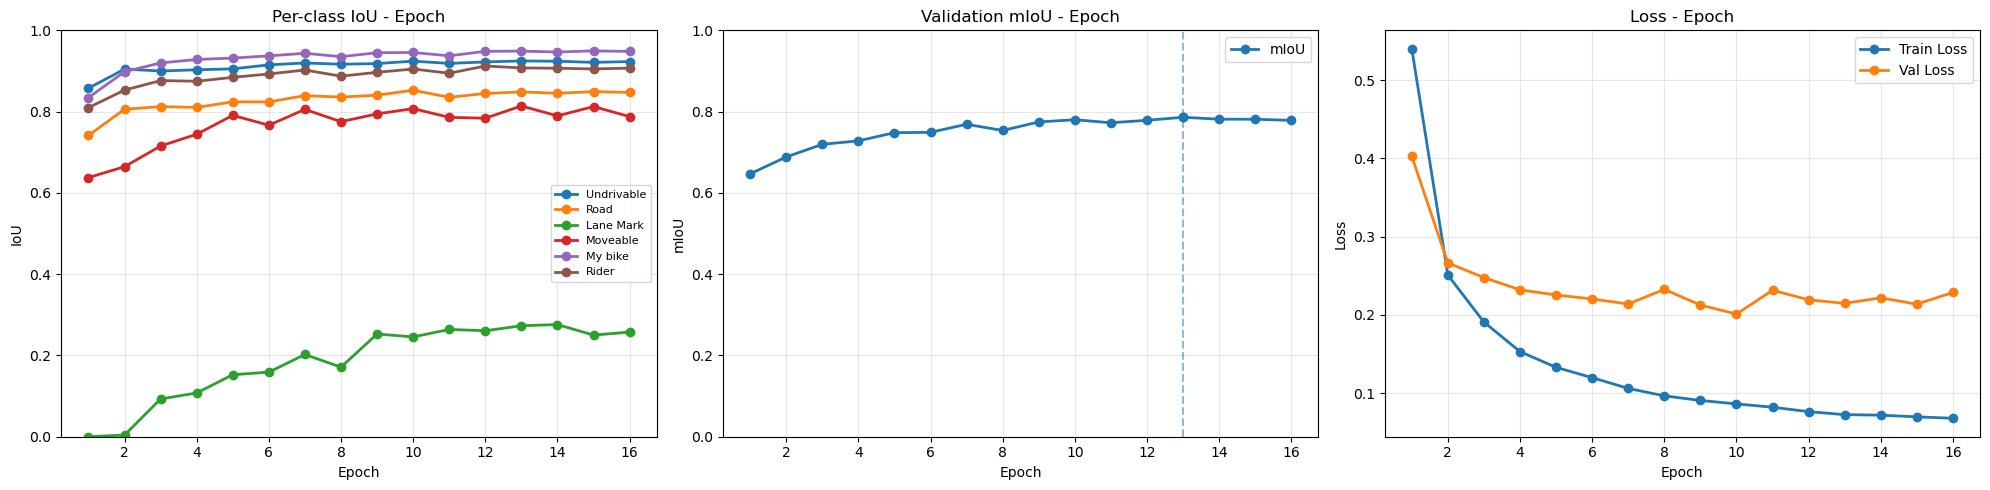

In [19]:
import numpy as np
import matplotlib.pyplot as plt

epochs = history["epoch"]
per_class = np.array(history["per_class_iou"])

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# ======================
# ① Per-class IoU
# ======================
ax = axes[0]

for cls in range(1, NUM_CLASSES):
    name = train2name.get(cls, f"class_{cls}")
    ax.plot(
        epochs,
        per_class[:, cls],
        marker="o",
        linewidth=2,
        label=name
    )

ax.set_title("Per-class IoU - Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("IoU")
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)


# ======================
# ② mIoU
# ======================
ax = axes[1]

ax.plot(
    history["epoch"],
    history["val_miou"],
    marker="o",
    linewidth=2,
    label="mIoU"
)

best_epoch = history["epoch"][np.argmax(history["val_miou"])]
best_miou  = max(history["val_miou"])

ax.axvline(best_epoch, linestyle="--", alpha=0.5)
ax.scatter(best_epoch, best_miou, zorder=5)

ax.set_title("Validation mIoU - Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("mIoU")
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()


# ======================
# ③ Loss 그래프
# ======================
ax = axes[2]

ax.plot(
    history["epoch"],
    history["train_loss"],
    marker="o",
    linewidth=2,
    label="Train Loss"
)

ax.plot(
    history["epoch"],
    history["val_loss"],
    marker="o",
    linewidth=2,
    label="Val Loss"
)

ax.set_title("Loss - Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid(True, alpha=0.3)
ax.legend()


plt.tight_layout()
plt.show()

🔥 Worst sample idxs: [5, 17]
idx=5 | pixel_acc=0.8035


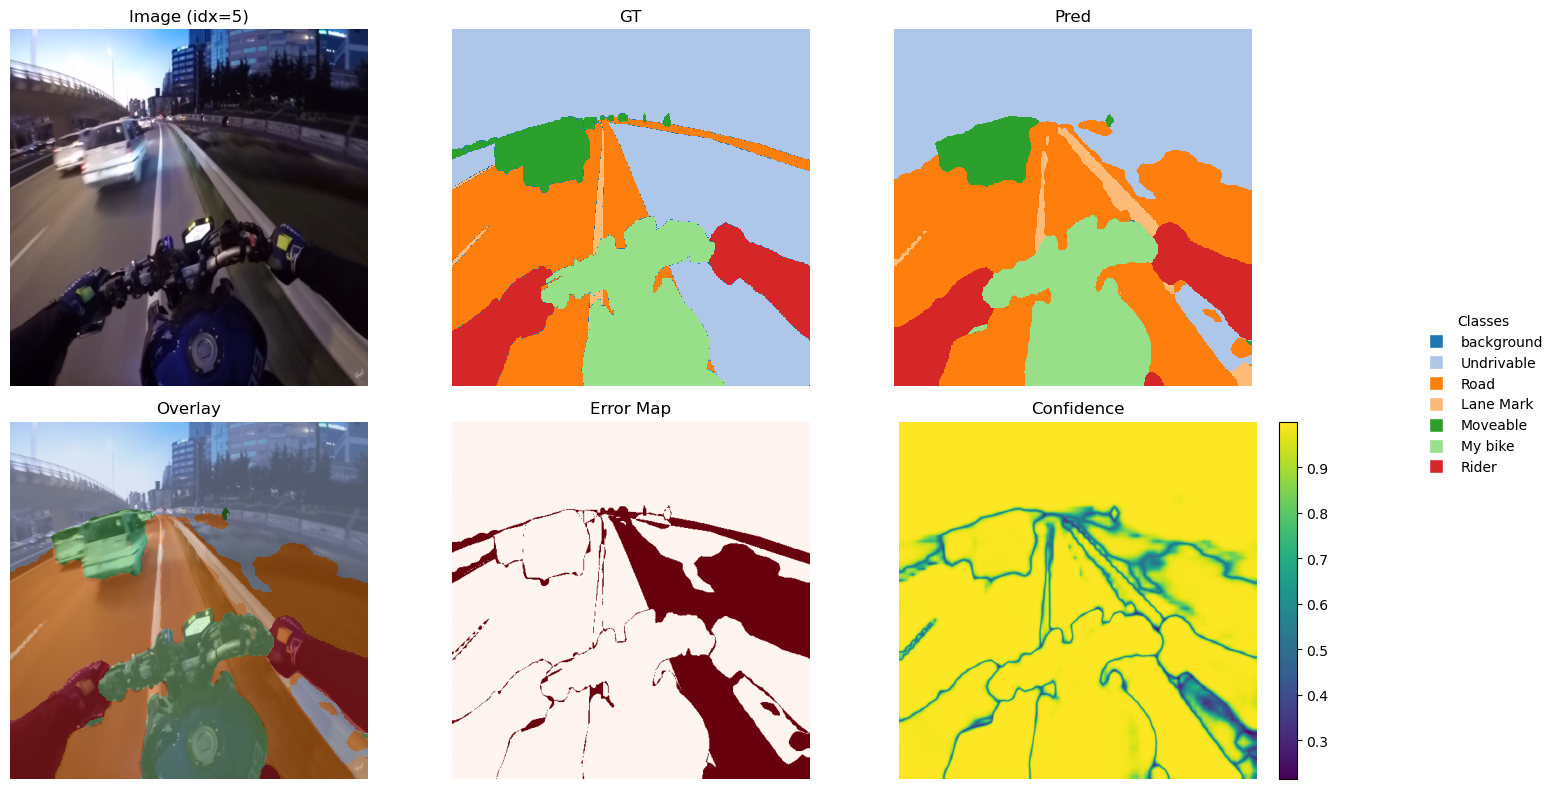

idx=17 | pixel_acc=0.8114


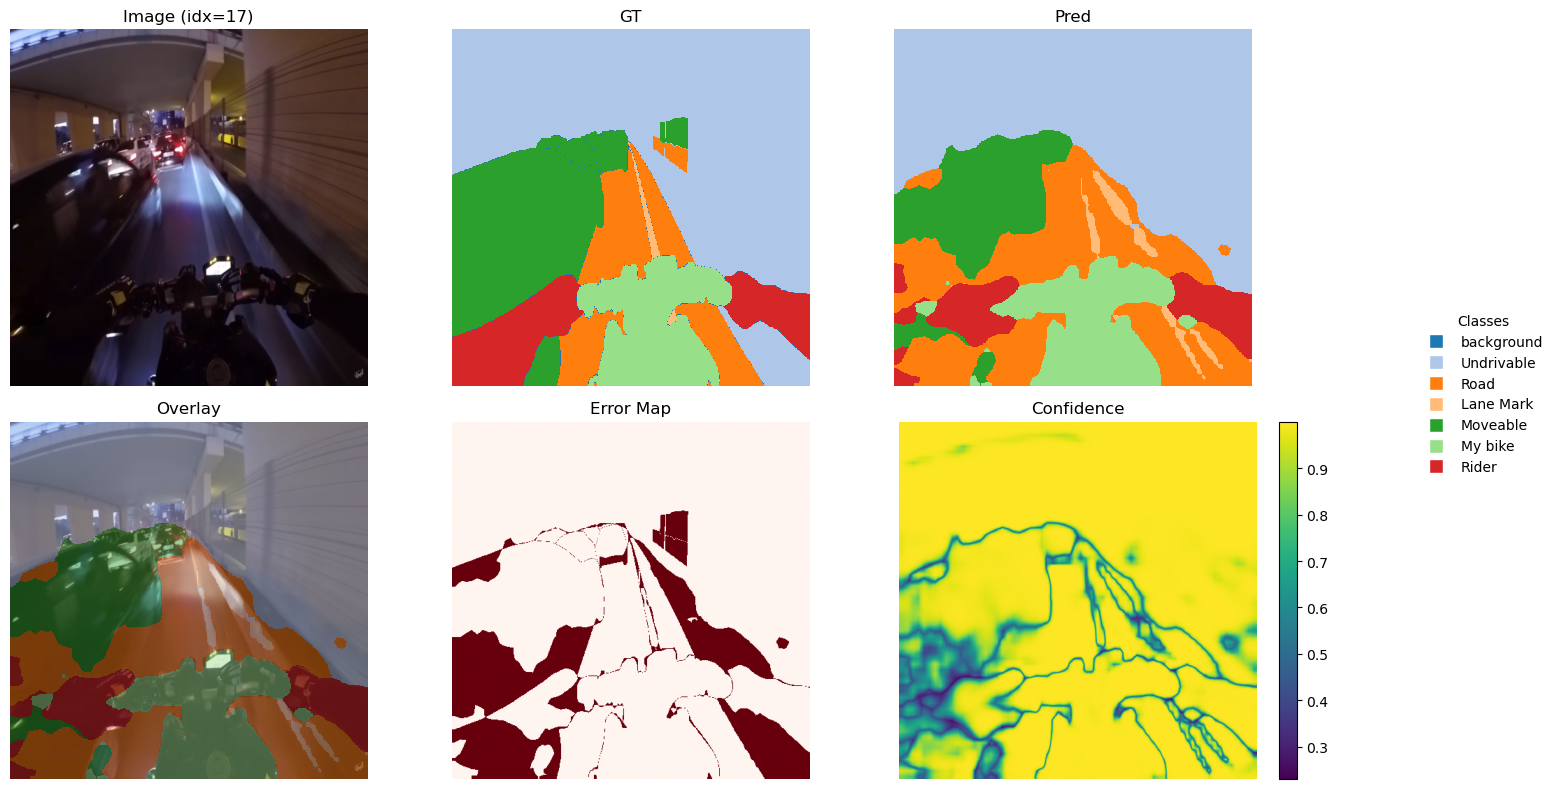

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch

# -----------------------------
# 1) logits 추출 (DeepLab(dict) / UNet(tensor) 모두 대응)
# -----------------------------
def get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

# -----------------------------
# 2) 단일 샘플 시각화 (Image / GT / Pred / Overlay / Error / Conf)
# -----------------------------
@torch.no_grad()
def show_pred(model, dataset, idx=0, alpha=0.5):
    model.eval()

    img, mask = dataset[idx]              # img: (3,H,W), mask: (H,W)
    x = img.unsqueeze(0).to(device)

    logits = get_logits(model(x))[0]      # (C,H,W)
    prob = torch.softmax(logits, dim=0)   # (C,H,W)

    pred = prob.argmax(0).cpu().numpy()  # (H,W)
    conf = prob.max(0)[0].cpu().numpy()  # (H,W)
    gt   = mask.cpu().numpy()

    # denorm image
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = (img_np * std + mean).clip(0, 1)

    # colormap
    base_cmap = plt.get_cmap("tab20")
    cmap = ListedColormap(base_cmap.colors[:NUM_CLASSES])

    # error map
    error_map = (pred != gt)

    fig, axes = plt.subplots(2, 3, figsize=(14, 8))

    axes[0,0].imshow(img_np); axes[0,0].set_title(f"Image (idx={idx})"); axes[0,0].axis("off")
    axes[0,1].imshow(gt,   cmap=cmap, vmin=0, vmax=NUM_CLASSES-1, interpolation="nearest"); axes[0,1].set_title("GT"); axes[0,1].axis("off")
    axes[0,2].imshow(pred, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1, interpolation="nearest"); axes[0,2].set_title("Pred"); axes[0,2].axis("off")

    axes[1,0].imshow(img_np)
    axes[1,0].imshow(pred, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1, alpha=alpha, interpolation="nearest")
    axes[1,0].set_title("Overlay"); axes[1,0].axis("off")

    axes[1,1].imshow(error_map, cmap="Reds")
    axes[1,1].set_title("Error Map"); axes[1,1].axis("off")

    im = axes[1,2].imshow(conf, cmap="viridis")
    axes[1,2].set_title("Confidence"); axes[1,2].axis("off")
    fig.colorbar(im, ax=axes[1,2], fraction=0.046)

    # legend
    handles, labels = [], []
    for cls in range(NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        handles.append(plt.Line2D([0],[0], marker='s', color='w',
                                  markerfacecolor=cmap(cls), markersize=10))
        labels.append(name)

    fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.15, 0.5),
               frameon=False, title="Classes")

    plt.tight_layout()
    plt.show()

# -----------------------------
# 3) Worst-k 
# -----------------------------
@torch.no_grad()
def worst_k_visualize(model, dataset, k=2, max_scan=None):
    model.eval()
    scores = []

    N = len(dataset) if max_scan is None else min(len(dataset), max_scan)

    for i in range(N):
        img_t, gt = dataset[i]
        x = img_t.unsqueeze(0).to(device)

        logits = get_logits(model(x))
        pred = logits.argmax(1).squeeze(0).detach().cpu().numpy()
        gt_np = gt.detach().cpu().numpy()

        acc = (pred == gt_np).mean()
        scores.append((acc, i))

    scores.sort(key=lambda x: x[0])  # 낮은 acc 순
    worst_idxs = [i for _, i in scores[:k]]

    print("🔥 Worst sample idxs:", worst_idxs)

    for idx in worst_idxs:
        # 간단 점수 출력(필요 없으면 지워도 됨)
        img_t, gt = dataset[idx]
        x = img_t.unsqueeze(0).to(device)
        logits = get_logits(model(x))
        pred = logits.argmax(1).squeeze(0).detach().cpu().numpy()
        acc = (pred == gt.detach().cpu().numpy()).mean()
        print(f"idx={idx} | pixel_acc={acc:.4f}")

        show_pred(model, dataset, idx=idx, alpha=0.45)

# 실행
worst_k_visualize(model, val_ds, k=2)

### 성능평가(Test dataset)

In [21]:
import numpy as np
import torch
from torch.utils.data import DataLoader

# ======================
# Test Dataset / Loader
# ======================
test_ds = COCOSemSeg(
    coco, IMG_DIR, test_ids, id2train,
    size=(512, 512), train=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=2,  # ✅ 로컬/주피터에서 안전
    pin_memory=torch.cuda.is_available()
)

print("test:", len(test_ds))

# ======================
# Best Model Load
# ======================
BEST_PATH = "baseline_deeplabv3_resnet50.pth"  # 저장한 파일명
state = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()
print("✅ loaded best:", BEST_PATH)

# ======================
# Test Evaluate  (✅ validate 시그니처 맞춤)
# ======================
test_loss, test_miou, test_per_class = validate(
    model, test_loader,
    criterion, device, NUM_CLASSES
)

print("\n===== TEST BENCHMARK =====")
print(f"test_loss = {float(test_loss):.4f}")
print(f"test_mIoU = {float(test_miou):.4f}")

# ----------------------
# per-class IoU 출력 (dict/list 둘 다 대응)
# ----------------------
if isinstance(test_per_class, dict):
    for cls in range(1, NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        v = test_per_class.get(cls, float("nan"))
        if np.isfinite(v):
            print(f"  IoU {name:10s}: {float(v):.4f}")
        else:
            print(f"  IoU {name:10s}: nan")
else:
    arr = np.array(test_per_class, dtype=np.float32)
    for cls in range(1, NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        v = arr[cls] if cls < len(arr) else np.nan
        if np.isfinite(v):
            print(f"  IoU {name:10s}: {float(v):.4f}")
        else:
            print(f"  IoU {name:10s}: nan")


test: 20
✅ loaded best: baseline_deeplabv3_resnet50.pth

===== TEST BENCHMARK =====
test_loss = 0.1561
test_mIoU = 0.8310
  IoU Undrivable: 0.9491
  IoU Road      : 0.8885
  IoU Lane Mark : 0.5255
  IoU Moveable  : 0.7446
  IoU My bike   : 0.9489
  IoU Rider     : 0.9295


### 2.1.2. U-Net(Backbone ResNet 50)

In [22]:
# --- UNet(ResNet encoder) 모델만 교체 ---
import torch.nn as nn

try:
    import segmentation_models_pytorch as smp
except ImportError:
    raise ImportError("pip install segmentation-models-pytorch 로 설치 후 진행하세요.")

# UNet + ResNet50 encoder (ImageNet pretrained)
core = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None,
)

# smp는 logits만 반환 → torchvision처럼 {"out": logits}로 래핑
class Wrap(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

model = Wrap(core).to(device)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [23]:
@torch.no_grad()
def compute_iou(pred, target, num_classes):
    # pred/target: (N,H,W)
    ious = []
    per_class = {}
    for cls in range(num_classes):
        pred_i = (pred == cls)
        targ_i = (target == cls)
        inter = (pred_i & targ_i).sum().item()
        union = (pred_i | targ_i).sum().item()
        if union == 0:
            iou = float("nan")
        else:
            iou = inter / union
        per_class[cls] = iou
        ious.append(iou)
    # mean over valid classes
    valid = [x for x in ious if not (isinstance(x, float) and np.isnan(x))]
    miou = float(np.mean(valid)) if len(valid) else 0.0
    return miou, per_class

In [24]:
import torch
import numpy as np
from tqdm.auto import tqdm

@torch.no_grad()
def validate(model, loader, criterion, device, num_classes, ignore_index=None):
    model.eval()
    total_loss = 0.0

    # confusion matrix: [num_classes, num_classes]
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)

    for imgs, masks in tqdm(loader, desc="val", leave=False):
        imgs  = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = model(imgs)["out"]              # (N,C,H,W)
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        preds = logits.argmax(dim=1)             # (N,H,W)

        # flatten
        preds = preds.view(-1).detach().cpu()
        gts   = masks.view(-1).detach().cpu()

        if ignore_index is not None:
            keep = (gts != ignore_index)
            preds = preds[keep]
            gts   = gts[keep]

        k = (gts >= 0) & (gts < num_classes)
        inds = num_classes * gts[k] + preds[k]
        conf += torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)

    # IoU 계산
    tp = conf.diag().float()
    fp = conf.sum(0).float() - tp
    fn = conf.sum(1).float() - tp
    denom = tp + fp + fn

    per_class_iou = (tp / torch.clamp(denom, min=1.0)).numpy()  # shape: [C]
    # background(0) 제외 mIoU (원하면 포함/제외 변경 가능)
    miou = float(np.nanmean(per_class_iou[1:]))

    # dict 형태로도 반환(기존 코드 호환)
    per_class_dict = {c: float(per_class_iou[c]) for c in range(num_classes)}

    val_loss = total_loss / len(loader.dataset)
    return val_loss, miou, per_class_dict

In [25]:
# =========================================================
# UNet(ResNet50 encoder) + 학습 루프 (인자형 train/validate 대응)
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# =========================
# 0) UNet 모델 정의 (ResNet50 encoder)
# =========================
try:
    import segmentation_models_pytorch as smp
except ImportError:
    raise ImportError("segmentation_models_pytorch 필요: pip install segmentation-models-pytorch")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

core_unet = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
)

class WrapOut(nn.Module):
    """smp는 Tensor(logits) 반환 → torchvision처럼 {'out': logits}로 맞춤"""
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

model = WrapOut(core_unet).to(device)

# =========================
# 1) Loss / Optimizer 재생성 (필수)
# =========================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# sanity check
model_param_ids = set(id(p) for p in model.parameters())
opt_param_ids = set(id(p) for g in optimizer.param_groups for p in g["params"])
assert len(model_param_ids & opt_param_ids) > 0, "❌ optimizer가 UNet 파라미터를 안 잡고 있습니다."

print("✅ UNet ready:", type(model))
print("✅ optimizer param count:", sum(len(g["params"]) for g in optimizer.param_groups))

# =========================
# 2) CONFIG
# =========================
EPOCHS = 30
PATIENCE = 3
MODEL_NAME = "baseline_unet_resnet50.pth"
HISTORY_NAME = "history_unet_resnet50.npz"

best_miou = -1.0
patience_counter = 0

# =========================
# 3) per_class 정리 유틸
# =========================
def to_per_class_list(per_class, num_classes: int):
    out = [np.nan] * num_classes
    if isinstance(per_class, dict):
        for c in range(num_classes):
            if c in per_class:
                try:
                    v = float(per_class[c])
                    out[c] = v if np.isfinite(v) else np.nan
                except:
                    out[c] = np.nan
        return out
    if isinstance(per_class, (list, tuple, np.ndarray)):
        L = min(len(per_class), num_classes)
        for c in range(L):
            try:
                v = float(per_class[c])
                out[c] = v if np.isfinite(v) else np.nan
            except:
                out[c] = np.nan
        return out
    return out

# =========================
# 4) history
# =========================
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "per_class_iou": []
}

# =========================
# 5) TRAIN LOOP  (✅ 인자형 함수 호출로 수정)
# =========================
for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    va_loss, va_miou, per_class = validate(model, val_loader, criterion, device, NUM_CLASSES)

    per_class_list = to_per_class_list(per_class, NUM_CLASSES)

    print(f"[UNet] [{epoch:02d}/{EPOCHS}] "
          f"train_loss={float(tr_loss):.4f} | val_loss={float(va_loss):.4f} | mIoU={float(va_miou):.4f}")

    for cls in range(1, NUM_CLASSES):
        cls_name = train2name.get(cls, str(cls)) if isinstance(train2name, dict) else str(cls)
        iou = per_class_list[cls]
        print(f"  IoU {cls_name:10s}: {'nan' if np.isnan(iou) else f'{iou:.4f}'}")

    history["epoch"].append(int(epoch))
    history["train_loss"].append(float(tr_loss))
    history["val_loss"].append(float(va_loss))
    history["val_miou"].append(float(va_miou))
    history["per_class_iou"].append([float(x) if np.isfinite(x) else np.nan for x in per_class_list])

    # best + early stopping
    if float(va_miou) > float(best_miou):
        best_miou = float(va_miou)
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_NAME)
        print(f"  ✅ saved: {MODEL_NAME} (best_mIoU={best_miou:.4f})")
    else:
        patience_counter += 1
        print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE}) | best_mIoU={best_miou:.4f}")

    if patience_counter >= PATIENCE:
        print(f"\n🛑 Early stopping triggered at epoch {epoch}")
        print(f"Best mIoU: {best_miou:.4f}")
        break

# =========================
# 6) history 저장
# =========================
try:
    np.savez(
        HISTORY_NAME,
        epoch=np.array(history["epoch"], dtype=np.int32),
        train_loss=np.array(history["train_loss"], dtype=np.float32),
        val_loss=np.array(history["val_loss"], dtype=np.float32),
        val_miou=np.array(history["val_miou"], dtype=np.float32),
        per_class_iou=np.array(history["per_class_iou"], dtype=np.float32),
    )
    print(f"\n✅ history saved: {HISTORY_NAME}")
except Exception as e:
    print(f"\n⚠ history save skipped: {e}")

device: cuda
✅ UNet ready: <class '__main__.WrapOut'>
✅ optimizer param count: 191


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [01/30] train_loss=0.9761 | val_loss=0.6415 | mIoU=0.5958
  IoU Undrivable: 0.8496
  IoU Road      : 0.7469
  IoU Lane Mark : 0.0097
  IoU Moveable  : 0.4940
  IoU My bike   : 0.8072
  IoU Rider     : 0.6673
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.5958)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [02/30] train_loss=0.4644 | val_loss=0.4244 | mIoU=0.6502
  IoU Undrivable: 0.8567
  IoU Road      : 0.7735
  IoU Lane Mark : 0.0002
  IoU Moveable  : 0.5594
  IoU My bike   : 0.8770
  IoU Rider     : 0.8344
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6502)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [03/30] train_loss=0.3441 | val_loss=0.3661 | mIoU=0.6549
  IoU Undrivable: 0.8591
  IoU Road      : 0.7838
  IoU Lane Mark : 0.0001
  IoU Moveable  : 0.5494
  IoU My bike   : 0.8860
  IoU Rider     : 0.8512
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6549)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [04/30] train_loss=0.3087 | val_loss=0.3413 | mIoU=0.6699
  IoU Undrivable: 0.8786
  IoU Road      : 0.8260
  IoU Lane Mark : 0.0002
  IoU Moveable  : 0.6039
  IoU My bike   : 0.8851
  IoU Rider     : 0.8254
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6699)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [05/30] train_loss=0.2667 | val_loss=0.3163 | mIoU=0.6731
  IoU Undrivable: 0.8910
  IoU Road      : 0.8095
  IoU Lane Mark : 0.0002
  IoU Moveable  : 0.6224
  IoU My bike   : 0.8996
  IoU Rider     : 0.8157
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6731)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [06/30] train_loss=0.2489 | val_loss=0.3316 | mIoU=0.6760
  IoU Undrivable: 0.8703
  IoU Road      : 0.8012
  IoU Lane Mark : 0.0004
  IoU Moveable  : 0.6173
  IoU My bike   : 0.8940
  IoU Rider     : 0.8729
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6760)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [07/30] train_loss=0.2210 | val_loss=0.3075 | mIoU=0.6746
  IoU Undrivable: 0.9008
  IoU Road      : 0.8123
  IoU Lane Mark : 0.0016
  IoU Moveable  : 0.5966
  IoU My bike   : 0.8733
  IoU Rider     : 0.8631
  ⏸ no improvement (1/3) | best_mIoU=0.6760


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [08/30] train_loss=0.1963 | val_loss=0.2823 | mIoU=0.7111
  IoU Undrivable: 0.8830
  IoU Road      : 0.8222
  IoU Lane Mark : 0.0190
  IoU Moveable  : 0.7125
  IoU My bike   : 0.9267
  IoU Rider     : 0.9036
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.7111)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [09/30] train_loss=0.1827 | val_loss=0.3340 | mIoU=0.7131
  IoU Undrivable: 0.8540
  IoU Road      : 0.8024
  IoU Lane Mark : 0.1913
  IoU Moveable  : 0.6238
  IoU My bike   : 0.9259
  IoU Rider     : 0.8812
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.7131)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [10/30] train_loss=0.2218 | val_loss=0.4167 | mIoU=0.6596
  IoU Undrivable: 0.8601
  IoU Road      : 0.7686
  IoU Lane Mark : 0.1777
  IoU Moveable  : 0.4704
  IoU My bike   : 0.8735
  IoU Rider     : 0.8075
  ⏸ no improvement (1/3) | best_mIoU=0.7131


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [11/30] train_loss=0.2119 | val_loss=0.3931 | mIoU=0.6800
  IoU Undrivable: 0.8442
  IoU Road      : 0.7592
  IoU Lane Mark : 0.1904
  IoU Moveable  : 0.5769
  IoU My bike   : 0.8895
  IoU Rider     : 0.8196
  ⏸ no improvement (2/3) | best_mIoU=0.7131


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [12/30] train_loss=0.1901 | val_loss=0.2599 | mIoU=0.7554
  IoU Undrivable: 0.8986
  IoU Road      : 0.8210
  IoU Lane Mark : 0.2693
  IoU Moveable  : 0.7081
  IoU My bike   : 0.9268
  IoU Rider     : 0.9086
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.7554)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [13/30] train_loss=0.1670 | val_loss=0.3211 | mIoU=0.7163
  IoU Undrivable: 0.8868
  IoU Road      : 0.8183
  IoU Lane Mark : 0.2510
  IoU Moveable  : 0.6211
  IoU My bike   : 0.8783
  IoU Rider     : 0.8422
  ⏸ no improvement (1/3) | best_mIoU=0.7554


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [14/30] train_loss=0.1610 | val_loss=0.2166 | mIoU=0.7798
  IoU Undrivable: 0.9041
  IoU Road      : 0.8664
  IoU Lane Mark : 0.3259
  IoU Moveable  : 0.7197
  IoU My bike   : 0.9458
  IoU Rider     : 0.9170
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.7798)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [15/30] train_loss=0.1468 | val_loss=0.2511 | mIoU=0.7579
  IoU Undrivable: 0.9055
  IoU Road      : 0.8538
  IoU Lane Mark : 0.2980
  IoU Moveable  : 0.6873
  IoU My bike   : 0.9208
  IoU Rider     : 0.8821
  ⏸ no improvement (1/3) | best_mIoU=0.7798


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [16/30] train_loss=0.1383 | val_loss=0.4211 | mIoU=0.6762
  IoU Undrivable: 0.8732
  IoU Road      : 0.8353
  IoU Lane Mark : 0.2697
  IoU Moveable  : 0.5607
  IoU My bike   : 0.8206
  IoU Rider     : 0.6976
  ⏸ no improvement (2/3) | best_mIoU=0.7798


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [17/30] train_loss=0.1385 | val_loss=0.2917 | mIoU=0.7518
  IoU Undrivable: 0.8811
  IoU Road      : 0.8408
  IoU Lane Mark : 0.3064
  IoU Moveable  : 0.6676
  IoU My bike   : 0.9145
  IoU Rider     : 0.9001
  ⏸ no improvement (3/3) | best_mIoU=0.7798

🛑 Early stopping triggered at epoch 17
Best mIoU: 0.7798

✅ history saved: history_unet_resnet50.npz


### U-Net Test

In [26]:
# =========================================================
# UNet TEST BENCHMARK  ✅복붙용 수정본 (NUM_WORKERS=0 기준)
# =========================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ======================
# 0) device
# ======================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ======================
# 1) Test Dataset / Loader
# ======================
test_ds = COCOSemSeg(
    coco, IMG_DIR, test_ids, id2train,
    size=(512, 512), train=False
)

# ✅ NUM_WORKERS=0이면 아래 옵션들( worker_init_fn / generator / persistent_workers ) 제거
test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print("test:", len(test_ds))

# ======================
# 2) UNet 모델 재구성 + 로드
# ======================
try:
    import segmentation_models_pytorch as smp
except ImportError:
    raise ImportError("segmentation_models_pytorch 필요: pip install segmentation-models-pytorch")

core_unet = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
)

class WrapOut(nn.Module):
    """smp는 Tensor(logits) 반환 → torchvision처럼 {'out': logits}로 맞춤"""
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

model = WrapOut(core_unet).to(device)

# ======================
# 3) Loss (validate에서 필요)
# ======================
criterion = nn.CrossEntropyLoss()

# ======================
# 4) best weight 로드
# ======================
BEST_PATH = "baseline_unet_resnet50.pth"   # ✅ UNet best 파일
state = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
print("✅ loaded best:", BEST_PATH)

# ======================
# 5) TEST 실행 (인자형 validate 호출)
# ======================
test_loss, test_miou, test_per_class = validate(
    model=model,
    loader=test_loader,
    criterion=criterion,
    device=device,
    num_classes=NUM_CLASSES,
    ignore_index=None
)

print("\n===== UNet TEST BENCHMARK =====")
print(f"test_loss = {float(test_loss):.4f}")
print(f"test_mIoU = {float(test_miou):.4f}")

# test_per_class는 dict 형태(권장) / list 형태 둘 다 대응
for cls in range(1, NUM_CLASSES):
    name = train2name.get(cls, f"class_{cls}")

    if isinstance(test_per_class, dict):
        v = float(test_per_class.get(cls, np.nan))
    else:
        v = float(test_per_class[cls]) if cls < len(test_per_class) else np.nan

    print(f"  IoU {name:10s}: {'nan' if np.isnan(v) else f'{v:.4f}'}")


device: cuda
test: 20
✅ loaded best: baseline_unet_resnet50.pth


val:   0%|          | 0/5 [00:00<?, ?it/s]


===== UNet TEST BENCHMARK =====
test_loss = 0.1789
test_mIoU = 0.8072
  IoU Undrivable: 0.9318
  IoU Road      : 0.8706
  IoU Lane Mark : 0.4819
  IoU Moveable  : 0.6956
  IoU My bike   : 0.9494
  IoU Rider     : 0.9139


### Baseline 결정
#### 1) Test 결과 비교(총 3회 시행)
---
- 총 3회 반복하여 테스트한 결과 3회 모두 Deeplab v3 U-Net 보다 우수함
- 특히 가장 좋은 성능간 비교를 기준으로 양자의 차이를 비교하면 아래와 같음

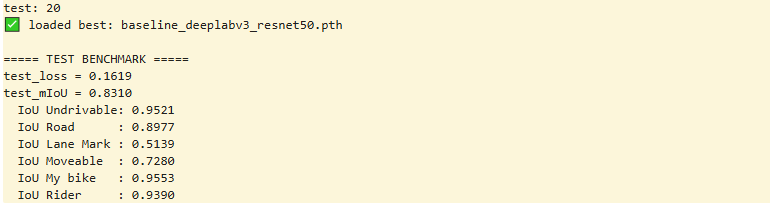
##### mIoU
- UNet: 0.7988
- DeepLabV3: 0.8310 
- → DeepLabV3 +0.0322p( 우세)
  
#### test_loss
- UNet: 0.1693
- DeepLabV3: 0.1619 → DeepLab이 더 낮음(좋음)

##### Lane Mark IoU 
- DeepLab: 0.5139
- UNet: 0.4196
- → +0.0943 Deeplab 우세

#### 클래스별 IoU 비교 (DeepLab이 전부 우세)
- Undrivable: 0.9397 → 0.9521 (+0.0124)
- Road: 0.8834 → 0.8977 (+0.0143)
- Lane Mark: 0.4196 → 0.5139 (+0.0943) 
- Moveable: 0.6696 → 0.7280 (+0.0584)
- My bike: 0.9525 → 0.9553 (+0.0028)
- Rider: 0.9279 → 0.9390 (+0.0111)

### 2) 베이스라인 결정
- 2. Base Line 모델 결정: DeepLabV3-ResNet50 확정

### 2.2.1 DeepLab V3 (Backbone EffientNet-B3)

In [27]:
# =========================================================
# DeepLabV3 (EfficientNet-B3 encoder) - model 생성 
# - 존 train_one_epoch / validate / 시각화 / test 코드 그대로 재사용
# - 핵심: smp 모델(Tensor logits)을 torchvision처럼 {"out": logits}로 래핑
# =========================================================

import torch
import torch.nn as nn

import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ---- DeepLabV3 with EfficientNet-B3 encoder ----
core = smp.DeepLabV3(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
)

class WrapOut(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}  # torchvision 호환

model = WrapOut(core).to(device)
print("✅ model ready:", type(model))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# sanity check
model_param_ids = set(id(p) for p in model.parameters())
opt_param_ids = set(id(p) for g in optimizer.param_groups for p in g["params"])
assert len(model_param_ids & opt_param_ids) > 0, "❌ optimizer가 현재 model 파라미터를 안 잡고 있습니다."

print("✅ optimizer ok")


device: cuda


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

✅ model ready: <class '__main__.WrapOut'>
✅ optimizer ok


In [28]:
import numpy as np
import torch

# ---------------------------------
# 1) 모델 출력(logits) 통일
#   - torchvision: dict["out"]
#   - smp: Tensor
# ---------------------------------
def _get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

# ---------------------------------
# 2) confusion matrix 누적
# ---------------------------------
def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)

    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]

    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background: bool = True):
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn

    iou = tp / torch.clamp(denom, min=1.0)  # (C,)
    iou = iou.cpu().numpy()

    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou

# ---------------------------------
# 3) train / validate (✅ exclude_background 지원)
# ---------------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))        # (N,C,H,W)
        loss = criterion(logits, masks)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)

@torch.no_grad()
def validate(model, loader, criterion, device, num_classes,
             exclude_background: bool = True, ignore_index=None):
    model.eval()
    total_loss = 0.0

    # CPU 누적
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long, device="cpu")

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))        # (N,C,H,W)
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)              # (N,H,W)
        conf += _confusion_from_pred(
            pred.detach().cpu(),
            masks.detach().cpu(),
            num_classes=num_classes,
            ignore_index=ignore_index
        )

    val_loss = total_loss / len(loader.dataset)
    miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)

    # 기존 코드 호환: dict로 반환
    per_class_dict = {c: float(per_class_iou[c]) for c in range(num_classes)}
    return val_loss, miou, per_class_dict

va_loss, va_miou, per_class = validate(
    model, val_loader, criterion, device, NUM_CLASSES,
    exclude_background=True
)


In [29]:
import os
import numpy as np
import torch

# =========================
# CONFIG
# =========================
EPOCHS = 30
PATIENCE = 3

MODEL_NAME = "deeplabv3_effb3_best.pth"
HISTORY_NAME = "deeplabv3_effb3_history.npz"

best_miou = -1.0
patience_counter = 0

# =========================
# history buffer
# =========================
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "per_class_iou": []
}

# =========================
# TRAIN LOOP
# =========================
for epoch in range(1, EPOCHS + 1):

    # ----- train -----
    tr_loss = train_one_epoch(
        model,
        train_loader,
        criterion,
        optimizer,
        device
    )

    # ----- validate -----
    va_loss, va_miou, per_class = validate(
        model,
        val_loader,
        criterion,
        device,
        NUM_CLASSES,
        exclude_background=True
    )

    # ---- 출력 ----
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | mIoU={va_miou:.4f}")

    for cls in range(1, NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        print(f"  IoU {name:10s}: {per_class[cls]:.4f}")

    # ---- history 저장 ----
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["per_class_iou"].append(
        [per_class[c] for c in range(NUM_CLASSES)]
    )

    # ---- best model ----
    if va_miou > best_miou:
        best_miou = va_miou
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_NAME)
        print(f"  ✅ saved best model ({best_miou:.4f})")

    else:
        patience_counter += 1
        print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE})")

    if patience_counter >= PATIENCE:
        print("🛑 Early stopping triggered")
        break

# =========================
# history 저장
# =========================
np.savez(
    HISTORY_NAME,
    epoch=np.array(history["epoch"]),
    train_loss=np.array(history["train_loss"]),
    val_loss=np.array(history["val_loss"]),
    val_miou=np.array(history["val_miou"]),
    per_class_iou=np.array(history["per_class_iou"])
)

print("✅ history saved")


[01/30] train_loss=0.6321 | val_loss=0.4446 | mIoU=0.5952
  IoU Undrivable: 0.8569
  IoU Road      : 0.6695
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.5148
  IoU My bike   : 0.7770
  IoU Rider     : 0.7530
  ✅ saved best model (0.5952)
[02/30] train_loss=0.3399 | val_loss=0.3378 | mIoU=0.6454
  IoU Undrivable: 0.8765
  IoU Road      : 0.7332
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.6155
  IoU My bike   : 0.8389
  IoU Rider     : 0.8085
  ✅ saved best model (0.6454)
[03/30] train_loss=0.2776 | val_loss=0.3133 | mIoU=0.6699
  IoU Undrivable: 0.8804
  IoU Road      : 0.7513
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.6958
  IoU My bike   : 0.8548
  IoU Rider     : 0.8374
  ✅ saved best model (0.6699)
[04/30] train_loss=0.2355 | val_loss=0.2751 | mIoU=0.7023
  IoU Undrivable: 0.8894
  IoU Road      : 0.7723
  IoU Lane Mark : 0.0628
  IoU Moveable  : 0.7435
  IoU My bike   : 0.8891
  IoU Rider     : 0.8568
  ✅ saved best model (0.7023)
[05/30] train_loss=0.2017 | val_loss=0.2602 | mI

In [30]:
# =========================================================
# ✅ DeepLabV3(EfficientNet-B3) TEST BENCHMARK - 복붙용 (자동 로드 호환)
# - MODEL_NAME: deeplabv3_effb3_best.pth
# - 학습 때 WrapOut(core)로 저장했든, core로 저장했든 둘 다 로드되게 처리
# - NUM_WORKERS=2기준
# =========================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from collections import OrderedDict

import segmentation_models_pytorch as smp

# -------------------------
# CONFIG
# -------------------------
MODEL_NAME   = "deeplabv3_effb3_best.pth"
HISTORY_NAME = "deeplabv3_effb3_history.npz"  # 테스트엔 필수 아님

# -------------------------
# device
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -------------------------
# Test Dataset / Loader
# -------------------------
test_ds = COCOSemSeg(
    coco, IMG_DIR, test_ids, id2train,
    size=(512, 512), train=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

print("test:", len(test_ds))

# -------------------------
# WrapOut (학습 때 썼던 래퍼)
# -------------------------
class WrapOut(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

# -------------------------
# logits 공용
# -------------------------
def _get_logits(model_out):
    return model_out["out"] if isinstance(model_out, dict) else model_out

# -------------------------
# confusion / IoU 유틸
# -------------------------
def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)

    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]

    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background=True):
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn
    iou = tp / torch.clamp(denom, min=1.0)
    iou = iou.cpu().numpy()

    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou

@torch.no_grad()
def validate(model, loader, criterion, device, num_classes,
             exclude_background=True, ignore_index=None):
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long, device="cpu")

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)
        conf += _confusion_from_pred(
            pred.detach().cpu(),
            masks.detach().cpu(),
            num_classes=num_classes,
            ignore_index=ignore_index
        )

    test_loss = total_loss / len(loader.dataset)
    miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)
    per_class_dict = {c: float(per_class_iou[c]) for c in range(num_classes)}
    return float(test_loss), float(miou), per_class_dict

# -------------------------
# 모델 생성 (core + wrapped 둘 다 준비)
# -------------------------
core = smp.DeepLabV3(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
).to(device)

wrapped = WrapOut(core).to(device)

criterion = nn.CrossEntropyLoss()

# -------------------------
# state_dict 로드 (자동 호환: m. prefix 있으면 wrapped에, 없으면 core에)
# -------------------------
state = torch.load(MODEL_NAME, map_location=device)

# 1) key에 "m."가 있으면 -> WrapOut 저장본
has_m_prefix = any(k.startswith("m.") for k in state.keys())

if has_m_prefix:
    model = wrapped
    model.load_state_dict(state, strict=True)
    print("✅ loaded as WrapOut(model). state_dict keys include 'm.'")
else:
    model = core
    model.load_state_dict(state, strict=True)
    print("✅ loaded as core(model). state_dict keys without 'm.'")

model.eval()
print("✅ loaded best:", MODEL_NAME)

# -------------------------
# TEST 실행
# -------------------------
test_loss, test_miou, test_per_class = validate(
    model=model,
    loader=test_loader,
    criterion=criterion,
    device=device,
    num_classes=NUM_CLASSES,
    exclude_background=True,
    ignore_index=None
)

print("\n===== DeepLabV3-EffB3 TEST BENCHMARK =====")
print(f"test_loss = {test_loss:.4f}")
print(f"test_mIoU = {test_miou:.4f}")

for cls in range(1, NUM_CLASSES):
    name = train2name.get(cls, f"class_{cls}")
    v = float(test_per_class.get(cls, np.nan))
    print(f"  IoU {name:10s}: {'nan' if np.isnan(v) else f'{v:.4f}'}")


device: cuda
test: 20
✅ loaded as WrapOut(model). state_dict keys include 'm.'
✅ loaded best: deeplabv3_effb3_best.pth

===== DeepLabV3-EffB3 TEST BENCHMARK =====
test_loss = 0.1573
test_mIoU = 0.8287
  IoU Undrivable: 0.9494
  IoU Road      : 0.8912
  IoU Lane Mark : 0.4936
  IoU Moveable  : 0.7640
  IoU My bike   : 0.9469
  IoU Rider     : 0.9269


### Baseline 결정
---
#### Test 결과 비교
##### mIoU
- EfficientNet-B3: 0.8028
- ResNet50: 0.8294 → +0.0266p (약 +2.7%p)
#### 클래스별 IoU(핵심 차이)
- Undrivable: 0.9445 vs 0.9493 (ResNet +0.0048)
- Road: 0.8770 vs 0.8902 (ResNet +0.0132)
- Lane Mark: 0.4232 vs 0.5174 (ResNet +0.0942) ✅ 가장 중요한 차이
- Moveable: 0.7177 vs 0.7371 (ResNet +0.0194)
- My bike: 0.9380 vs 0.9521 (ResNet +0.0141)
- Rider: 0.9162 vs 0.9304 (ResNet +0.0142)
- 결론: EffientNet이 test loss가 낮음 그러나 IoU 분야는 ResNet50이 모든 클래스에서 더 좋고, 특히 Lane Mark에서 큰 차이(+0.094)
#### 최종 baseline 결정: Deeplab v3 (backbone: ResNet 50)

## 3. 피처엔지니어링 

### 1. 피처엔지니어링 방향


### 1순위: Gamma + Crop(하단 중심)
- 저조도에서 선이 안 보이는 문제를 직접 건드림(Gamma)
- Lane이 실제로 많이 있는 영역(하단)을 더 크게 보게 만듦(Crop)
- RandomGamma(0.5~2.0) (어두운 쪽 강화 비중 ↑)
-Bottom-center crop 또는 Random crop with lane-presence
- 원본(또는 768) → 하단 60~70% 영역 중심으로 512 crop → resize 유지

### 2순위: CLAHE(약하게) + Crop(하단 중심)

- 야간에서 국부 대비를 살려 “선”을 띄우는 데 강함. 단, 과하면 노이즈도 키우므로 “약하게”가 중요
- CLAHE(clipLimit=2~3, tileGrid=8x8) (RGB 전체 or L 채널만)
- Bottom-center crop / lane-aware crop

### 3순위: Gamma + Contrast/ColorJitter
- 저조도 분포를 넓게 커버하면서(감마)
- 대비를 흔들어 라인을 다양한 조건에서 보게 함(contrast)
- RandomGamma(0.5~2.0)
- ColorJitter(contrast 중심, brightness는 약하게)
- contrast 0.6~1.6, brightness 0.8~1.2

### 4순위: CLAHE(약하게) + Gamma
- CLAHE로 “국부 대비”를 올리고
- Gamma로 “전체 밝기 분포”를 흔들어 저조도 적응 강화. 단, 둘 다 강하면 과보정/노이즈 증폭 위험
- CLAHE 약하게 → Gamma 약~중. 팁: 확률로 켜기(예: CLAHE 0.3, Gamma 0.7)
- 
### 5순위: Gamma + Noise(ISO 흉내)
- 어두운 환경의 핵심 난제는 “노이즈+저대비”라서
- Lane이 노이즈에 묻혀도 버티게 만들 수 있음
- RandomGamma(0.5~2.0)
- Gaussian/Poisson noise (약~중)

### Gamma + Motion/Defocus Blur
- 야간 주행에서 Lane은 흔들림/블러에 잘 죽음. 다만 너무 강하면 학습이 어려워져서 우선순위는 낮춤
- RandomGamma
- MotionBlur(약) 또는 DefocusBlur(약)

### 2. 진행 순서
# 야간 Segmentation 성능 개선 – 핵심 실험 가이드

## 목표
야간 데이터에서 성능이 낮은 두 클래스 개선
- **Lane Mark**: 저조도 영향
- **Moveable**: 작은 객체 문제

---

## 실험 원칙 (필수)
- **Baseline 고정**
  - Model: DeepLabV3 + ResNet50
  - Loss / LR / Split / Seed 동일
  - Resize: 512
- **변수는 1개만 변경**

---

## 실험 플로우 (2단계)

### STEP 1 — 빠른 스크리닝
**목적:** 효과 있는 전처리 찾기  
- Epoch: 8~12  
- Early Stopping: patience=3  


**판정 기준**
- 1순위: Lane Mark IoU
- 2순위: Moveable IoU (GT<0.5%)

---

### STEP 2 — 확정 학습
STEP 1에서 선택된 **1개 설정만** 사용
- Epoch: 30
- Early Stopping: patience=3  
→ 최종 모델

---

## 추가 개선 (필요할 때만, 1개 선택)
- **Option A**: CE + Dice Loss  
- **Option B**: CLAHE (약하게)
  - clipLimit=2~3, p=0.3

---

## ✅ 실행 체크리스트
- [x] Run-0 Baseline
- [ ] Run-1 Crop
- [ ] Run-2 Gamma
- [ ] Run-3 Crop + Gamma
- [ ] STEP 2 풀 학습
- [ ] 필요 시 Loss 또는 CLAHE 추가

In [ ]:
# ============================================================
# wideXcrop ONLY - CROP SWEEP (jitter만 바꿔서 3번 실험)
#  - OFF: Gamma/Color/Flip 등 전부 OFF
#  - 변경: x_crop_jitter만 {0.00, 0.05, 0.10}로 비교
#  - 파일명 자동 분기
# ============================================================

import os, random
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

# ======================
# 재현성
# ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

g = torch.Generator()
g.manual_seed(SEED)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ======================
# Dataset
# ======================
class COCOSemSeg(Dataset):
    """
    (필수)
    - Letterbox(왜곡 제거) + Normalize
    - Train에만 x-crop 랜덤화 (jitter)

    (핵심)
    - wide letterbox: (H=512, W=1024)
    - final input: 512x512는 좌우(x) crop만으로 만듦 (y 고정)

    (OFF)
    - Gamma/Contrast/Brightness/Flip/RandomCrop 등 전부 OFF
    """
    def __init__(
        self,
        coco,
        img_dir: str,
        img_ids,
        id2train: dict,
        size=(512, 512),                # (H,W)
        wide_canvas=(512, 1024),         # (H,W)
        train=True,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        priority_order=None,
        x_crop_jitter=0.15,              # 중앙에서 좌우 흔들림(0.0~0.25)
        y_anchor="top",                  # "top" or "center"
    ):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train

        self.size = size
        self.wide_canvas = wide_canvas
        self.train = train

        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=list(mean), std=list(std))

        self.priority_order = priority_order
        if self.priority_order is not None:
            self._prio_rank = {cid: i for i, cid in enumerate(self.priority_order)}

        self.x_crop_jitter = x_crop_jitter
        self.y_anchor = y_anchor

    def __len__(self):
        return len(self.img_ids)

    def _build_mask(self, img_id, H, W):
        mask = np.zeros((H, W), dtype=np.uint16)
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        if self.priority_order is not None:
            anns = sorted(anns, key=lambda a: self._prio_rank.get(a["category_id"], -1))

        for ann in anns:
            cid = ann["category_id"]
            if cid not in self.id2train:
                continue
            m = self.coco.annToMask(ann).astype(bool)
            mask[m] = self.id2train[cid]
        return mask

    def _letterbox_resize(self, img, mask, out_size):
        th, tw = out_size
        w, h = img.size  # (W,H)

        scale = min(tw / w, th / h)
        nw, nh = int(w * scale), int(h * scale)

        img  = TF.resize(img,  (nh, nw), interpolation=Image.BILINEAR)
        mask = TF.resize(mask, (nh, nw), interpolation=Image.NEAREST)

        pad_w = tw - nw
        pad_h = th - nh
        left = pad_w // 2
        right = pad_w - left
        top = pad_h // 2
        bottom = pad_h - top

        img  = TF.pad(img,  padding=[left, top, right, bottom], fill=0)
        mask = TF.pad(mask, padding=[left, top, right, bottom], fill=0)
        return img, mask

    def _width_only_crop(self, img, mask, out_size, jitter_ratio, deterministic_center=False):
        th, tw = out_size
        W, H = img.size  # (W,H)

        if (tw > W) or (th > H):
            return img, mask

        # y 고정
        if self.y_anchor == "center":
            y = (H - th) // 2
        else:
            y = 0  # top

        center_x = (W - tw) // 2

        if deterministic_center or jitter_ratio <= 0:
            x = center_x
        else:
            jitter = int(jitter_ratio * (W - tw))
            x_min = max(0, center_x - jitter)
            x_max = min(W - tw, center_x + jitter)
            x = random.randint(x_min, x_max) if x_max >= x_min else center_x

        img  = TF.crop(img,  y, x, th, tw)
        mask = TF.crop(mask, y, x, th, tw)
        return img, mask

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]
        fp = os.path.join(self.img_dir, img_info["file_name"])

        img = Image.open(fp).convert("RGB")
        W, H = img.size
        mask = Image.fromarray(self._build_mask(img_id, H, W))

        # 1) wide letterbox
        img, mask = self._letterbox_resize(img, mask, self.wide_canvas)

        # 2) width-only crop
        if self.train:
            img, mask = self._width_only_crop(
                img, mask, self.size,
                jitter_ratio=self.x_crop_jitter,
                deterministic_center=False
            )
        else:
            img, mask = self._width_only_crop(
                img, mask, self.size,
                jitter_ratio=0.0,
                deterministic_center=True
            )

        img = self.normalize(self.to_tensor(img))
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask


# ======================
# COCO 관련 변수는 이미 존재한다고 가정:
# - DATA_ROOT, coco
# ======================
IMG_DIR = os.path.join(DATA_ROOT, "images")

categories = sorted(coco.loadCats(coco.getCatIds()), key=lambda x: x["id"])
id2train = {cat["id"]: i + 1 for i, cat in enumerate(categories)}
NUM_CLASSES = len(categories) + 1

train2name = {0: "background"}
for cat in categories:
    train2name[id2train[cat["id"]]] = cat["name"]

all_img_ids = sorted(coco.getImgIds())
rng = random.Random(SEED)
rng.shuffle(all_img_ids)

n = len(all_img_ids)
n_train = int(n * 0.8)
n_val   = int(n * 0.1)

train_ids = all_img_ids[:n_train]
val_ids   = all_img_ids[n_train:n_train + n_val]
test_ids  = all_img_ids[n_train + n_val:]

print("train/val/test:", len(train_ids), len(val_ids), len(test_ids))
print("NUM_CLASSES:", NUM_CLASSES)
print("classes:", [train2name[i] for i in range(1, NUM_CLASSES)])

# ============================================================
# 모델/학습 루프 (기존 코드 유지)
# ============================================================
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50

def _get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

def build_model(mode: str, num_classes: int, device: str):
    if mode == "deeplabv3_torchvision":
        model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
        model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
        return model.to(device)
    raise ValueError(f"Unknown mode: {mode}")

def build_optim_and_loss(model, lr=3e-4, wd=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    return criterion, optimizer

def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)
    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]
    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background=True):
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn
    iou = tp / torch.clamp(denom, min=1.0)
    iou = iou.cpu().numpy()
    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        logits = _get_logits(model(imgs))
        loss = criterion(logits, masks)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def validate(model, loader, criterion, device, num_classes, exclude_background=True, ignore_index=None):
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)
    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        logits = _get_logits(model(imgs))
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)
        pred = logits.argmax(dim=1)
        conf += _confusion_from_pred(pred.detach().cpu(), masks.detach().cpu(),
                                     num_classes=num_classes, ignore_index=ignore_index)
    val_loss = total_loss / len(loader.dataset)
    val_miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)
    per_class_mean = {cls: float(per_class_iou[cls]) for cls in range(num_classes)}
    return val_loss, val_miou, per_class_mean

def to_per_class_list(per_class, num_classes: int):
    out = [np.nan] * num_classes
    for c in range(num_classes):
        v = per_class.get(c, np.nan) if isinstance(per_class, dict) else np.nan
        out[c] = float(v) if v is not None and np.isfinite(v) else np.nan
    return out


# ============================================================
# ✅ 여기만 바꾸면 됩니다: jitter 3개 돌리기
# ============================================================
JITTER_LIST = [0.00, 0.05, 0.10]   # 필요하면 0.15도 추가

torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

MODEL_MODE = "deeplabv3_torchvision"

EPOCHS = 30
PATIENCE = 3

for xj in JITTER_LIST:
    print("\n" + "="*70)
    print(f"RUN: wideXcropONLY | x_crop_jitter={xj:.2f}")
    print("="*70)

    # DataLoader: crop만 다르게
    train_ds = COCOSemSeg(
        coco, IMG_DIR, train_ids, id2train,
        size=(512, 512),
        wide_canvas=(512, 1024),
        train=True,
        x_crop_jitter=xj,
        y_anchor="top",
    )
    val_ds = COCOSemSeg(
        coco, IMG_DIR, val_ids, id2train,
        size=(512, 512),
        wide_canvas=(512, 1024),
        train=False,
        x_crop_jitter=0.0,
        y_anchor="top",
    )

    NUM_WORKERS = 0
    persistent_ok = (NUM_WORKERS > 0 and os.name != "nt")

    train_loader = DataLoader(
        train_ds,
        batch_size=4,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=torch.cuda.is_available(),
        worker_init_fn=seed_worker,
        generator=g,
        persistent_workers=persistent_ok
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=4,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=torch.cuda.is_available(),
        worker_init_fn=seed_worker,
        generator=g,
        persistent_workers=persistent_ok
    )

    # 모델/optim 재생성 (공정 비교)
    model = build_model(MODEL_MODE, NUM_CLASSES, device=device)
    criterion, optimizer = build_optim_and_loss(model, lr=3e-4, wd=1e-4)
    print(f"model ready: {MODEL_MODE}")

    # 저장 파일명: jitter값 포함
    tag = f"xj{int(xj*100):02d}"   # 0.05 -> xj05
    MODEL_NAME = f"baseline_deeplabv3_resnet50_wideXcropONLY_{tag}.pth"
    HISTORY_NAME = f"history_deeplabv3_resnet50_wideXcropONLY_{tag}.npz"

    best_miou = -1.0
    patience_counter = 0
    history = {"epoch": [], "train_loss": [], "val_loss": [], "val_miou": [], "per_class_iou": []}

    for epoch in range(1, EPOCHS + 1):
        tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        va_loss, va_miou, per_class = validate(model, val_loader, criterion, device, NUM_CLASSES, exclude_background=True)
        per_class_list = to_per_class_list(per_class, NUM_CLASSES)

        print(f"[{epoch:02d}/{EPOCHS}] train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | mIoU={va_miou:.4f}")
        for cls in range(1, NUM_CLASSES):
            cls_name = train2name.get(cls, f"class_{cls}")
            iou = per_class_list[cls]
            print(f"  IoU {cls_name:10s}: {'nan' if np.isnan(iou) else f'{iou:.4f}'}")

        history["epoch"].append(epoch)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["val_miou"].append(va_miou)
        history["per_class_iou"].append([float(x) if np.isfinite(x) else np.nan for x in per_class_list])

        if va_miou > best_miou:
            best_miou = va_miou
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_NAME)
            print(f"  ✅ saved: {MODEL_NAME} (best mIoU={best_miou:.4f})")
        else:
            patience_counter += 1
            print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE})")

        if patience_counter >= PATIENCE:
            print(f"\n🛑 Early stopping at epoch {epoch}")
            print(f"Best mIoU: {best_miou:.4f}")
            break

    try:
        np.savez(
            HISTORY_NAME,
            epoch=np.array(history["epoch"], dtype=np.int32),
            train_loss=np.array(history["train_loss"], dtype=np.float32),
            val_loss=np.array(history["val_loss"], dtype=np.float32),
            val_miou=np.array(history["val_miou"], dtype=np.float32),
            per_class_iou=np.array(history["per_class_iou"], dtype=np.float32),
        )
        print(f"\n✅ history saved: {HISTORY_NAME}")
    except Exception as e:
        print(f"\n⚠ history save skipped: {e}")

## 정칙화와 멀티헤드세그먼테이션 모델 추가(LaneNet) 

In [1]:
# =========================
# Lane annotation 분포 분석 (Jupyter/Linux 경로 버전)
# =========================
import os, json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# ===== Jupyter 경로 =====
DATA_ROOT = "/home/jovyan/work/motorcycle/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
IMG_DIR   = os.path.join(DATA_ROOT, "images")
ann_path  = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

print("DATA_ROOT:", DATA_ROOT)
print("IMG_DIR  :", IMG_DIR)
print("ann_path :", ann_path)

# ---- JSON 로드 ----
with open(ann_path, "r", encoding="utf-8") as f:
    coco = json.load(f)

# ---- lane category 찾기 (이름에 lane 포함) ----
id2name = {c["id"]: (c.get("name") or "") for c in coco.get("categories", [])}
lane_cat_ids = [cid for cid, name in id2name.items() if "lane" in name.lower()]

print("lane_cat_ids:", lane_cat_ids)
if not lane_cat_ids:
    print("⚠️ 'lane'이 포함된 category가 없습니다. categories 이름을 확인하세요.")
    # categories 목록을 보고 싶으면 아래 주석 해제
    # print(pd.DataFrame([{"id": k, "name": v]()


DATA_ROOT: /home/jovyan/work/motorcycle/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset
IMG_DIR  : /home/jovyan/work/motorcycle/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset/images
ann_path : /home/jovyan/work/motorcycle/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset/COCO_motorcycle (pixel).json
lane_cat_ids: [1323882]


### 데이터 준비(DataLoader 생성)

In [ ]:
!pip install opencv-python
!pip install pycocotools-windows
!pip install segmentation-models-pytorch
!pip install wandb
!pip install tqdm
!pip install pycocotools

In [4]:
# COCO 라벨(JSON + 폴리곤)을 → 딥러닝이 학습할 수 있는 이미지와 마스크로 바꿔주는 Dataset 클래스
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

class COCOSemSeg(Dataset):
    def __init__(self, ann_path, img_dir, img_ids, id2train, size=(512,512),
                 train=True, transform_img=None, priority_order=None):
        self.coco = COCO(ann_path)
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.size = size
        self.train = train
        self.transform_img = transform_img
        self.priority_order = priority_order  # 예: ["Undrivable","Moveable","My bike","Rider","Road","Lane Mark"]

        # cat id -> name
        self.catid2name = {c["id"]: c["name"] for c in self.coco.cats.values()}
        # name -> cat id
        self.name2catid = {v:k for k,v in self.catid2name.items()}

    def _ann_to_mask(self, anns, H, W):
        mask = np.zeros((H, W), dtype=np.int64)

        # 덮어쓰기 순서 결정
        if self.priority_order:
            # name 기준으로 ann 정렬 (뒤에 오는 게 최종 덮어쓰기 되도록)
            pr = {name:i for i, name in enumerate(self.priority_order)}
            anns = sorted(anns, key=lambda a: pr.get(self.catid2name[a["category_id"]], -1))
        # priority_order 없으면 그냥 anns 순서대로 덮어씀

        for a in anns:
            cat_id = a["category_id"]
            train_id = self.id2train.get(cat_id, 0)  # 없으면 background
            rles = self.coco.annToRLE(a)  # polygon -> RLE
            m = maskUtils.decode(rles).astype(bool)  # (H,W) bool
            mask[m] = train_id

        return mask

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, info["file_name"])
        img = Image.open(img_path).convert("RGB")

        H, W = info["height"], info["width"]
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        mask = self._ann_to_mask(anns, H, W)

        # resize (PIL: img=bilinear, mask=nearest)
        img = img.resize(self.size, Image.BILINEAR)
        
        mask_pil = Image.fromarray(mask.astype(np.uint8), mode="L").resize(self.size, Image.NEAREST)
        mask = np.array(mask_pil, dtype=np.int64)
        
        if self.transform_img is not None:
            img = self.transform_img(img)
        
        mask = torch.from_numpy(mask)  # (H,W) long
        return img, mask

In [5]:
# 학습할 클래스 번호와 데이터 분할

from pycocotools.coco import COCO
import numpy as np

coco = COCO(ann_path)
cat_ids = sorted(coco.getCatIds())         # 6개 cat_id
id2train = {cid:i+1 for i,cid in enumerate(cat_ids)}  # 0=background, 1..6=classes

img_ids = sorted(coco.imgs.keys())
np.random.seed(42)
np.random.shuffle(img_ids)

n = len(img_ids)
train_ids = img_ids[: int(0.8*n)]
val_ids   = img_ids[int(0.8*n): int(0.9*n)]
test_ids  = img_ids[int(0.9*n):]

loading annotations into memory...
Done (t=2.05s)
creating index...
index created!


In [6]:
# =========================
# 2) Dataset / DataLoader 구성 (추천)
# =========================
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = (DEVICE == "cuda")

SIZE = (512, 512)
BATCH_SIZE = 4
NUM_WORKERS = 0  # Windows: 0부터 시작 → 문제 없으면 2

transform_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),
])

# LaneNet 목적(도로 위 lane 보존 + 객체는 lane을 가리게)
priority_order = ["Undrivable", "Road", "Lane Mark", "Moveable", "My bike", "Rider"]

train_dataset = COCOSemSeg(ann_path, IMG_DIR, train_ids, id2train, size=SIZE,
                           train=True, transform_img=transform_img, priority_order=priority_order)
val_dataset   = COCOSemSeg(ann_path, IMG_DIR, val_ids,   id2train, size=SIZE,
                           train=False, transform_img=transform_img, priority_order=priority_order)
test_dataset  = COCOSemSeg(ann_path, IMG_DIR, test_ids,  id2train, size=SIZE,
                           train=False, transform_img=transform_img, priority_order=priority_order)

NUM_CLASSES = max(id2train.values()) + 1  # background 포함

loader_kwargs = dict(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

if NUM_WORKERS > 0:
    loader_kwargs.update(dict(persistent_workers=True, prefetch_factor=2))

train_loader = DataLoader(train_dataset, shuffle=True, drop_last=True, **loader_kwargs)
val_loader   = DataLoader(val_dataset,   shuffle=False, drop_last=False, **loader_kwargs)
test_loader  = DataLoader(test_dataset,  shuffle=False, drop_last=False, **loader_kwargs)

# ---- sanity check (최소) ----
x, y = next(iter(train_loader))
print("DEVICE:", DEVICE, "| NUM_CLASSES:", NUM_CLASSES)
print("x:", x.shape, x.dtype)
print("y:", y.shape, y.dtype, "min/max:", int(y.min()), int(y.max()))
print("batch class counts:", torch.bincount(y.flatten(), minlength=NUM_CLASSES).tolist())

loading annotations into memory...
Done (t=1.98s)
creating index...
index created!
loading annotations into memory...
Done (t=2.10s)
creating index...
index created!
loading annotations into memory...
Done (t=1.98s)
creating index...
index created!
DEVICE: cuda | NUM_CLASSES: 7
x: torch.Size([4, 3, 512, 512]) torch.float32
y: torch.Size([4, 512, 512]) torch.int64 min/max: 0 6
batch class counts: [6213, 447064, 276742, 8279, 38435, 194785, 77058]


### 3. 모델 학습 및 테스트(정칙화 중심)

In [7]:
# 정칙화 종류
# 1 Weight Decay (L2 Regularization), 2 Label Smoothing, 3 Backbone Freeze Warmup, 4Gradient Clipping, 
# 5 Class Weighting (Loss Re-weighting), 6 Early Stopping

# Lane train id 확인 + class weight 계산 /Lane id 확인은 한 번만. class weight도 한 번만 계산해서 이후에 재사용.

id2name = {c["id"]: c["name"] for c in coco.cats.values()}
cat_ids = sorted(coco.getCatIds())
train2name = {i+1: id2name[cid] for i, cid in enumerate(cat_ids)}  # 0은 background
print(train2name)

# (선택) class weight 계산 (train 전체 기준)
import torch

def compute_class_weights(loader, num_classes, max_batches=None):
    counts = torch.zeros(num_classes, dtype=torch.long)
    for bi, (_, y) in enumerate(loader):
        if max_batches is not None and bi >= max_batches:
            break
        counts += torch.bincount(y.flatten(), minlength=num_classes).cpu()
    freq = counts.float().clamp(min=1.0)
    w = (1.0 / torch.sqrt(freq))
    w = w / w.mean()
    return w, counts

class_weights, class_counts = compute_class_weights(train_loader, NUM_CLASSES, max_batches=None)
print("class_counts:", class_counts.tolist())
print("class_weights:", [round(v, 3) for v in class_weights.tolist()])


{1: 'Undrivable', 2: 'Road', 3: 'Lane Mark', 4: 'Moveable', 5: 'My bike', 6: 'Rider'}
class_counts: [237975, 17865033, 11153331, 533177, 1978380, 6824917, 3350227]
class_weights: [2.564, 0.296, 0.375, 1.713, 0.889, 0.479, 0.683]


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


DEVICE=cuda | NUM_CLASSES=7 | IGNORE_BG_IN_mIoU=True | PATIENCE=5
Regularization change: WEIGHT_DECAY=3e-4 (was 1e-4)
Targets: mIoU>=0.85, LaneIoU>=0.55 (Lane train_id=3)
Save best to: best_deeplabv3_r50_baseline_2.pt



train:   0%|          | 0/40 [00:00<?, ?it/s]

[01] train_loss=0.6870 | val_loss=0.4043 | val_mIoU(no-bg)=0.7327 | laneIoU=0.2782
  IoU[1] Undrivable: 0.9137
  IoU[2] Road: 0.7789
  IoU[3] Lane Mark: 0.2782
  IoU[4] Moveable: 0.6869
  IoU[5] My bike: 0.8858
  IoU[6] Rider: 0.8525
  ✅ improved! best_mIoU=0.7327 @ epoch 1 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[02] train_loss=0.3451 | val_loss=0.3509 | val_mIoU(no-bg)=0.7566 | laneIoU=0.2638
  IoU[1] Undrivable: 0.9152
  IoU[2] Road: 0.7852
  IoU[3] Lane Mark: 0.2638
  IoU[4] Moveable: 0.7417
  IoU[5] My bike: 0.9284
  IoU[6] Rider: 0.9056
  ✅ improved! best_mIoU=0.7566 @ epoch 2 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[03] train_loss=0.2635 | val_loss=0.3067 | val_mIoU(no-bg)=0.7764 | laneIoU=0.2951
  IoU[1] Undrivable: 0.9319
  IoU[2] Road: 0.8166
  IoU[3] Lane Mark: 0.2951
  IoU[4] Moveable: 0.7689
  IoU[5] My bike: 0.9337
  IoU[6] Rider: 0.9121
  ✅ improved! best_mIoU=0.7764 @ epoch 3 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[04] train_loss=0.2193 | val_loss=0.2965 | val_mIoU(no-bg)=0.7861 | laneIoU=0.3492
  IoU[1] Undrivable: 0.9223
  IoU[2] Road: 0.8208
  IoU[3] Lane Mark: 0.3492
  IoU[4] Moveable: 0.7704
  IoU[5] My bike: 0.9395
  IoU[6] Rider: 0.9142
  ✅ improved! best_mIoU=0.7861 @ epoch 4 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[05] train_loss=0.1944 | val_loss=0.2859 | val_mIoU(no-bg)=0.8007 | laneIoU=0.3631
  IoU[1] Undrivable: 0.9372
  IoU[2] Road: 0.8316
  IoU[3] Lane Mark: 0.3631
  IoU[4] Moveable: 0.7986
  IoU[5] My bike: 0.9470
  IoU[6] Rider: 0.9267
  ✅ improved! best_mIoU=0.8007 @ epoch 5 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[06] train_loss=0.1738 | val_loss=0.2762 | val_mIoU(no-bg)=0.8118 | laneIoU=0.4067
  IoU[1] Undrivable: 0.9432
  IoU[2] Road: 0.8473
  IoU[3] Lane Mark: 0.4067
  IoU[4] Moveable: 0.7979
  IoU[5] My bike: 0.9502
  IoU[6] Rider: 0.9254
  ✅ improved! best_mIoU=0.8118 @ epoch 6 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[07] train_loss=0.1611 | val_loss=0.2687 | val_mIoU(no-bg)=0.8163 | laneIoU=0.4239
  IoU[1] Undrivable: 0.9415
  IoU[2] Road: 0.8519
  IoU[3] Lane Mark: 0.4239
  IoU[4] Moveable: 0.7977
  IoU[5] My bike: 0.9507
  IoU[6] Rider: 0.9319
  ✅ improved! best_mIoU=0.8163 @ epoch 7 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[08] train_loss=0.1513 | val_loss=0.2867 | val_mIoU(no-bg)=0.8137 | laneIoU=0.4028
  IoU[1] Undrivable: 0.9422
  IoU[2] Road: 0.8440
  IoU[3] Lane Mark: 0.4028
  IoU[4] Moveable: 0.8148
  IoU[5] My bike: 0.9489
  IoU[6] Rider: 0.9296
  ❌ no improve | best_mIoU=0.8163 @ epoch 7 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[09] train_loss=0.1435 | val_loss=0.3036 | val_mIoU(no-bg)=0.8138 | laneIoU=0.4430
  IoU[1] Undrivable: 0.9359
  IoU[2] Road: 0.8421
  IoU[3] Lane Mark: 0.4430
  IoU[4] Moveable: 0.7869
  IoU[5] My bike: 0.9486
  IoU[6] Rider: 0.9261
  ❌ no improve | best_mIoU=0.8163 @ epoch 7 | patience 2/5 (remain 3)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[10] train_loss=0.1359 | val_loss=0.2901 | val_mIoU(no-bg)=0.8208 | laneIoU=0.4366
  IoU[1] Undrivable: 0.9406
  IoU[2] Road: 0.8570
  IoU[3] Lane Mark: 0.4366
  IoU[4] Moveable: 0.8054
  IoU[5] My bike: 0.9514
  IoU[6] Rider: 0.9336
  ✅ improved! best_mIoU=0.8208 @ epoch 10 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[11] train_loss=0.1290 | val_loss=0.3112 | val_mIoU(no-bg)=0.8154 | laneIoU=0.4152
  IoU[1] Undrivable: 0.9383
  IoU[2] Road: 0.8499
  IoU[3] Lane Mark: 0.4152
  IoU[4] Moveable: 0.7984
  IoU[5] My bike: 0.9522
  IoU[6] Rider: 0.9382
  ❌ no improve | best_mIoU=0.8208 @ epoch 10 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[12] train_loss=0.1248 | val_loss=0.2949 | val_mIoU(no-bg)=0.8277 | laneIoU=0.4605
  IoU[1] Undrivable: 0.9407
  IoU[2] Road: 0.8612
  IoU[3] Lane Mark: 0.4605
  IoU[4] Moveable: 0.8101
  IoU[5] My bike: 0.9545
  IoU[6] Rider: 0.9390
  ✅ improved! best_mIoU=0.8277 @ epoch 12 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[13] train_loss=0.1194 | val_loss=0.3019 | val_mIoU(no-bg)=0.8241 | laneIoU=0.4331
  IoU[1] Undrivable: 0.9435
  IoU[2] Road: 0.8605
  IoU[3] Lane Mark: 0.4331
  IoU[4] Moveable: 0.8188
  IoU[5] My bike: 0.9525
  IoU[6] Rider: 0.9362
  ❌ no improve | best_mIoU=0.8277 @ epoch 12 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[14] train_loss=0.1158 | val_loss=0.3089 | val_mIoU(no-bg)=0.8256 | laneIoU=0.4500
  IoU[1] Undrivable: 0.9394
  IoU[2] Road: 0.8611
  IoU[3] Lane Mark: 0.4500
  IoU[4] Moveable: 0.8047
  IoU[5] My bike: 0.9554
  IoU[6] Rider: 0.9431
  ❌ no improve | best_mIoU=0.8277 @ epoch 12 | patience 2/5 (remain 3)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[15] train_loss=0.1114 | val_loss=0.3140 | val_mIoU(no-bg)=0.8271 | laneIoU=0.4568
  IoU[1] Undrivable: 0.9413
  IoU[2] Road: 0.8595
  IoU[3] Lane Mark: 0.4568
  IoU[4] Moveable: 0.8119
  IoU[5] My bike: 0.9543
  IoU[6] Rider: 0.9386
  ❌ no improve | best_mIoU=0.8277 @ epoch 12 | patience 3/5 (remain 2)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[16] train_loss=0.1084 | val_loss=0.3218 | val_mIoU(no-bg)=0.8270 | laneIoU=0.4504
  IoU[1] Undrivable: 0.9398
  IoU[2] Road: 0.8617
  IoU[3] Lane Mark: 0.4504
  IoU[4] Moveable: 0.8110
  IoU[5] My bike: 0.9558
  IoU[6] Rider: 0.9431
  ❌ no improve | best_mIoU=0.8277 @ epoch 12 | patience 4/5 (remain 1)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[17] train_loss=0.1058 | val_loss=0.3260 | val_mIoU(no-bg)=0.8273 | laneIoU=0.4563
  IoU[1] Undrivable: 0.9405
  IoU[2] Road: 0.8611
  IoU[3] Lane Mark: 0.4563
  IoU[4] Moveable: 0.8101
  IoU[5] My bike: 0.9547
  IoU[6] Rider: 0.9409
  ❌ no improve | best_mIoU=0.8277 @ epoch 12 | patience 5/5 (remain 0)

Early stopping triggered.
Best val mIoU(no-bg): 0.827655 (epoch 12)

[Best Model @ VAL]
val_loss=0.2949 | val_mIoU(no-bg)=0.8277 | laneIoU=0.4605
  IoU[1] Undrivable: 0.9407
  IoU[2] Road: 0.8612
  IoU[3] Lane Mark: 0.4605
  IoU[4] Moveable: 0.8101
  IoU[5] My bike: 0.9545
  IoU[6] Rider: 0.9390


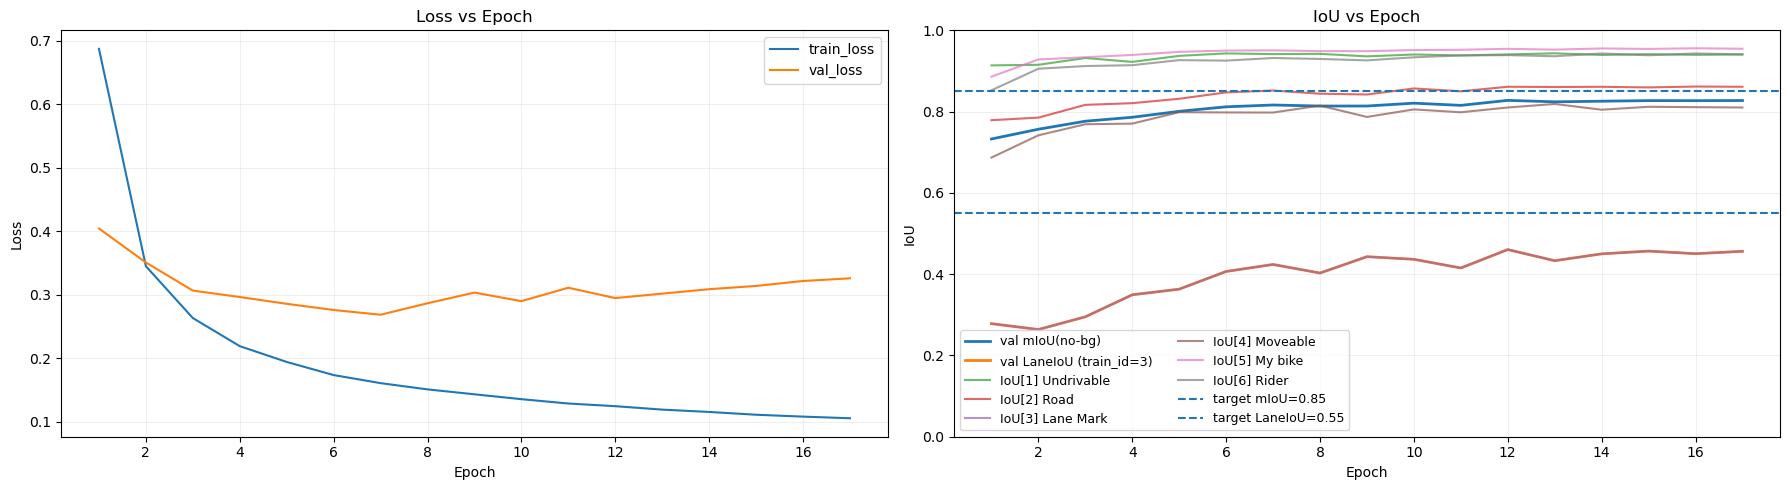

In [8]:
# =========================
# [정칙화 변경 내용]
# 1) WEIGHT_DECAY: 1e-4 -> 3e-4  (가장 안전하고 효과적인 정칙화 강화)
# 2) (선택) Backbone freeze warmup 1~2 epoch (기본 OFF)  # 필요하면 켜세요
# Baseline DeepLabV3+ResNet50 
# =========================

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# ---------- config ----------
EPOCHS = 30
PATIENCE = 5
LR = 3e-4

# ✅ 정칙화 강화: weight decay 증가
WEIGHT_DECAY = 3e-4   # (기존 1e-4 -> 3e-4)

LABEL_SMOOTH = 0.0
BEST_PATH = "best_deeplabv3_r50_baseline_2.pt"

# mIoU 계산/출력에서 background 제외
IGNORE_BG = True
PRINT_BG_IOU = False

# ✅ 목표선(원하는 값으로 수정)
TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55

# Lane Mark train_id (당신 매핑 기준: 3)
LANE_TRAIN_ID = 3

# (선택) backbone warmup freeze: 초반 과적합 줄이는 데 도움될 때 있음
FREEZE_BACKBONE_WARMUP_EPOCHS = 0  # 0이면 OFF, 1~2 추천(원하면 켜세요)

device = torch.device(DEVICE)

# ---------- class name map (train_id -> name) ----------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i+1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# ---------- model ----------
model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model.to(device)

# ---------- loss ----------
use_class_weight = True
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

# ---------- optim / sched ----------
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# ---------- metrics ----------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount(
        (num_classes * target[k] + pred[k]).to(torch.int64),
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)["out"]
        loss = criterion(out, y)
        total_loss += loss.item()
        n += 1

        pred = out.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)

    hist = hist.float()
    diag = torch.diag(hist)
    denom = (hist.sum(1) + hist.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()

    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    return total_loss / max(n, 1), miou, iou

def set_backbone_trainable(model, trainable: bool):
    for p in model.backbone.parameters():
        p.requires_grad = trainable

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    n = 0
    for x, y in tqdm(loader, desc="train", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)["out"]
        loss = criterion(out, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 안정화(그대로)
        optimizer.step()

        total_loss += loss.item()
        n += 1
    return total_loss / max(n, 1)

# ---------- history ----------
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "val_iou_per_class": [],
}

# ---------- training loop ----------
best_miou = -1.0
best_epoch = 0
pat = 0

print(f"DEVICE={DEVICE} | NUM_CLASSES={NUM_CLASSES} | IGNORE_BG_IN_mIoU={IGNORE_BG} | PATIENCE={PATIENCE}")
print(f"Regularization change: WEIGHT_DECAY=3e-4 (was 1e-4)")
if FREEZE_BACKBONE_WARMUP_EPOCHS > 0:
    print(f"Backbone warmup freeze: first {FREEZE_BACKBONE_WARMUP_EPOCHS} epoch(s)")
print(f"Targets: mIoU>={TARGET_MIOU}, LaneIoU>={TARGET_LANE_IOU} (Lane train_id={LANE_TRAIN_ID})")
print(f"Save best to: {BEST_PATH}\n")

for epoch in range(1, EPOCHS + 1):
    if FREEZE_BACKBONE_WARMUP_EPOCHS > 0:
        set_backbone_trainable(model, trainable=(epoch > FREEZE_BACKBONE_WARMUP_EPOCHS))

    tr_loss = train_one_epoch(model, train_loader)
    va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
    scheduler.step()

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["val_iou_per_class"].append(va_iou_pc)

    lane_iou = float(va_iou_pc[LANE_TRAIN_ID])
    tag = "no-bg" if IGNORE_BG else "with-bg"
    print(f"[{epoch:02d}] train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | val_mIoU({tag})={va_miou:.4f} | laneIoU={lane_iou:.4f}")

    start_cid = 0 if PRINT_BG_IOU else 1
    for cid in range(start_cid, NUM_CLASSES):
        name = train2name.get(cid, str(cid))
        v = va_iou_pc[cid]
        txt = "nan" if np.isnan(v) else f"{v:.4f}"
        print(f"  IoU[{cid}] {name}: {txt}")

    improved = va_miou > best_miou + 1e-7
    if improved:
        best_miou = va_miou
        best_epoch = epoch
        pat = 0
        torch.save({"model": model.state_dict(), "id2train": id2train, "num_classes": NUM_CLASSES}, BEST_PATH)
        print(f"  ✅ improved! best_mIoU={best_miou:.4f} @ epoch {best_epoch} | patience {pat}/{PATIENCE} | saved\n")
    else:
        pat += 1
        remain = PATIENCE - pat
        print(f"  ❌ no improve | best_mIoU={best_miou:.4f} @ epoch {best_epoch} | patience {pat}/{PATIENCE} (remain {max(remain,0)})\n")
        if pat >= PATIENCE:
            print("Early stopping triggered.")
            break

print(f"Best val mIoU({ 'no-bg' if IGNORE_BG else 'with-bg' }): {best_miou:.6f} (epoch {best_epoch})")

# ---------- load best + final val report ----------
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou_best = float(va_iou_pc[LANE_TRAIN_ID])

print("\n[Best Model @ VAL]")
print(f"val_loss={va_loss:.4f} | val_mIoU({ 'no-bg' if IGNORE_BG else 'with-bg' })={va_miou:.4f} | laneIoU={lane_iou_best:.4f}")

start_cid = 0 if PRINT_BG_IOU else 1
for cid in range(start_cid, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = va_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# =========================
# Visualization: SIDE-BY-SIDE (좌우 배치)
# =========================

epochs = np.array(history["epoch"])
train_loss = np.array(history["train_loss"])
val_loss_arr = np.array(history["val_loss"])
val_miou_hist = np.array(history["val_miou"])
val_iou_stack = np.stack(history["val_iou_per_class"], axis=0)
lane_iou_hist = val_iou_stack[:, LANE_TRAIN_ID]

# 👉 좌우 subplot
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# =================
# (좌) Loss Plot
# =================
axes[0].plot(epochs, train_loss, label="train_loss")
axes[0].plot(epochs, val_loss_arr, label="val_loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Epoch")
axes[0].grid(True, alpha=0.2)
axes[0].legend()

# =================
# (우) IoU Plot
# =================
axes[1].plot(
    epochs,
    val_miou_hist,
    linewidth=2,
    label=("val mIoU(no-bg)" if IGNORE_BG else "val mIoU")
)

axes[1].plot(
    epochs,
    lane_iou_hist,
    linewidth=2,
    label=f"val LaneIoU (train_id={LANE_TRAIN_ID})"
)

for cid in range(1, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    axes[1].plot(
        epochs,
        val_iou_stack[:, cid],
        alpha=0.7,
        label=f"IoU[{cid}] {name}"
    )

axes[1].axhline(TARGET_MIOU, linestyle="--", linewidth=1.5,
                label=f"target mIoU={TARGET_MIOU}")

axes[1].axhline(TARGET_LANE_IOU, linestyle="--", linewidth=1.5,
                label=f"target LaneIoU={TARGET_LANE_IOU}")

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("IoU")
axes[1].set_title("IoU vs Epoch")
axes[1].set_ylim(0.0, 1.0)
axes[1].grid(True, alpha=0.2)
axes[1].legend(ncol=2, fontsize=9)

plt.tight_layout()
plt.show()

test:   0%|          | 0/5 [00:00<?, ?it/s]

[TEST] loss=0.3597 | mIoU(no-bg)=0.8104 | laneIoU(train_id=3)=0.4873
Targets: mIoU>=0.85, LaneIoU>=0.55
  IoU[1] Undrivable: 0.9419
  IoU[2] Road: 0.8582
  IoU[3] Lane Mark: 0.4873
  IoU[4] Moveable: 0.6892
  IoU[5] My bike: 0.9522
  IoU[6] Rider: 0.9336


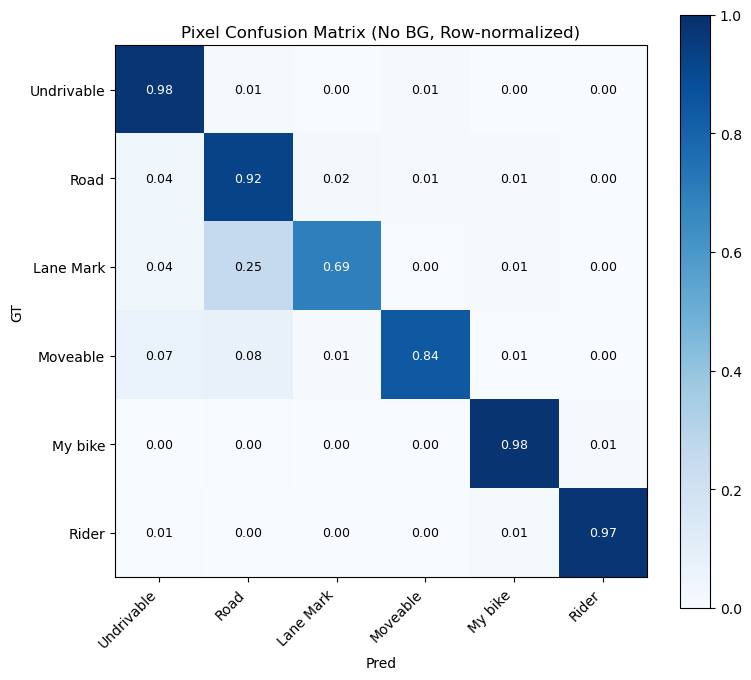

In [9]:
# 정칙화 중심 모델 평가   =========================
# - loads BEST_PATH
# - computes: test_loss, test_mIoU(no-bg), laneIoU, per-class IoU (1..NUM_CLASSES-1)
# - (optional) pixel confusion matrix summary
# =========================

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# ---------- config ----------
BEST_PATH = "best_deeplabv3_r50_baseline_2.pt" # 6가지 정칙화 적용 모델

IGNORE_BG = True
PRINT_BG_IOU = False

LANE_TRAIN_ID = 3
TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55

# class weight/label smoothing은 "평가 loss" 계산용(학습과 동일 세팅 권장)
LABEL_SMOOTH = 0.0
use_class_weight = True
w = class_weights.to(DEVICE) if ("class_weights" in globals() and use_class_weight) else None

device = torch.device(DEVICE)

# ---------- class name map (train_id -> name) ----------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i+1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# ---------- model (same structure) ----------
model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model.to(device)

# ---------- load best ----------
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

# ---------- loss (for reporting) ----------
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

# ---------- metrics ----------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount(
        (num_classes * target[k] + pred[k]).to(torch.int64),
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate_test(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0

    for x, y in tqdm(loader, desc="test", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)["out"]  # (B,C,H,W)
        loss = criterion(out, y)
        total_loss += loss.item()
        n += 1

        pred = out.argmax(dim=1)  # (B,H,W)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)

    hist_f = hist.float()
    diag = torch.diag(hist_f)
    denom = (hist_f.sum(1) + hist_f.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()

    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    avg_loss = total_loss / max(n, 1)

    return avg_loss, miou, iou, hist.cpu().numpy()

# ---------- run test ----------
test_loss, test_miou, test_iou_pc, test_hist = evaluate_test(model, test_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou = float(test_iou_pc[LANE_TRAIN_ID])

tag = "no-bg" if IGNORE_BG else "with-bg"
print(f"[TEST] loss={test_loss:.4f} | mIoU({tag})={test_miou:.4f} | laneIoU(train_id={LANE_TRAIN_ID})={lane_iou:.4f}")
print(f"Targets: mIoU>={TARGET_MIOU}, LaneIoU>={TARGET_LANE_IOU}")

start_cid = 0 if PRINT_BG_IOU else 1
for cid in range(start_cid, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = test_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# =========================
# Confusion Matrix (Background 제거 → 6x6, 정규화 + 클래스 이름 표시)
# =========================

import numpy as np
import matplotlib.pyplot as plt

# background 제거
cm_no_bg = test_hist[1:, 1:].astype(np.float32)

# ✅ 행 기준 정규화 (GT 기준)
row_sum = cm_no_bg.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_no_bg, row_sum, where=row_sum != 0)

# ✅ 클래스 이름 추출 (1~NUM_CLASSES-1)
class_names = [train2name.get(i, str(i)) for i in range(1, NUM_CLASSES)]

plt.figure(figsize=(8, 7))
plt.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)

plt.title("Pixel Confusion Matrix (No BG, Row-normalized)")
plt.xlabel("Pred")
plt.ylabel("GT")

# ---------- 숫자 표시 ----------
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(
            j, i, f"{cm_norm[i,j]:.2f}",
            ha="center",
            va="center",
            color="white" if cm_norm[i,j] > 0.5 else "black",
            fontsize=9
        )

# ---------- 클래스 이름 적용 ----------
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

plt.colorbar()
plt.tight_layout()
plt.show()

## 3-2 DeepLabV3 + Lane Embedding Regularization
### (Multi-Head Segmentation Model) - LANE 보조헤드 추가(laneNet)

DEVICE=cuda | NUM_CLASSES=7 | IGNORE_BG_IN_mIoU=True | PATIENCE=5
LR=0.0003 | WD=0.0003 | label_smooth=0.0
LaneBoost: weight_x2.0 | Dice beta=0.3 | Emb lambda=0.02
EarlyStop score = mIoU + 0.5*laneIoU
Targets: mIoU>=0.85, LaneIoU>=0.55 (Lane id=3)
Save best to: best_deeplabv3_r50_laneemb_laneDice.pt



train:   0%|          | 0/40 [00:00<?, ?it/s]

[01] score=0.8455 | train=1.0463 (ce=0.7755, dice=0.9008, emb=0.0295) | val_loss=0.4351 | val_mIoU(no-bg)=0.7185 | laneIoU=0.2540
  IoU[1] Undrivable: 0.8970
  IoU[2] Road: 0.7467
  IoU[3] Lane Mark: 0.2540
  IoU[4] Moveable: 0.6492
  IoU[5] My bike: 0.8952
  IoU[6] Rider: 0.8686
  ✅ improved! best_score=0.8455 (mIoU=0.7185) @ epoch 1 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[02] score=0.9147 | train=0.5981 (ce=0.3790, dice=0.7302, emb=0.0021) | val_loss=0.4220 | val_mIoU(no-bg)=0.7452 | laneIoU=0.3390
  IoU[1] Undrivable: 0.9046
  IoU[2] Road: 0.7706
  IoU[3] Lane Mark: 0.3390
  IoU[4] Moveable: 0.6688
  IoU[5] My bike: 0.9184
  IoU[6] Rider: 0.8700
  ✅ improved! best_score=0.9147 (mIoU=0.7452) @ epoch 2 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[03] score=0.9511 | train=0.4622 (ce=0.2835, dice=0.5957, emb=0.0015) | val_loss=0.4168 | val_mIoU(no-bg)=0.7752 | laneIoU=0.3518
  IoU[1] Undrivable: 0.9284
  IoU[2] Road: 0.8170
  IoU[3] Lane Mark: 0.3518
  IoU[4] Moveable: 0.7244
  IoU[5] My bike: 0.9282
  IoU[6] Rider: 0.9017
  ✅ improved! best_score=0.9511 (mIoU=0.7752) @ epoch 3 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[04] score=1.0025 | train=0.3910 (ce=0.2378, dice=0.5108, emb=0.0006) | val_loss=0.3733 | val_mIoU(no-bg)=0.7978 | laneIoU=0.4093
  IoU[1] Undrivable: 0.9282
  IoU[2] Road: 0.8296
  IoU[3] Lane Mark: 0.4093
  IoU[4] Moveable: 0.7715
  IoU[5] My bike: 0.9357
  IoU[6] Rider: 0.9126
  ✅ improved! best_score=1.0025 (mIoU=0.7978) @ epoch 4 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[05] score=1.0168 | train=0.3393 (ce=0.2055, dice=0.4460, emb=0.0006) | val_loss=0.3592 | val_mIoU(no-bg)=0.8055 | laneIoU=0.4227
  IoU[1] Undrivable: 0.9351
  IoU[2] Road: 0.8454
  IoU[3] Lane Mark: 0.4227
  IoU[4] Moveable: 0.7761
  IoU[5] My bike: 0.9442
  IoU[6] Rider: 0.9093
  ✅ improved! best_score=1.0168 (mIoU=0.8055) @ epoch 5 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[06] score=1.0385 | train=0.3131 (ce=0.1895, dice=0.4118, emb=0.0006) | val_loss=0.3663 | val_mIoU(no-bg)=0.8149 | laneIoU=0.4473
  IoU[1] Undrivable: 0.9352
  IoU[2] Road: 0.8498
  IoU[3] Lane Mark: 0.4473
  IoU[4] Moveable: 0.7873
  IoU[5] My bike: 0.9467
  IoU[6] Rider: 0.9232
  ✅ improved! best_score=1.0385 (mIoU=0.8149) @ epoch 6 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[07] score=1.0493 | train=0.2881 (ce=0.1731, dice=0.3834, emb=0.0004) | val_loss=0.3934 | val_mIoU(no-bg)=0.8197 | laneIoU=0.4591
  IoU[1] Undrivable: 0.9363
  IoU[2] Road: 0.8561
  IoU[3] Lane Mark: 0.4591
  IoU[4] Moveable: 0.7876
  IoU[5] My bike: 0.9504
  IoU[6] Rider: 0.9288
  ✅ improved! best_score=1.0493 (mIoU=0.8197) @ epoch 7 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[08] score=1.0561 | train=0.2688 (ce=0.1610, dice=0.3593, emb=0.0004) | val_loss=0.3900 | val_mIoU(no-bg)=0.8221 | laneIoU=0.4680
  IoU[1] Undrivable: 0.9378
  IoU[2] Road: 0.8611
  IoU[3] Lane Mark: 0.4680
  IoU[4] Moveable: 0.7839
  IoU[5] My bike: 0.9494
  IoU[6] Rider: 0.9325
  ✅ improved! best_score=1.0561 (mIoU=0.8221) @ epoch 8 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[09] score=1.0542 | train=0.2555 (ce=0.1532, dice=0.3411, emb=0.0003) | val_loss=0.4228 | val_mIoU(no-bg)=0.8197 | laneIoU=0.4690
  IoU[1] Undrivable: 0.9386
  IoU[2] Road: 0.8577
  IoU[3] Lane Mark: 0.4690
  IoU[4] Moveable: 0.7689
  IoU[5] My bike: 0.9498
  IoU[6] Rider: 0.9341
  ❌ no improve | best_score=1.0561 @ epoch 8 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[10] score=1.0620 | train=0.2415 (ce=0.1434, dice=0.3270, emb=0.0002) | val_loss=0.4041 | val_mIoU(no-bg)=0.8265 | laneIoU=0.4710
  IoU[1] Undrivable: 0.9401
  IoU[2] Road: 0.8629
  IoU[3] Lane Mark: 0.4710
  IoU[4] Moveable: 0.8008
  IoU[5] My bike: 0.9515
  IoU[6] Rider: 0.9327
  ✅ improved! best_score=1.0620 (mIoU=0.8265) @ epoch 10 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[11] score=1.0701 | train=0.2320 (ce=0.1378, dice=0.3138, emb=0.0002) | val_loss=0.4228 | val_mIoU(no-bg)=0.8290 | laneIoU=0.4821
  IoU[1] Undrivable: 0.9390
  IoU[2] Road: 0.8642
  IoU[3] Lane Mark: 0.4821
  IoU[4] Moveable: 0.8034
  IoU[5] My bike: 0.9516
  IoU[6] Rider: 0.9339
  ✅ improved! best_score=1.0701 (mIoU=0.8290) @ epoch 11 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[12] score=1.0706 | train=0.2253 (ce=0.1335, dice=0.3058, emb=0.0002) | val_loss=0.4323 | val_mIoU(no-bg)=0.8286 | laneIoU=0.4842
  IoU[1] Undrivable: 0.9383
  IoU[2] Road: 0.8609
  IoU[3] Lane Mark: 0.4842
  IoU[4] Moveable: 0.8002
  IoU[5] My bike: 0.9514
  IoU[6] Rider: 0.9364
  ✅ improved! best_score=1.0706 (mIoU=0.8286) @ epoch 12 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[13] score=1.0696 | train=0.2176 (ce=0.1281, dice=0.2983, emb=0.0004) | val_loss=0.4424 | val_mIoU(no-bg)=0.8284 | laneIoU=0.4823
  IoU[1] Undrivable: 0.9393
  IoU[2] Road: 0.8635
  IoU[3] Lane Mark: 0.4823
  IoU[4] Moveable: 0.7992
  IoU[5] My bike: 0.9522
  IoU[6] Rider: 0.9340
  ❌ no improve | best_score=1.0706 @ epoch 12 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[14] score=1.0707 | train=0.2116 (ce=0.1249, dice=0.2891, emb=0.0002) | val_loss=0.4407 | val_mIoU(no-bg)=0.8301 | laneIoU=0.4813
  IoU[1] Undrivable: 0.9411
  IoU[2] Road: 0.8678
  IoU[3] Lane Mark: 0.4813
  IoU[4] Moveable: 0.8039
  IoU[5] My bike: 0.9529
  IoU[6] Rider: 0.9333
  ✅ improved! best_score=1.0707 (mIoU=0.8301) @ epoch 14 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[15] score=1.0753 | train=0.2069 (ce=0.1223, dice=0.2819, emb=0.0002) | val_loss=0.4636 | val_mIoU(no-bg)=0.8308 | laneIoU=0.4889
  IoU[1] Undrivable: 0.9411
  IoU[2] Road: 0.8693
  IoU[3] Lane Mark: 0.4889
  IoU[4] Moveable: 0.7950
  IoU[5] My bike: 0.9521
  IoU[6] Rider: 0.9383
  ✅ improved! best_score=1.0753 (mIoU=0.8308) @ epoch 15 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[16] score=1.0660 | train=0.2009 (ce=0.1192, dice=0.2724, emb=0.0001) | val_loss=0.4436 | val_mIoU(no-bg)=0.8277 | laneIoU=0.4766
  IoU[1] Undrivable: 0.9395
  IoU[2] Road: 0.8639
  IoU[3] Lane Mark: 0.4766
  IoU[4] Moveable: 0.7966
  IoU[5] My bike: 0.9520
  IoU[6] Rider: 0.9376
  ❌ no improve | best_score=1.0753 @ epoch 15 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[17] score=1.0760 | train=0.1965 (ce=0.1168, dice=0.2656, emb=0.0001) | val_loss=0.4603 | val_mIoU(no-bg)=0.8310 | laneIoU=0.4901
  IoU[1] Undrivable: 0.9394
  IoU[2] Road: 0.8666
  IoU[3] Lane Mark: 0.4901
  IoU[4] Moveable: 0.7970
  IoU[5] My bike: 0.9532
  IoU[6] Rider: 0.9396
  ✅ improved! best_score=1.0760 (mIoU=0.8310) @ epoch 17 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[18] score=1.0718 | train=0.1923 (ce=0.1151, dice=0.2573, emb=0.0001) | val_loss=0.4675 | val_mIoU(no-bg)=0.8293 | laneIoU=0.4850
  IoU[1] Undrivable: 0.9391
  IoU[2] Road: 0.8665
  IoU[3] Lane Mark: 0.4850
  IoU[4] Moveable: 0.7927
  IoU[5] My bike: 0.9524
  IoU[6] Rider: 0.9403
  ❌ no improve | best_score=1.0760 @ epoch 17 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[19] score=1.0781 | train=0.1871 (ce=0.1117, dice=0.2513, emb=0.0002) | val_loss=0.4622 | val_mIoU(no-bg)=0.8317 | laneIoU=0.4928
  IoU[1] Undrivable: 0.9389
  IoU[2] Road: 0.8672
  IoU[3] Lane Mark: 0.4928
  IoU[4] Moveable: 0.7960
  IoU[5] My bike: 0.9532
  IoU[6] Rider: 0.9419
  ✅ improved! best_score=1.0781 (mIoU=0.8317) @ epoch 19 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[20] score=1.0737 | train=0.1839 (ce=0.1091, dice=0.2493, emb=0.0003) | val_loss=0.4875 | val_mIoU(no-bg)=0.8304 | laneIoU=0.4866
  IoU[1] Undrivable: 0.9390
  IoU[2] Road: 0.8660
  IoU[3] Lane Mark: 0.4866
  IoU[4] Moveable: 0.7970
  IoU[5] My bike: 0.9535
  IoU[6] Rider: 0.9402
  ❌ no improve | best_score=1.0781 @ epoch 19 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[21] score=1.0741 | train=0.1814 (ce=0.1079, dice=0.2451, emb=0.0002) | val_loss=0.4734 | val_mIoU(no-bg)=0.8300 | laneIoU=0.4882
  IoU[1] Undrivable: 0.9386
  IoU[2] Road: 0.8659
  IoU[3] Lane Mark: 0.4882
  IoU[4] Moveable: 0.7934
  IoU[5] My bike: 0.9529
  IoU[6] Rider: 0.9410
  ❌ no improve | best_score=1.0781 @ epoch 19 | patience 2/5 (remain 3)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[22] score=1.0755 | train=0.1793 (ce=0.1066, dice=0.2423, emb=0.0001) | val_loss=0.4728 | val_mIoU(no-bg)=0.8303 | laneIoU=0.4903
  IoU[1] Undrivable: 0.9387
  IoU[2] Road: 0.8658
  IoU[3] Lane Mark: 0.4903
  IoU[4] Moveable: 0.7923
  IoU[5] My bike: 0.9534
  IoU[6] Rider: 0.9415
  ❌ no improve | best_score=1.0781 @ epoch 19 | patience 3/5 (remain 2)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[23] score=1.0755 | train=0.1775 (ce=0.1053, dice=0.2406, emb=0.0001) | val_loss=0.4709 | val_mIoU(no-bg)=0.8312 | laneIoU=0.4886
  IoU[1] Undrivable: 0.9396
  IoU[2] Road: 0.8678
  IoU[3] Lane Mark: 0.4886
  IoU[4] Moveable: 0.7964
  IoU[5] My bike: 0.9535
  IoU[6] Rider: 0.9413
  ❌ no improve | best_score=1.0781 @ epoch 19 | patience 4/5 (remain 1)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[24] score=1.0767 | train=0.1753 (ce=0.1041, dice=0.2373, emb=0.0001) | val_loss=0.4830 | val_mIoU(no-bg)=0.8313 | laneIoU=0.4907
  IoU[1] Undrivable: 0.9388
  IoU[2] Road: 0.8674
  IoU[3] Lane Mark: 0.4907
  IoU[4] Moveable: 0.7956
  IoU[5] My bike: 0.9536
  IoU[6] Rider: 0.9418
  ❌ no improve | best_score=1.0781 @ epoch 19 | patience 5/5 (remain 0)

Early stopping triggered.
Best epoch=19 | best_score=1.078059 | best_mIoU=0.831671

[Best Model @ VAL]
val_loss=0.4622 | val_mIoU(no-bg)=0.8317 | laneIoU=0.4928 | score=1.0781
  IoU[1] Undrivable: 0.9389
  IoU[2] Road: 0.8672
  IoU[3] Lane Mark: 0.4928
  IoU[4] Moveable: 0.7960
  IoU[5] My bike: 0.9532
  IoU[6] Rider: 0.9419


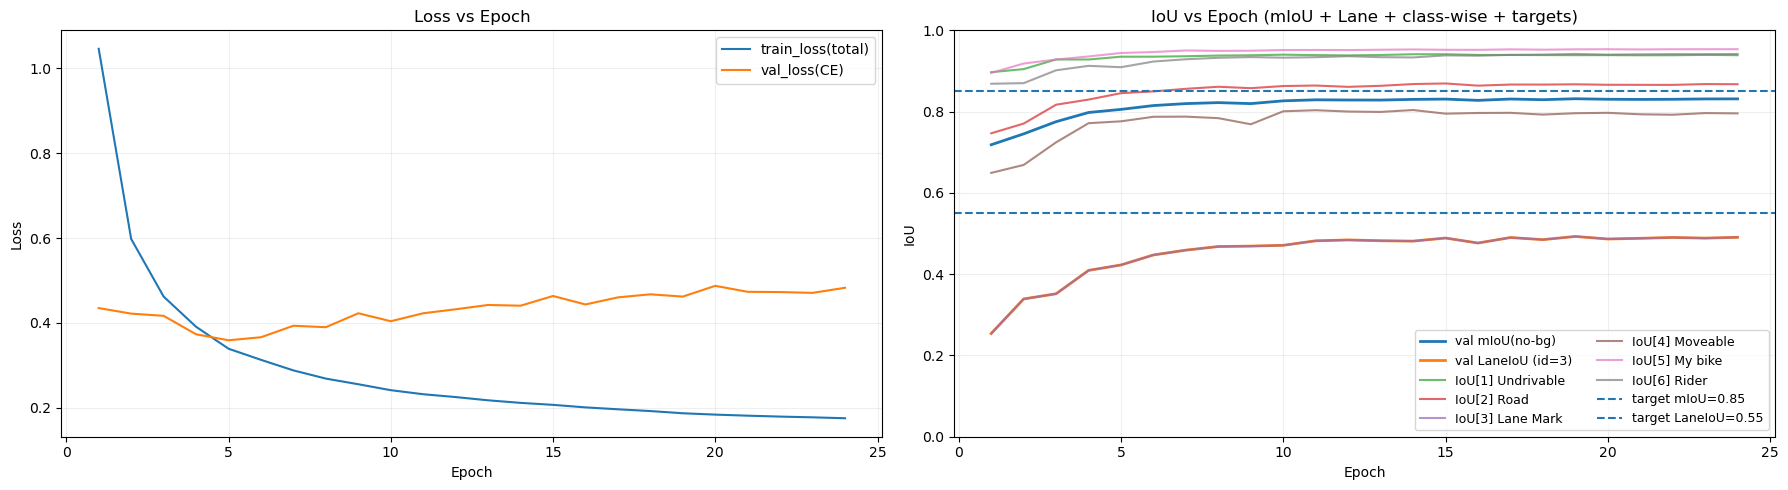

In [10]:
# =1차 실험 조건===================================================
# DeepLabV3+ResNet50 + Lane Embedding Head (Aux branch)
# - (1) Lane Embedding head 모델 ✅
# - (2) loss 연결(SEG + λ*EMB) ✅
# - (3) 기존 출력/가시화/early stopping(mIoU no-bg) 유지 ✅
#
# [정칙화/안전 장치]
# - WEIGHT_DECAY=3e-4 (기존 유지)
# - Lane Embedding loss는 "아주 약하게" 시작: LAMBDA_EMB=0.02 (망가지면 0.01/0.005)
# - Embedding loss는 lane 픽셀 적으면 batch skip
#
# [필수로 이미 존재해야 하는 것]
# - DEVICE (e.g., "cuda"), NUM_CLASSES=7
# - train_loader, val_loader
# - coco (선택: class name 매핑용)
# - id2train (저장용; 없으면 저장 dict에서 빠짐)
# - class_weights (선택: 이미 계산해둔 weight 재사용)
# ============================================================
# =2차 실험 조건===========================================================
# DeepLabV3+ResNet50 + Lane Embedding Head (Aux) + Lane Dice
# - EarlyStopping 점수: score = val_mIoU(no-bg) + ALPHA_LANE * laneIoU  ✅
# - class weight: lane만 BOOST (LANE_WEIGHT_BOOST) ✅
# - seg loss: CE + BETA_DICE * Dice(lane) ✅
# - emb loss: (기존) pull + 약한 push 유지 ✅
# - 출력/가시화(좌우 Loss/IoU) 유지 ✅
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# --------------------
# CONFIG
# --------------------
EPOCHS = 30
PATIENCE = 5

LR = 3e-4
WEIGHT_DECAY = 3e-4
LABEL_SMOOTH = 0.0

# Dice coefficient (다이스 계수)는 세그멘테이션 평가/손실 함수
# 얇고 픽셀이 적은 클래스(lane 같은) 를 살릴 때 매우 자주 쓰는 핵심 개념로 Overlap를 보는 지표로
# Dice는 IoU와 유사한 개념이자만, 작은 객체에 더 민감흠, 학습 안정성이 좋음
BEST_PATH = "best_deeplabv3_r50_laneemb_laneDice.pt"

IGNORE_BG = True
PRINT_BG_IOU = False

TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55
LANE_TRAIN_ID = 3

# ---- Lane Embedding branch ----
EMB_DIM = 4
LAMBDA_EMB = 0.02          # 안전 시작값
EMB_MARGIN = 1.0
EMB_MIN_PIXELS = 30        # lane 픽셀 적으면 emb loss skip

# ---- Lane Dice (Lane 얇은 클래스에 특효) ----
BETA_DICE = 0.3            # 0.2~0.5 권장 (lane만 적용)
DICE_SMOOTH = 1.0

# ---- class weight lane boost (가장 쉬운 개선) ----
LANE_WEIGHT_BOOST = 2.0    # 1.5~2.5 권장

# ---- EarlyStopping score = mIoU + alpha*laneIoU (lane를 반영) ----
ALPHA_LANE = 0.5           # 0.3~0.7 권장

# (선택) backbone warmup freeze
FREEZE_BACKBONE_WARMUP_EPOCHS = 0

device = torch.device(DEVICE)

# --------------------
# CLASS NAME MAP
# --------------------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i + 1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# --------------------
# MODEL: DeepLabV3 + Lane Embedding Head
# --------------------
class DeepLabV3_WithLaneEmbedding(nn.Module):
    """
    out["seg"]: (B, num_classes, H, W)
    out["emb"]: (B, emb_dim, H, W)
    """
    def __init__(self, num_classes: int, emb_dim: int = 4, backbone_pretrained=True, dropout_p=0.1):
        super().__init__()
        self.base = deeplabv3_resnet50(
            weights=None,
            weights_backbone="DEFAULT" if backbone_pretrained else None
        )

        # DeepLabHead는 nn.Sequential subclass라 slicing이 꼬일 수 있음 → children으로 재구성
        cls_children = list(self.base.classifier.children())
        self.feat_extractor = nn.Sequential(*cls_children[:-1])  # -> (B,256,h,w)

        last = cls_children[-1]
        in_ch = getattr(last, "in_channels", 256)
        self.seg_head = nn.Conv2d(in_ch, num_classes, kernel_size=1)
        self.base.classifier = nn.Sequential(*cls_children[:-1], self.seg_head)

        self.embed_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_p),
            nn.Conv2d(256, emb_dim, 1),
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        feats = self.base.backbone(x)
        x_out = feats["out"]                         # (B,C,h,w)

        feat256 = self.feat_extractor(x_out)         # (B,256,h,w)
        seg = self.seg_head(feat256)                 # (B,num_classes,h,w)
        emb = self.embed_head(feat256)               # (B,emb_dim,h,w)

        seg = F.interpolate(seg, size=input_shape, mode="bilinear", align_corners=False)
        emb = F.interpolate(emb, size=input_shape, mode="bilinear", align_corners=False)
        return {"seg": seg, "emb": emb}

# --------------------
# LOSS: Embedding regularization (안전 버전)
# --------------------
def lane_embedding_loss_simple(emb, y, lane_id: int, margin: float = 1.0, min_pixels: int = 30):
    """
    - pull: lane 픽셀 임베딩을 lane_mean으로 응집
    - push: lane_mean과 non_mean이 margin 이상 떨어지도록(약하게)
    """
    B, D, H, W = emb.shape
    emb_hw = emb.permute(0, 2, 3, 1).contiguous().view(B, H * W, D)
    y_hw = y.view(B, H * W)

    total = emb.new_tensor(0.0)
    cnt = 0

    for b in range(B):
        lane_mask = (y_hw[b] == lane_id)
        non_mask = ~lane_mask

        if lane_mask.sum() < min_pixels or non_mask.sum() < min_pixels:
            continue

        lane_emb = emb_hw[b][lane_mask]
        non_emb = emb_hw[b][non_mask]

        lane_mean = lane_emb.mean(dim=0, keepdim=True)
        non_mean = non_emb.mean(dim=0, keepdim=True)

        pull = F.mse_loss(lane_emb, lane_mean.expand_as(lane_emb))
        dist = torch.norm(lane_mean - non_mean, p=2)
        push = F.relu(margin - dist)

        total = total + (pull + 0.1 * push)
        cnt += 1

    if cnt == 0:
        return emb.new_tensor(0.0)
    return total / cnt

# --------------------
# LOSS: Lane Dice (lane class만)
# --------------------
def lane_dice_loss(seg_logits, y, lane_id: int, smooth: float = 1.0):
    """
    seg_logits: (B,C,H,W)
    y        : (B,H,W)
    -> lane class에 대해서만 soft dice loss
    """
    probs = torch.softmax(seg_logits, dim=1)[:, lane_id, :, :]  # (B,H,W)
    gt = (y == lane_id).float()                                 # (B,H,W)

    # flatten
    probs = probs.reshape(probs.size(0), -1)
    gt = gt.reshape(gt.size(0), -1)

    inter = (probs * gt).sum(dim=1)
    denom = probs.sum(dim=1) + gt.sum(dim=1)

    dice = (2.0 * inter + smooth) / (denom + smooth)
    return 1.0 - dice.mean()

# --------------------
# CRITERION (CE) + lane weight boost
# --------------------
use_class_weight = True
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
if w is not None:
    w = w.clone()
    if 0 <= LANE_TRAIN_ID < len(w):
        w[LANE_TRAIN_ID] = w[LANE_TRAIN_ID] * LANE_WEIGHT_BOOST

criterion_ce = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

def total_loss_fn(out, y):
    seg_logits = out["seg"]
    emb = out["emb"]

    loss_ce = criterion_ce(seg_logits, y)
    loss_dice = lane_dice_loss(seg_logits, y, lane_id=LANE_TRAIN_ID, smooth=DICE_SMOOTH)
    loss_emb = lane_embedding_loss_simple(emb, y, lane_id=LANE_TRAIN_ID, margin=EMB_MARGIN, min_pixels=EMB_MIN_PIXELS)

    loss_total = loss_ce + BETA_DICE * loss_dice + LAMBDA_EMB * loss_emb
    return loss_total, loss_ce.detach(), loss_dice.detach(), loss_emb.detach()

# --------------------
# OPT / SCHED
# --------------------
model = DeepLabV3_WithLaneEmbedding(NUM_CLASSES, EMB_DIM, backbone_pretrained=True, dropout_p=0.1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

def set_backbone_trainable(model, trainable: bool):
    for p in model.base.backbone.parameters():
        p.requires_grad = trainable

# --------------------
# METRICS
# --------------------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount(
        (num_classes * target[k] + pred[k]).to(torch.int64),
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        seg_logits = model(x)["seg"]
        loss = criterion_ce(seg_logits, y)  # val loss는 seg만(기존 유지)
        total_loss += float(loss.item())
        n += 1

        pred = seg_logits.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)

    hist = hist.float()
    diag = torch.diag(hist)
    denom = (hist.sum(1) + hist.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()

    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    return total_loss / max(n, 1), miou, iou

def train_one_epoch(model, loader):
    model.train()
    total = 0.0
    ce_sum = 0.0
    dice_sum = 0.0
    emb_sum = 0.0
    n = 0

    for x, y in tqdm(loader, desc="train", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)
        loss_total, loss_ce, loss_dice, loss_emb = total_loss_fn(out, y)

        optimizer.zero_grad(set_to_none=True)
        loss_total.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total += float(loss_total.item())
        ce_sum += float(loss_ce.item())
        dice_sum += float(loss_dice.item())
        emb_sum += float(loss_emb.item())
        n += 1

    return total / max(n, 1), ce_sum / max(n, 1), dice_sum / max(n, 1), emb_sum / max(n, 1)

# --------------------
# HISTORY
# --------------------
history = {
    "epoch": [],
    "train_total": [],
    "train_ce": [],
    "train_dice": [],
    "train_emb": [],
    "val_loss": [],
    "val_miou": [],
    "val_iou_per_class": [],
    "val_score": [],
}

# --------------------
# TRAIN LOOP (EarlyStopping: score = mIoU + alpha*lane)
# --------------------
best_score = -1e9
best_epoch = 0
best_miou = -1.0
pat = 0

print(f"DEVICE={DEVICE} | NUM_CLASSES={NUM_CLASSES} | IGNORE_BG_IN_mIoU={IGNORE_BG} | PATIENCE={PATIENCE}")
print(f"LR={LR} | WD={WEIGHT_DECAY} | label_smooth={LABEL_SMOOTH}")
print(f"LaneBoost: weight_x{LANE_WEIGHT_BOOST} | Dice beta={BETA_DICE} | Emb lambda={LAMBDA_EMB}")
print(f"EarlyStop score = mIoU + {ALPHA_LANE}*laneIoU")
print(f"Targets: mIoU>={TARGET_MIOU}, LaneIoU>={TARGET_LANE_IOU} (Lane id={LANE_TRAIN_ID})")
print(f"Save best to: {BEST_PATH}\n")

for epoch in range(1, EPOCHS + 1):
    if FREEZE_BACKBONE_WARMUP_EPOCHS > 0:
        set_backbone_trainable(model, trainable=(epoch > FREEZE_BACKBONE_WARMUP_EPOCHS))

    tr_total, tr_ce, tr_dice, tr_emb = train_one_epoch(model, train_loader)
    va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
    scheduler.step()

    lane_iou = float(va_iou_pc[LANE_TRAIN_ID])
    va_score = float(va_miou + ALPHA_LANE * lane_iou)

    history["epoch"].append(epoch)
    history["train_total"].append(tr_total)
    history["train_ce"].append(tr_ce)
    history["train_dice"].append(tr_dice)
    history["train_emb"].append(tr_emb)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["val_iou_per_class"].append(va_iou_pc)
    history["val_score"].append(va_score)

    tag = "no-bg" if IGNORE_BG else "with-bg"
    print(f"[{epoch:02d}] score={va_score:.4f} | train={tr_total:.4f} (ce={tr_ce:.4f}, dice={tr_dice:.4f}, emb={tr_emb:.4f}) "
          f"| val_loss={va_loss:.4f} | val_mIoU({tag})={va_miou:.4f} | laneIoU={lane_iou:.4f}")

    start_cid = 0 if PRINT_BG_IOU else 1
    for cid in range(start_cid, NUM_CLASSES):
        name = train2name.get(cid, str(cid))
        v = va_iou_pc[cid]
        txt = "nan" if np.isnan(v) else f"{v:.4f}"
        print(f"  IoU[{cid}] {name}: {txt}")

    improved = va_score > best_score + 1e-7
    if improved:
        best_score = va_score
        best_epoch = epoch
        best_miou = va_miou
        pat = 0
        save_dict = {"model": model.state_dict(), "num_classes": NUM_CLASSES}
        if "id2train" in globals():
            save_dict["id2train"] = id2train
        torch.save(save_dict, BEST_PATH)
        print(f"  ✅ improved! best_score={best_score:.4f} (mIoU={best_miou:.4f}) @ epoch {best_epoch} | patience {pat}/{PATIENCE} | saved\n")
    else:
        pat += 1
        remain = PATIENCE - pat
        print(f"  ❌ no improve | best_score={best_score:.4f} @ epoch {best_epoch} | patience {pat}/{PATIENCE} (remain {max(remain,0)})\n")
        if pat >= PATIENCE:
            print("Early stopping triggered.")
            break

print(f"Best epoch={best_epoch} | best_score={best_score:.6f} | best_mIoU={best_miou:.6f}")

# --------------------
# LOAD BEST + FINAL VAL REPORT
# --------------------
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou_best = float(va_iou_pc[LANE_TRAIN_ID])
va_score_best = float(va_miou + ALPHA_LANE * lane_iou_best)

print("\n[Best Model @ VAL]")
print(f"val_loss={va_loss:.4f} | val_mIoU({'no-bg' if IGNORE_BG else 'with-bg'})={va_miou:.4f} | laneIoU={lane_iou_best:.4f} | score={va_score_best:.4f}")

start_cid = 0 if PRINT_BG_IOU else 1
for cid in range(start_cid, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = va_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# --------------------
# VISUALIZATION: SIDE-BY-SIDE (Loss / IoU)
# --------------------
epochs = np.array(history["epoch"])
train_total = np.array(history["train_total"])
val_loss_arr = np.array(history["val_loss"])
val_miou_hist = np.array(history["val_miou"])
val_iou_stack = np.stack(history["val_iou_per_class"], axis=0)
lane_iou_hist = val_iou_stack[:, LANE_TRAIN_ID]

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# (좌) Loss
axes[0].plot(epochs, train_total, label="train_loss(total)")
axes[0].plot(epochs, val_loss_arr, label="val_loss(CE)")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Epoch")
axes[0].grid(True, alpha=0.2)
axes[0].legend()

# (우) IoU
axes[1].plot(epochs, val_miou_hist, linewidth=2, label=("val mIoU(no-bg)" if IGNORE_BG else "val mIoU"))
axes[1].plot(epochs, lane_iou_hist, linewidth=2, label=f"val LaneIoU (id={LANE_TRAIN_ID})")

for cid in range(1, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    axes[1].plot(epochs, val_iou_stack[:, cid], alpha=0.7, label=f"IoU[{cid}] {name}")

axes[1].axhline(TARGET_MIOU, linestyle="--", linewidth=1.5, label=f"target mIoU={TARGET_MIOU}")
axes[1].axhline(TARGET_LANE_IOU, linestyle="--", linewidth=1.5, label=f"target LaneIoU={TARGET_LANE_IOU}")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("IoU")
axes[1].set_title("IoU vs Epoch (mIoU + Lane + class-wise + targets)")
axes[1].set_ylim(0.0, 1.0)
axes[1].grid(True, alpha=0.2)
axes[1].legend(ncol=2, fontsize=9)

plt.tight_layout()
plt.show()

test:   0%|          | 0/5 [00:00<?, ?it/s]

[TEST] loss=0.4416 | mIoU(no-bg)=0.8149 | laneIoU(train_id=3)=0.4964
Targets: mIoU>=0.85, LaneIoU>=0.55
  IoU[1] Undrivable: 0.9441
  IoU[2] Road: 0.8624
  IoU[3] Lane Mark: 0.4964
  IoU[4] Moveable: 0.6971
  IoU[5] My bike: 0.9482
  IoU[6] Rider: 0.9413


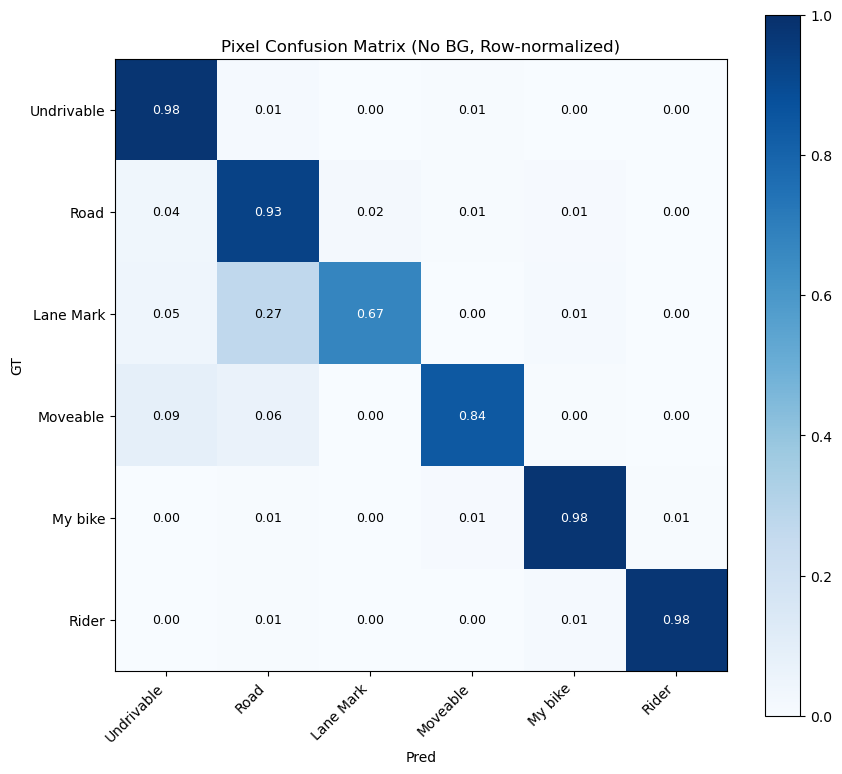

In [11]:
# ============================================================
# DeepLabV3+ResNet50 + Lane Embedding Head (Aux) + LaneDice 학습모델 평가
# - loads BEST_PATH
# - computes: test_loss(CE), test_mIoU(no-bg), laneIoU, per-class IoU
# - confusion matrix: no-bg(6x6), row-normalized + class names
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# ---------- config ----------
BEST_PATH = "best_deeplabv3_r50_laneemb_laneDice.pt"  # ✅ 학습 때 저장한 best로 바꾸세요

IGNORE_BG = True
PRINT_BG_IOU = False

LANE_TRAIN_ID = 3
TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55

LABEL_SMOOTH = 0.0
use_class_weight = True

device = torch.device(DEVICE)

# ---------- class name map (train_id -> name) ----------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i + 1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# ---------- model: DeepLabV3 + Lane Embedding ----------
class DeepLabV3_WithLaneEmbedding(nn.Module):
    """
    out["seg"]: (B, num_classes, H, W)
    out["emb"]: (B, emb_dim, H, W)  # 테스트에서는 emb는 사용 안 해도 됨
    """
    def __init__(self, num_classes: int, emb_dim: int = 4, backbone_pretrained=True, dropout_p=0.1):
        super().__init__()
        self.base = deeplabv3_resnet50(
            weights=None,
            weights_backbone="DEFAULT" if backbone_pretrained else None
        )

        cls_children = list(self.base.classifier.children())
        self.feat_extractor = nn.Sequential(*cls_children[:-1])  # -> (B,256,h,w)

        last = cls_children[-1]
        in_ch = getattr(last, "in_channels", 256)
        self.seg_head = nn.Conv2d(in_ch, num_classes, kernel_size=1)
        self.base.classifier = nn.Sequential(*cls_children[:-1], self.seg_head)

        self.embed_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_p),
            nn.Conv2d(256, emb_dim, 1),
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        feats = self.base.backbone(x)
        x_out = feats["out"]
        feat256 = self.feat_extractor(x_out)
        seg = self.seg_head(feat256)
        emb = self.embed_head(feat256)

        seg = F.interpolate(seg, size=input_shape, mode="bilinear", align_corners=False)
        emb = F.interpolate(emb, size=input_shape, mode="bilinear", align_corners=False)
        return {"seg": seg, "emb": emb}

# ---------- loss (for reporting) ----------
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

# ---------- load best ----------
ckpt = torch.load(BEST_PATH, map_location=device)

# emb_dim 추론(ckpt에 없으면 기본 4로)
EMB_DIM = int(ckpt.get("emb_dim", 4)) if isinstance(ckpt, dict) else 4

model = DeepLabV3_WithLaneEmbedding(
    num_classes=NUM_CLASSES,
    emb_dim=EMB_DIM,
    backbone_pretrained=True,
    dropout_p=0.1
).to(device)

# 저장 포맷 방어: {"model": state_dict} or state_dict 직접 저장
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state, strict=True)
model.eval()

# ---------- metrics ----------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount(
        (num_classes * target[k] + pred[k]).to(torch.int64),
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate_test(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0

    for x, y in tqdm(loader, desc="test", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)["seg"]  # ✅ 새 모델은 "seg"
        loss = criterion(out, y)
        total_loss += float(loss.item())
        n += 1

        pred = out.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)

    hist_f = hist.float()
    diag = torch.diag(hist_f)
    denom = (hist_f.sum(1) + hist_f.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()

    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    avg_loss = total_loss / max(n, 1)

    return avg_loss, miou, iou, hist.cpu().numpy()

# ---------- run test ----------
test_loss, test_miou, test_iou_pc, test_hist = evaluate_test(model, test_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou = float(test_iou_pc[LANE_TRAIN_ID])

tag = "no-bg" if IGNORE_BG else "with-bg"
print(f"[TEST] loss={test_loss:.4f} | mIoU({tag})={test_miou:.4f} | laneIoU(train_id={LANE_TRAIN_ID})={lane_iou:.4f}")
print(f"Targets: mIoU>={TARGET_MIOU}, LaneIoU>={TARGET_LANE_IOU}")

start_cid = 0 if PRINT_BG_IOU else 1
for cid in range(start_cid, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = test_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# ============================================================
# Confusion Matrix (No BG: (NUM_CLASSES-1)x(NUM_CLASSES-1))
# Row-normalized (GT 기준) + 클래스 이름 + 숫자 표시
# ============================================================

cm_no_bg = test_hist[1:, 1:].astype(np.float32)

row_sum = cm_no_bg.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_no_bg, row_sum, where=row_sum != 0)

class_names = [train2name.get(i, str(i)) for i in range(1, NUM_CLASSES)]

plt.figure(figsize=(9, 8))
plt.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)

plt.title("Pixel Confusion Matrix (No BG, Row-normalized)")
plt.xlabel("Pred")
plt.ylabel("GT")

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(
            j, i, f"{cm_norm[i, j]:.2f}",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > 0.5 else "black",
            fontsize=9
        )

plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

plt.colorbar()
plt.tight_layout()
plt.show()


DEVICE=cuda | NUM_CLASSES=7 | LR=0.0002 | WD=0.0003
LaneDice schedule: 0.2->0.4->0.6 @ ep 5/15
Score = mIoU + 0.5*LaneIoU | Lane id=3
Save best to: best_deeplabv3_r50_laneemb_laneDice_vnext.pt



train:   0%|          | 0/40 [00:00<?, ?it/s]

[01] lr=2.00e-04 | w_dice=0.20 | score=0.8363 | train=0.9341 (ce=0.7401, dice=0.9667, emb=0.0347) | val_loss=0.4358 | val_mIoU(no-bg)=0.7220 | laneIoU=0.2287
  IoU[1] Undrivable: 0.9103
  IoU[2] Road: 0.7533
  IoU[3] Lane Mark: 0.2287
  IoU[4] Moveable: 0.7160
  IoU[5] My bike: 0.8847
  IoU[6] Rider: 0.8389
  ✅ improved! best_score=0.8363 (mIoU=0.7220) @ epoch 1 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[02] lr=2.00e-04 | w_dice=0.20 | score=0.8977 | train=0.5555 (ce=0.3661, dice=0.9465, emb=0.0030) | val_loss=0.3651 | val_mIoU(no-bg)=0.7531 | laneIoU=0.2892
  IoU[1] Undrivable: 0.9202
  IoU[2] Road: 0.7924
  IoU[3] Lane Mark: 0.2892
  IoU[4] Moveable: 0.7128
  IoU[5] My bike: 0.9122
  IoU[6] Rider: 0.8919
  ✅ improved! best_score=0.8977 (mIoU=0.7531) @ epoch 2 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[03] lr=1.99e-04 | w_dice=0.20 | score=0.9785 | train=0.4582 (ce=0.2736, dice=0.9230, emb=0.0014) | val_loss=0.3262 | val_mIoU(no-bg)=0.7854 | laneIoU=0.3862
  IoU[1] Undrivable: 0.9370
  IoU[2] Road: 0.8247
  IoU[3] Lane Mark: 0.3862
  IoU[4] Moveable: 0.7419
  IoU[5] My bike: 0.9312
  IoU[6] Rider: 0.8915
  ✅ improved! best_score=0.9785 (mIoU=0.7854) @ epoch 3 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[04] lr=1.97e-04 | w_dice=0.20 | score=0.9479 | train=0.4065 (ce=0.2291, dice=0.8871, emb=0.0011) | val_loss=0.3191 | val_mIoU(no-bg)=0.7817 | laneIoU=0.3323
  IoU[1] Undrivable: 0.9303
  IoU[2] Road: 0.8340
  IoU[3] Lane Mark: 0.3323
  IoU[4] Moveable: 0.7484
  IoU[5] My bike: 0.9346
  IoU[6] Rider: 0.9107
  ❌ no improve | best_score=0.9785 @ epoch 3 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[05] lr=1.95e-04 | w_dice=0.20 | score=0.9924 | train=0.3709 (ce=0.2041, dice=0.8340, emb=0.0007) | val_loss=0.3152 | val_mIoU(no-bg)=0.7976 | laneIoU=0.3896
  IoU[1] Undrivable: 0.9356
  IoU[2] Road: 0.8373
  IoU[3] Lane Mark: 0.3896
  IoU[4] Moveable: 0.7741
  IoU[5] My bike: 0.9370
  IoU[6] Rider: 0.9121
  ✅ improved! best_score=0.9924 (mIoU=0.7976) @ epoch 5 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[06] lr=1.92e-04 | w_dice=0.40 | score=0.9981 | train=0.4819 (ce=0.1909, dice=0.7275, emb=0.0006) | val_loss=0.3241 | val_mIoU(no-bg)=0.8005 | laneIoU=0.3953
  IoU[1] Undrivable: 0.9432
  IoU[2] Road: 0.8402
  IoU[3] Lane Mark: 0.3953
  IoU[4] Moveable: 0.7736
  IoU[5] My bike: 0.9394
  IoU[6] Rider: 0.9111
  ✅ improved! best_score=0.9981 (mIoU=0.8005) @ epoch 6 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[07] lr=1.89e-04 | w_dice=0.40 | score=1.0182 | train=0.4190 (ce=0.1840, dice=0.5873, emb=0.0006) | val_loss=0.3241 | val_mIoU(no-bg)=0.8048 | laneIoU=0.4268
  IoU[1] Undrivable: 0.9369
  IoU[2] Road: 0.8449
  IoU[3] Lane Mark: 0.4268
  IoU[4] Moveable: 0.7654
  IoU[5] My bike: 0.9422
  IoU[6] Rider: 0.9129
  ✅ improved! best_score=1.0182 (mIoU=0.8048) @ epoch 7 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[08] lr=1.85e-04 | w_dice=0.40 | score=1.0317 | train=0.3750 (ce=0.1772, dice=0.4945, emb=0.0004) | val_loss=0.3519 | val_mIoU(no-bg)=0.8104 | laneIoU=0.4426
  IoU[1] Undrivable: 0.9426
  IoU[2] Road: 0.8526
  IoU[3] Lane Mark: 0.4426
  IoU[4] Moveable: 0.7741
  IoU[5] My bike: 0.9383
  IoU[6] Rider: 0.9124
  ✅ improved! best_score=1.0317 (mIoU=0.8104) @ epoch 8 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[09] lr=1.80e-04 | w_dice=0.40 | score=1.0350 | train=0.3367 (ce=0.1650, dice=0.4293, emb=0.0003) | val_loss=0.3547 | val_mIoU(no-bg)=0.8096 | laneIoU=0.4507
  IoU[1] Undrivable: 0.9363
  IoU[2] Road: 0.8471
  IoU[3] Lane Mark: 0.4507
  IoU[4] Moveable: 0.7626
  IoU[5] My bike: 0.9433
  IoU[6] Rider: 0.9179
  ✅ improved! best_score=1.0350 (mIoU=0.8096) @ epoch 9 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[10] lr=1.75e-04 | w_dice=0.40 | score=1.0569 | train=0.3141 (ce=0.1579, dice=0.3905, emb=0.0004) | val_loss=0.3492 | val_mIoU(no-bg)=0.8204 | laneIoU=0.4731
  IoU[1] Undrivable: 0.9412
  IoU[2] Road: 0.8584
  IoU[3] Lane Mark: 0.4731
  IoU[4] Moveable: 0.7810
  IoU[5] My bike: 0.9464
  IoU[6] Rider: 0.9221
  ✅ improved! best_score=1.0569 (mIoU=0.8204) @ epoch 10 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[11] lr=1.69e-04 | w_dice=0.40 | score=1.0653 | train=0.2911 (ce=0.1480, dice=0.3578, emb=0.0002) | val_loss=0.3447 | val_mIoU(no-bg)=0.8237 | laneIoU=0.4831
  IoU[1] Undrivable: 0.9427
  IoU[2] Road: 0.8653
  IoU[3] Lane Mark: 0.4831
  IoU[4] Moveable: 0.7777
  IoU[5] My bike: 0.9497
  IoU[6] Rider: 0.9239
  ✅ improved! best_score=1.0653 (mIoU=0.8237) @ epoch 11 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[12] lr=1.63e-04 | w_dice=0.40 | score=1.0657 | train=0.2766 (ce=0.1408, dice=0.3394, emb=0.0002) | val_loss=0.3504 | val_mIoU(no-bg)=0.8223 | laneIoU=0.4869
  IoU[1] Undrivable: 0.9414
  IoU[2] Road: 0.8636
  IoU[3] Lane Mark: 0.4869
  IoU[4] Moveable: 0.7700
  IoU[5] My bike: 0.9471
  IoU[6] Rider: 0.9246
  ✅ improved! best_score=1.0657 (mIoU=0.8223) @ epoch 12 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[13] lr=1.57e-04 | w_dice=0.40 | score=1.0641 | train=0.2657 (ce=0.1352, dice=0.3262, emb=0.0002) | val_loss=0.3363 | val_mIoU(no-bg)=0.8224 | laneIoU=0.4833
  IoU[1] Undrivable: 0.9413
  IoU[2] Road: 0.8620
  IoU[3] Lane Mark: 0.4833
  IoU[4] Moveable: 0.7734
  IoU[5] My bike: 0.9509
  IoU[6] Rider: 0.9237
  ❌ no improve | best_score=1.0657 @ epoch 12 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[14] lr=1.50e-04 | w_dice=0.40 | score=1.0653 | train=0.2572 (ce=0.1308, dice=0.3160, emb=0.0002) | val_loss=0.3714 | val_mIoU(no-bg)=0.8241 | laneIoU=0.4825
  IoU[1] Undrivable: 0.9404
  IoU[2] Road: 0.8655
  IoU[3] Lane Mark: 0.4825
  IoU[4] Moveable: 0.7757
  IoU[5] My bike: 0.9500
  IoU[6] Rider: 0.9304
  ❌ no improve | best_score=1.0657 @ epoch 12 | patience 2/5 (remain 3)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[15] lr=1.43e-04 | w_dice=0.40 | score=1.0633 | train=0.2497 (ce=0.1271, dice=0.3064, emb=0.0002) | val_loss=0.3575 | val_mIoU(no-bg)=0.8240 | laneIoU=0.4786
  IoU[1] Undrivable: 0.9416
  IoU[2] Road: 0.8665
  IoU[3] Lane Mark: 0.4786
  IoU[4] Moveable: 0.7731
  IoU[5] My bike: 0.9525
  IoU[6] Rider: 0.9316
  ❌ no improve | best_score=1.0657 @ epoch 12 | patience 3/5 (remain 2)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[16] lr=1.35e-04 | w_dice=0.60 | score=1.0710 | train=0.3036 (ce=0.1247, dice=0.2980, emb=0.0003) | val_loss=0.3693 | val_mIoU(no-bg)=0.8268 | laneIoU=0.4885
  IoU[1] Undrivable: 0.9415
  IoU[2] Road: 0.8666
  IoU[3] Lane Mark: 0.4885
  IoU[4] Moveable: 0.7823
  IoU[5] My bike: 0.9510
  IoU[6] Rider: 0.9306
  ✅ improved! best_score=1.0710 (mIoU=0.8268) @ epoch 16 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[17] lr=1.28e-04 | w_dice=0.60 | score=1.0690 | train=0.2972 (ce=0.1225, dice=0.2911, emb=0.0002) | val_loss=0.3687 | val_mIoU(no-bg)=0.8256 | laneIoU=0.4866
  IoU[1] Undrivable: 0.9407
  IoU[2] Road: 0.8656
  IoU[3] Lane Mark: 0.4866
  IoU[4] Moveable: 0.7788
  IoU[5] My bike: 0.9503
  IoU[6] Rider: 0.9316
  ❌ no improve | best_score=1.0710 @ epoch 16 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[18] lr=1.20e-04 | w_dice=0.60 | score=1.0717 | train=0.2923 (ce=0.1206, dice=0.2863, emb=0.0001) | val_loss=0.3735 | val_mIoU(no-bg)=0.8285 | laneIoU=0.4864
  IoU[1] Undrivable: 0.9420
  IoU[2] Road: 0.8680
  IoU[3] Lane Mark: 0.4864
  IoU[4] Moveable: 0.7884
  IoU[5] My bike: 0.9506
  IoU[6] Rider: 0.9356
  ✅ improved! best_score=1.0717 (mIoU=0.8285) @ epoch 18 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[19] lr=1.12e-04 | w_dice=0.60 | score=1.0645 | train=0.2840 (ce=0.1174, dice=0.2777, emb=0.0001) | val_loss=0.3887 | val_mIoU(no-bg)=0.8257 | laneIoU=0.4777
  IoU[1] Undrivable: 0.9417
  IoU[2] Road: 0.8684
  IoU[3] Lane Mark: 0.4777
  IoU[4] Moveable: 0.7815
  IoU[5] My bike: 0.9506
  IoU[6] Rider: 0.9341
  ❌ no improve | best_score=1.0717 @ epoch 18 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[20] lr=1.04e-04 | w_dice=0.60 | score=1.0749 | train=0.2795 (ce=0.1158, dice=0.2730, emb=0.0001) | val_loss=0.3852 | val_mIoU(no-bg)=0.8280 | laneIoU=0.4938
  IoU[1] Undrivable: 0.9414
  IoU[2] Road: 0.8674
  IoU[3] Lane Mark: 0.4938
  IoU[4] Moveable: 0.7847
  IoU[5] My bike: 0.9522
  IoU[6] Rider: 0.9285
  ✅ improved! best_score=1.0749 (mIoU=0.8280) @ epoch 20 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[21] lr=9.60e-05 | w_dice=0.60 | score=1.0718 | train=0.2739 (ce=0.1136, dice=0.2671, emb=0.0001) | val_loss=0.3747 | val_mIoU(no-bg)=0.8282 | laneIoU=0.4871
  IoU[1] Undrivable: 0.9427
  IoU[2] Road: 0.8674
  IoU[3] Lane Mark: 0.4871
  IoU[4] Moveable: 0.7841
  IoU[5] My bike: 0.9540
  IoU[6] Rider: 0.9339
  ❌ no improve | best_score=1.0749 @ epoch 20 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[22] lr=8.79e-05 | w_dice=0.60 | score=1.0693 | train=0.2664 (ce=0.1102, dice=0.2603, emb=0.0001) | val_loss=0.3941 | val_mIoU(no-bg)=0.8284 | laneIoU=0.4819
  IoU[1] Undrivable: 0.9411
  IoU[2] Road: 0.8697
  IoU[3] Lane Mark: 0.4819
  IoU[4] Moveable: 0.7869
  IoU[5] My bike: 0.9528
  IoU[6] Rider: 0.9378
  ❌ no improve | best_score=1.0749 @ epoch 20 | patience 2/5 (remain 3)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[23] lr=8.00e-05 | w_dice=0.60 | score=1.0681 | train=0.2640 (ce=0.1088, dice=0.2585, emb=0.0001) | val_loss=0.3923 | val_mIoU(no-bg)=0.8266 | laneIoU=0.4830
  IoU[1] Undrivable: 0.9403
  IoU[2] Road: 0.8665
  IoU[3] Lane Mark: 0.4830
  IoU[4] Moveable: 0.7820
  IoU[5] My bike: 0.9532
  IoU[6] Rider: 0.9346
  ❌ no improve | best_score=1.0749 @ epoch 20 | patience 3/5 (remain 2)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[24] lr=7.22e-05 | w_dice=0.60 | score=1.0672 | train=0.2598 (ce=0.1072, dice=0.2543, emb=0.0001) | val_loss=0.3942 | val_mIoU(no-bg)=0.8274 | laneIoU=0.4796
  IoU[1] Undrivable: 0.9419
  IoU[2] Road: 0.8683
  IoU[3] Lane Mark: 0.4796
  IoU[4] Moveable: 0.7862
  IoU[5] My bike: 0.9528
  IoU[6] Rider: 0.9358
  ❌ no improve | best_score=1.0749 @ epoch 20 | patience 4/5 (remain 1)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[25] lr=6.45e-05 | w_dice=0.60 | score=1.0636 | train=0.2567 (ce=0.1059, dice=0.2513, emb=0.0001) | val_loss=0.3970 | val_mIoU(no-bg)=0.8255 | laneIoU=0.4764
  IoU[1] Undrivable: 0.9406
  IoU[2] Road: 0.8669
  IoU[3] Lane Mark: 0.4764
  IoU[4] Moveable: 0.7802
  IoU[5] My bike: 0.9531
  IoU[6] Rider: 0.9355
  ❌ no improve | best_score=1.0749 @ epoch 20 | patience 5/5 (remain 0)

Early stopping triggered.
Best epoch=20 | best_score=1.074888

[Best Model @ VAL]
val_loss=0.3852 | val_mIoU(no-bg)=0.8280 | laneIoU=0.4938 | score=1.0749
  IoU[1] Undrivable: 0.9414
  IoU[2] Road: 0.8674
  IoU[3] Lane Mark: 0.4938
  IoU[4] Moveable: 0.7847
  IoU[5] My bike: 0.9522
  IoU[6] Rider: 0.9285


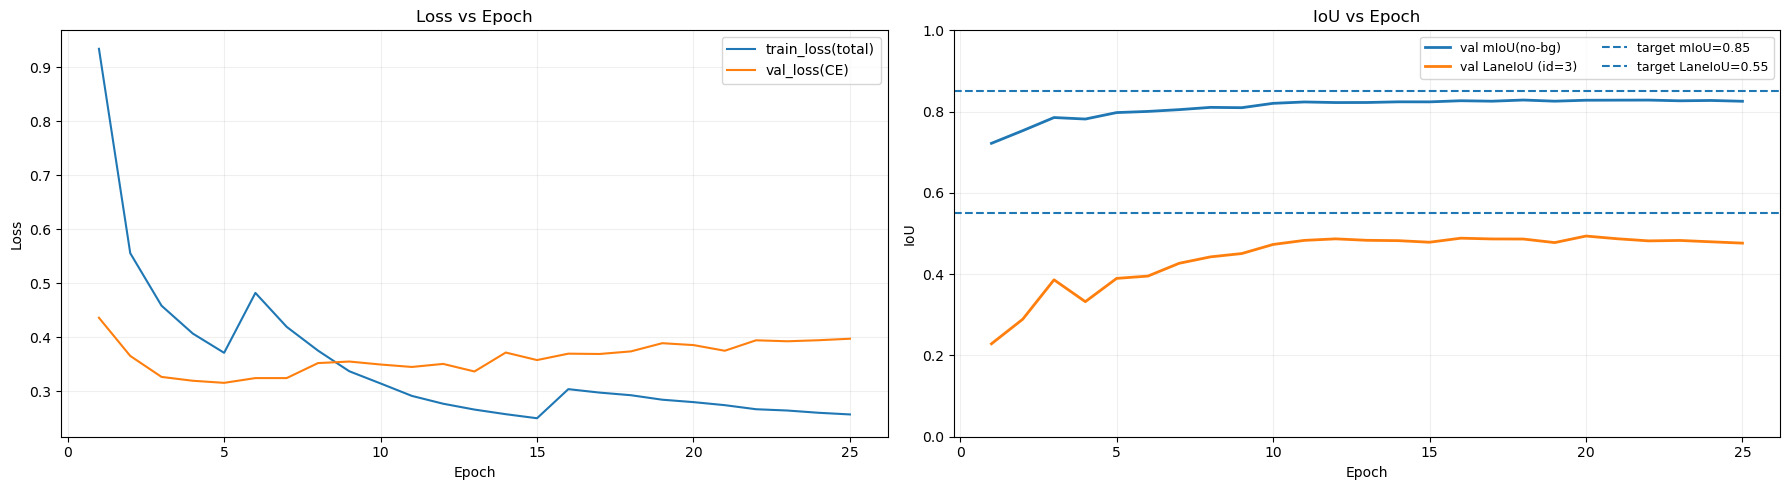

In [13]:
# ============================================================
# ONE CELL (Improved vNext)
# DeepLabV3+ResNet50 + (Lane Dice) + (Lane Emb Reg)
# - LaneDice weight scheduling (low->high) ✅
# - LR slightly down + 1-epoch warmup ✅
# - 기존 출력/가시화/early stopping(score) 유지 ✅
#
# [필수]
# - DEVICE, NUM_CLASSES=7, train_loader, val_loader
# - class_weights(선택), coco(선택), id2train(선택)
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# --------------------
# CONFIG
# --------------------
EPOCHS = 40
PATIENCE = 5

LR = 2e-4                 # ✅ 3e-4 -> 2e-4
WEIGHT_DECAY = 3e-4
LABEL_SMOOTH = 0.0

BEST_PATH = "best_deeplabv3_r50_laneemb_laneDice_vnext.pt"

IGNORE_BG = True
PRINT_BG_IOU = False

TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55
LANE_TRAIN_ID = 3

# ---- Lane Emb (약하게 유지) ----
EMB_DIM = 4
LAMBDA_EMB = 0.02
EMB_MARGIN = 1.0
EMB_MIN_PIXELS = 30

# ---- Lane Dice (스케줄링) ----
# 초반(안정) 낮게 → 후반(차선 강화) 높게
LANE_DICE_W1, LANE_DICE_W2, LANE_DICE_W3 = 0.20, 0.40, 0.60
LANE_DICE_EP1, LANE_DICE_EP2 = 5, 15    # 1~5 / 6~15 / 16~EPOCHS

# (선택) backbone warmup freeze (원하면 1~2)
FREEZE_BACKBONE_WARMUP_EPOCHS = 0

device = torch.device(DEVICE)

# --------------------
# CLASS NAME MAP
# --------------------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i+1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# --------------------
# MODEL
# --------------------
class DeepLabV3_WithLaneEmbedding(nn.Module):
    def __init__(self, num_classes: int, emb_dim: int = 4, backbone_pretrained=True, dropout_p=0.1):
        super().__init__()
        self.base = deeplabv3_resnet50(
            weights=None,
            weights_backbone="DEFAULT" if backbone_pretrained else None
        )
        cls_children = list(self.base.classifier.children())
        self.feat_extractor = nn.Sequential(*cls_children[:-1])  # -> (B,256,h,w)

        last = cls_children[-1]
        in_ch = getattr(last, "in_channels", 256)
        self.seg_head = nn.Conv2d(in_ch, num_classes, kernel_size=1)
        self.base.classifier = nn.Sequential(*cls_children[:-1], self.seg_head)

        self.embed_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_p),
            nn.Conv2d(256, emb_dim, 1),
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        feats = self.base.backbone(x)
        x_out = feats["out"]
        feat256 = self.feat_extractor(x_out)
        seg = self.seg_head(feat256)
        emb = self.embed_head(feat256)
        seg = F.interpolate(seg, size=input_shape, mode="bilinear", align_corners=False)
        emb = F.interpolate(emb, size=input_shape, mode="bilinear", align_corners=False)
        return {"seg": seg, "emb": emb}

model = DeepLabV3_WithLaneEmbedding(NUM_CLASSES, emb_dim=EMB_DIM).to(device)

# --------------------
# LOSSES
# --------------------
use_class_weight = True
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
ce_criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

def dice_loss_binary_from_logits(logits, target01, eps=1e-6):
    # logits: (B,H,W), target01: (B,H,W) {0,1}
    prob = torch.sigmoid(logits)
    prob = prob.contiguous().view(prob.size(0), -1)
    tgt  = target01.contiguous().view(target01.size(0), -1).float()
    inter = (prob * tgt).sum(dim=1)
    denom = prob.sum(dim=1) + tgt.sum(dim=1)
    dice = (2 * inter + eps) / (denom + eps)
    return (1 - dice).mean()

def lane_dice_loss(seg_logits, y, lane_id):
    # seg_logits: (B,C,H,W) → lane logit만 뽑아 binary dice
    lane_logit = seg_logits[:, lane_id, :, :]         # (B,H,W)
    lane_tgt = (y == lane_id).float()                 # (B,H,W)
    return dice_loss_binary_from_logits(lane_logit, lane_tgt)

def lane_embedding_loss_simple(emb, y, lane_id: int, margin: float = 1.0, min_pixels: int = 30):
    B, D, H, W = emb.shape
    emb_hw = emb.permute(0, 2, 3, 1).contiguous().view(B, H * W, D)
    y_hw = y.view(B, H * W)
    total = emb.new_tensor(0.0)
    cnt = 0
    for b in range(B):
        lane_mask = (y_hw[b] == lane_id)
        non_mask = ~lane_mask
        if lane_mask.sum() < min_pixels or non_mask.sum() < min_pixels:
            continue
        lane_emb = emb_hw[b][lane_mask]
        non_emb = emb_hw[b][non_mask]
        lane_mean = lane_emb.mean(dim=0, keepdim=True)
        non_mean = non_emb.mean(dim=0, keepdim=True)
        pull = F.mse_loss(lane_emb, lane_mean.expand_as(lane_emb))
        dist = torch.norm(lane_mean - non_mean, p=2)
        push = F.relu(margin - dist)
        total = total + (pull + 0.1 * push)
        cnt += 1
    return total / cnt if cnt > 0 else emb.new_tensor(0.0)

def lane_dice_weight(epoch):
    if epoch <= LANE_DICE_EP1:
        return LANE_DICE_W1
    elif epoch <= LANE_DICE_EP2:
        return LANE_DICE_W2
    else:
        return LANE_DICE_W3

def total_loss_fn(out, y, epoch):
    seg = out["seg"]
    emb = out["emb"]
    loss_ce = ce_criterion(seg, y)
    w_dice = lane_dice_weight(epoch)
    loss_dice = lane_dice_loss(seg, y, LANE_TRAIN_ID)
    loss_emb = lane_embedding_loss_simple(emb, y, LANE_TRAIN_ID, margin=EMB_MARGIN, min_pixels=EMB_MIN_PIXELS)
    loss_total = loss_ce + w_dice * loss_dice + LAMBDA_EMB * loss_emb
    return loss_total, loss_ce.detach(), loss_dice.detach(), loss_emb.detach(), float(w_dice)

# --------------------
# OPT / SCHED (1-epoch warmup + cosine)
# --------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def lr_warmup_cosine(epoch, base_lr, warmup_epochs, total_epochs):
    if epoch <= warmup_epochs:
        return base_lr * (epoch / max(1, warmup_epochs))
    # cosine for remaining
    t = (epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
    return base_lr * 0.5 * (1 + np.cos(np.pi * t))

def set_backbone_trainable(model, trainable: bool):
    for p in model.base.backbone.parameters():
        p.requires_grad = trainable

# --------------------
# METRICS (same)
# --------------------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount((num_classes * target[k] + pred[k]).to(torch.int64),
                          minlength=num_classes**2).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        seg_logits = model(x)["seg"]
        loss = ce_criterion(seg_logits, y)  # val은 CE 기준(일관성)
        total_loss += float(loss.item()); n += 1
        pred = seg_logits.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)
    hist = hist.float()
    diag = torch.diag(hist)
    denom = (hist.sum(1) + hist.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()
    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    return total_loss / max(n, 1), miou, iou

def train_one_epoch(model, loader, epoch):
    model.train()
    tot = tot_ce = tot_dice = tot_emb = 0.0
    n = 0
    for x, y in tqdm(loader, desc="train", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)
        loss, lce, ldice, lemb, w_dice = total_loss_fn(out, y, epoch)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        tot += float(loss.item())
        tot_ce += float(lce.item())
        tot_dice += float(ldice.item())
        tot_emb += float(lemb.item())
        n += 1
    return tot/max(n,1), tot_ce/max(n,1), tot_dice/max(n,1), tot_emb/max(n,1), w_dice

# --------------------
# HISTORY
# --------------------
history = dict(epoch=[], train_loss=[], train_ce=[], train_dice=[], train_emb=[],
               val_loss=[], val_miou=[], val_iou_per_class=[], lane_dice_w=[])

# --------------------
# TRAIN LOOP (score: mIoU + alpha*LaneIoU)
# --------------------
best_score = -1e9
best_epoch = 0
pat = 0

ALPHA_LANE = 0.5  # score = mIoU + ALPHA_LANE*LaneIoU (Lane 중심으로 더 끌기)

print(f"DEVICE={DEVICE} | NUM_CLASSES={NUM_CLASSES} | LR={LR} | WD={WEIGHT_DECAY}")
print(f"LaneDice schedule: {LANE_DICE_W1}->{LANE_DICE_W2}->{LANE_DICE_W3} @ ep {LANE_DICE_EP1}/{LANE_DICE_EP2}")
print(f"Score = mIoU + {ALPHA_LANE}*LaneIoU | Lane id={LANE_TRAIN_ID}")
print(f"Save best to: {BEST_PATH}\n")

for epoch in range(1, EPOCHS + 1):
    # backbone warmup freeze
    if FREEZE_BACKBONE_WARMUP_EPOCHS > 0:
        set_backbone_trainable(model, trainable=(epoch > FREEZE_BACKBONE_WARMUP_EPOCHS))

    # warmup+cosine lr
    cur_lr = lr_warmup_cosine(epoch, LR, warmup_epochs=1, total_epochs=EPOCHS)
    for pg in optimizer.param_groups:
        pg["lr"] = cur_lr

    tr, tr_ce, tr_dice, tr_emb, w_dice = train_one_epoch(model, train_loader, epoch)
    va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)

    lane_iou = float(va_iou_pc[LANE_TRAIN_ID])
    score = va_miou + ALPHA_LANE * lane_iou

    history["epoch"].append(epoch)
    history["train_loss"].append(tr)
    history["train_ce"].append(tr_ce)
    history["train_dice"].append(tr_dice)
    history["train_emb"].append(tr_emb)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["val_iou_per_class"].append(va_iou_pc)
    history["lane_dice_w"].append(w_dice)

    tag = "no-bg" if IGNORE_BG else "with-bg"
    print(f"[{epoch:02d}] lr={cur_lr:.2e} | w_dice={w_dice:.2f} | score={score:.4f} | "
          f"train={tr:.4f} (ce={tr_ce:.4f}, dice={tr_dice:.4f}, emb={tr_emb:.4f}) | "
          f"val_loss={va_loss:.4f} | val_mIoU({tag})={va_miou:.4f} | laneIoU={lane_iou:.4f}")

    start_cid = 0 if PRINT_BG_IOU else 1
    for cid in range(start_cid, NUM_CLASSES):
        name = train2name.get(cid, str(cid))
        v = va_iou_pc[cid]
        txt = "nan" if np.isnan(v) else f"{v:.4f}"
        print(f"  IoU[{cid}] {name}: {txt}")

    improved = score > best_score + 1e-7
    if improved:
        best_score = score
        best_epoch = epoch
        pat = 0
        save_dict = {"model": model.state_dict(), "num_classes": NUM_CLASSES, "emb_dim": EMB_DIM}
        if "id2train" in globals():
            save_dict["id2train"] = id2train
        torch.save(save_dict, BEST_PATH)
        print(f"  ✅ improved! best_score={best_score:.4f} (mIoU={va_miou:.4f}) @ epoch {best_epoch} | patience {pat}/{PATIENCE} | saved\n")
    else:
        pat += 1
        remain = PATIENCE - pat
        print(f"  ❌ no improve | best_score={best_score:.4f} @ epoch {best_epoch} | patience {pat}/{PATIENCE} (remain {max(remain,0)})\n")
        if pat >= PATIENCE:
            print("Early stopping triggered.")
            break

print(f"Best epoch={best_epoch} | best_score={best_score:.6f}")

# --------------------
# LOAD BEST + FINAL VAL REPORT
# --------------------
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou_best = float(va_iou_pc[LANE_TRAIN_ID])
score_best = va_miou + ALPHA_LANE * lane_iou_best

print("\n[Best Model @ VAL]")
print(f"val_loss={va_loss:.4f} | val_mIoU(no-bg)={va_miou:.4f} | laneIoU={lane_iou_best:.4f} | score={score_best:.4f}")
for cid in range(1, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = va_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# --------------------
# VISUALIZATION: SIDE-BY-SIDE (Loss / IoU)
# --------------------
epochs = np.array(history["epoch"])
train_loss = np.array(history["train_loss"])
val_loss_arr = np.array(history["val_loss"])
val_miou_hist = np.array(history["val_miou"])
val_iou_stack = np.stack(history["val_iou_per_class"], axis=0)
lane_iou_hist = val_iou_stack[:, LANE_TRAIN_ID]

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

axes[0].plot(epochs, train_loss, label="train_loss(total)")
axes[0].plot(epochs, val_loss_arr, label="val_loss(CE)")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Epoch")
axes[0].grid(True, alpha=0.2)
axes[0].legend()

axes[1].plot(epochs, val_miou_hist, linewidth=2, label="val mIoU(no-bg)")
axes[1].plot(epochs, lane_iou_hist, linewidth=2, label=f"val LaneIoU (id={LANE_TRAIN_ID})")
axes[1].axhline(TARGET_MIOU, linestyle="--", linewidth=1.5, label=f"target mIoU={TARGET_MIOU}")
axes[1].axhline(TARGET_LANE_IOU, linestyle="--", linewidth=1.5, label=f"target LaneIoU={TARGET_LANE_IOU}")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("IoU")
axes[1].set_title("IoU vs Epoch")
axes[1].set_ylim(0.0, 1.0)
axes[1].grid(True, alpha=0.2)
axes[1].legend(ncol=2, fontsize=9)

plt.tight_layout()
plt.show()

test:   0%|          | 0/5 [00:00<?, ?it/s]

[TEST] loss=0.4881 | mIoU(no-bg)=0.8019 | laneIoU(train_id=3)=0.4825
Targets: mIoU>=0.85, LaneIoU>=0.55
  IoU[1] Undrivable: 0.9387
  IoU[2] Road: 0.8520
  IoU[3] Lane Mark: 0.4825
  IoU[4] Moveable: 0.6568
  IoU[5] My bike: 0.9459
  IoU[6] Rider: 0.9356


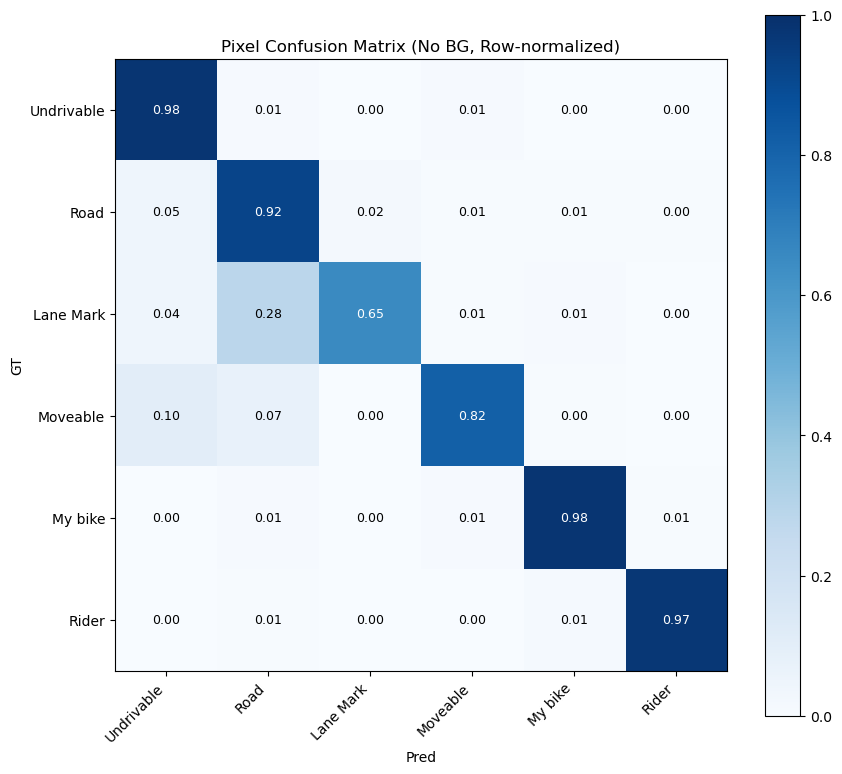

In [14]:
# ============================================================
# DeepLabV3+ResNet50 + Lane Embedding Head (Aux) + LaneDice 학습모델 평가
# - loads BEST_PATH
# - computes: test_loss(CE), test_mIoU(no-bg), laneIoU, per-class IoU
# - confusion matrix: no-bg(6x6), row-normalized + class names
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# ---------- config ----------
BEST_PATH = "best_deeplabv3_r50_laneemb_laneDice_vnext.pt"
#BEST_PATH = "best_deeplabv3_r50_lane_vnext2.pt"  # ✅ 학습 때 저장한 best로 바꾸세요

IGNORE_BG = True
PRINT_BG_IOU = False

LANE_TRAIN_ID = 3
TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55

LABEL_SMOOTH = 0.0
use_class_weight = True

device = torch.device(DEVICE)

# ---------- class name map (train_id -> name) ----------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i + 1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# ---------- model: DeepLabV3 + Lane Embedding ----------
class DeepLabV3_WithLaneEmbedding(nn.Module):
    """
    out["seg"]: (B, num_classes, H, W)
    out["emb"]: (B, emb_dim, H, W)  # 테스트에서는 emb는 사용 안 해도 됨
    """
    def __init__(self, num_classes: int, emb_dim: int = 4, backbone_pretrained=True, dropout_p=0.1):
        super().__init__()
        self.base = deeplabv3_resnet50(
            weights=None,
            weights_backbone="DEFAULT" if backbone_pretrained else None
        )

        cls_children = list(self.base.classifier.children())
        self.feat_extractor = nn.Sequential(*cls_children[:-1])  # -> (B,256,h,w)

        last = cls_children[-1]
        in_ch = getattr(last, "in_channels", 256)
        self.seg_head = nn.Conv2d(in_ch, num_classes, kernel_size=1)
        self.base.classifier = nn.Sequential(*cls_children[:-1], self.seg_head)

        self.embed_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_p),
            nn.Conv2d(256, emb_dim, 1),
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        feats = self.base.backbone(x)
        x_out = feats["out"]
        feat256 = self.feat_extractor(x_out)
        seg = self.seg_head(feat256)
        emb = self.embed_head(feat256)

        seg = F.interpolate(seg, size=input_shape, mode="bilinear", align_corners=False)
        emb = F.interpolate(emb, size=input_shape, mode="bilinear", align_corners=False)
        return {"seg": seg, "emb": emb}

# ---------- loss (for reporting) ----------
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

# ---------- load best ----------
ckpt = torch.load(BEST_PATH, map_location=device)

# emb_dim 추론(ckpt에 없으면 기본 4로)
EMB_DIM = int(ckpt.get("emb_dim", 4)) if isinstance(ckpt, dict) else 4

model = DeepLabV3_WithLaneEmbedding(
    num_classes=NUM_CLASSES,
    emb_dim=EMB_DIM,
    backbone_pretrained=True,
    dropout_p=0.1
).to(device)

# 저장 포맷 방어: {"model": state_dict} or state_dict 직접 저장
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state, strict=True)
model.eval()

# ---------- metrics ----------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount(
        (num_classes * target[k] + pred[k]).to(torch.int64),
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate_test(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0

    for x, y in tqdm(loader, desc="test", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)["seg"]  # ✅ 새 모델은 "seg"
        loss = criterion(out, y)
        total_loss += float(loss.item())
        n += 1

        pred = out.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)

    hist_f = hist.float()
    diag = torch.diag(hist_f)
    denom = (hist_f.sum(1) + hist_f.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()

    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    avg_loss = total_loss / max(n, 1)

    return avg_loss, miou, iou, hist.cpu().numpy()

# ---------- run test ----------
test_loss, test_miou, test_iou_pc, test_hist = evaluate_test(model, test_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou = float(test_iou_pc[LANE_TRAIN_ID])

tag = "no-bg" if IGNORE_BG else "with-bg"
print(f"[TEST] loss={test_loss:.4f} | mIoU({tag})={test_miou:.4f} | laneIoU(train_id={LANE_TRAIN_ID})={lane_iou:.4f}")
print(f"Targets: mIoU>={TARGET_MIOU}, LaneIoU>={TARGET_LANE_IOU}")

start_cid = 0 if PRINT_BG_IOU else 1
for cid in range(start_cid, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = test_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# ============================================================
# Confusion Matrix (No BG: (NUM_CLASSES-1)x(NUM_CLASSES-1))
# Row-normalized (GT 기준) + 클래스 이름 + 숫자 표시
# ============================================================

cm_no_bg = test_hist[1:, 1:].astype(np.float32)

row_sum = cm_no_bg.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_no_bg, row_sum, where=row_sum != 0)

class_names = [train2name.get(i, str(i)) for i in range(1, NUM_CLASSES)]

plt.figure(figsize=(9, 8))
plt.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)

plt.title("Pixel Confusion Matrix (No BG, Row-normalized)")
plt.xlabel("Pred")
plt.ylabel("GT")

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(
            j, i, f"{cm_norm[i, j]:.2f}",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > 0.5 else "black",
            fontsize=9
        )

plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

plt.colorbar()
plt.tight_layout()
plt.show()


DEVICE=cuda | NUM_CLASSES=7 | LR=0.0002 | WD=0.0003
LaneDice linear ramp: 0.2->0.55 over 20 ep
LaneFocal: lambda=0.08, alpha=0.75, gamma=2.0
Score = mIoU + 0.8*LaneIoU | Lane id=3
Save best to: best_deeplabv3_r50_lane_vnext2.pt



train:   0%|          | 0/40 [00:00<?, ?it/s]

[01] lr=2.00e-04 | w_dice=0.218 | score=0.9310 | train=0.9779 (ce=0.7645, dice=0.9620, focal=0.0426, emb=0.0356) | val_loss=0.4435 | val_mIoU(no-bg)=0.7225 | laneIoU=0.2606
  IoU[1] Undrivable: 0.9132
  IoU[2] Road: 0.7518
  IoU[3] Lane Mark: 0.2606
  IoU[4] Moveable: 0.6876
  IoU[5] My bike: 0.8830
  IoU[6] Rider: 0.8390
  ✅ improved! best_score=0.9310 (mIoU=0.7225) @ epoch 1 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[02] lr=2.00e-04 | w_dice=0.235 | score=1.0247 | train=0.5923 (ce=0.3701, dice=0.9362, focal=0.0271, emb=0.0038) | val_loss=0.3504 | val_mIoU(no-bg)=0.7636 | laneIoU=0.3264
  IoU[1] Undrivable: 0.9280
  IoU[2] Road: 0.8060
  IoU[3] Lane Mark: 0.3264
  IoU[4] Moveable: 0.7194
  IoU[5] My bike: 0.9201
  IoU[6] Rider: 0.8818
  ✅ improved! best_score=1.0247 (mIoU=0.7636) @ epoch 2 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[03] lr=1.99e-04 | w_dice=0.253 | score=1.0756 | train=0.5020 (ce=0.2737, dice=0.8984, focal=0.0180, emb=0.0020) | val_loss=0.3246 | val_mIoU(no-bg)=0.7824 | laneIoU=0.3665
  IoU[1] Undrivable: 0.9313
  IoU[2] Road: 0.8257
  IoU[3] Lane Mark: 0.3665
  IoU[4] Moveable: 0.7479
  IoU[5] My bike: 0.9264
  IoU[6] Rider: 0.8967
  ✅ improved! best_score=1.0756 (mIoU=0.7824) @ epoch 3 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[04] lr=1.98e-04 | w_dice=0.270 | score=1.0761 | train=0.4530 (ce=0.2274, dice=0.8318, focal=0.0119, emb=0.0015) | val_loss=0.3224 | val_mIoU(no-bg)=0.7887 | laneIoU=0.3592
  IoU[1] Undrivable: 0.9414
  IoU[2] Road: 0.8337
  IoU[3] Lane Mark: 0.3592
  IoU[4] Moveable: 0.7540
  IoU[5] My bike: 0.9278
  IoU[6] Rider: 0.9160
  ✅ improved! best_score=1.0761 (mIoU=0.7887) @ epoch 4 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[05] lr=1.96e-04 | w_dice=0.288 | score=1.1111 | train=0.4180 (ce=0.2058, dice=0.7358, focal=0.0086, emb=0.0012) | val_loss=0.3349 | val_mIoU(no-bg)=0.7989 | laneIoU=0.3902
  IoU[1] Undrivable: 0.9407
  IoU[2] Road: 0.8417
  IoU[3] Lane Mark: 0.3902
  IoU[4] Moveable: 0.7753
  IoU[5] My bike: 0.9309
  IoU[6] Rider: 0.9144
  ✅ improved! best_score=1.1111 (mIoU=0.7989) @ epoch 5 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[06] lr=1.94e-04 | w_dice=0.305 | score=1.1322 | train=0.3834 (ce=0.1916, dice=0.6272, focal=0.0053, emb=0.0009) | val_loss=0.3294 | val_mIoU(no-bg)=0.8037 | laneIoU=0.4107
  IoU[1] Undrivable: 0.9381
  IoU[2] Road: 0.8435
  IoU[3] Lane Mark: 0.4107
  IoU[4] Moveable: 0.7850
  IoU[5] My bike: 0.9357
  IoU[6] Rider: 0.9090
  ✅ improved! best_score=1.1322 (mIoU=0.8037) @ epoch 6 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[07] lr=1.91e-04 | w_dice=0.323 | score=1.1653 | train=0.3514 (ce=0.1820, dice=0.5240, focal=0.0042, emb=0.0008) | val_loss=0.3404 | val_mIoU(no-bg)=0.8131 | laneIoU=0.4403
  IoU[1] Undrivable: 0.9406
  IoU[2] Road: 0.8489
  IoU[3] Lane Mark: 0.4403
  IoU[4] Moveable: 0.7892
  IoU[5] My bike: 0.9392
  IoU[6] Rider: 0.9205
  ✅ improved! best_score=1.1653 (mIoU=0.8131) @ epoch 7 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[08] lr=1.88e-04 | w_dice=0.340 | score=1.1932 | train=0.3272 (ce=0.1708, dice=0.4590, focal=0.0040, emb=0.0006) | val_loss=0.3257 | val_mIoU(no-bg)=0.8228 | laneIoU=0.4631
  IoU[1] Undrivable: 0.9415
  IoU[2] Road: 0.8591
  IoU[3] Lane Mark: 0.4631
  IoU[4] Moveable: 0.7977
  IoU[5] My bike: 0.9451
  IoU[6] Rider: 0.9301
  ✅ improved! best_score=1.1932 (mIoU=0.8228) @ epoch 8 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[09] lr=1.84e-04 | w_dice=0.358 | score=1.1842 | train=0.3115 (ce=0.1630, dice=0.4145, focal=0.0039, emb=0.0006) | val_loss=0.3402 | val_mIoU(no-bg)=0.8206 | laneIoU=0.4546
  IoU[1] Undrivable: 0.9400
  IoU[2] Road: 0.8565
  IoU[3] Lane Mark: 0.4546
  IoU[4] Moveable: 0.7956
  IoU[5] My bike: 0.9444
  IoU[6] Rider: 0.9324
  ❌ no improve | best_score=1.1932 @ epoch 8 | patience 1/7 (remain 6)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[10] lr=1.80e-04 | w_dice=0.375 | score=1.2040 | train=0.2978 (ce=0.1545, dice=0.3812, focal=0.0037, emb=0.0004) | val_loss=0.3291 | val_mIoU(no-bg)=0.8232 | laneIoU=0.4760
  IoU[1] Undrivable: 0.9416
  IoU[2] Road: 0.8579
  IoU[3] Lane Mark: 0.4760
  IoU[4] Moveable: 0.7889
  IoU[5] My bike: 0.9468
  IoU[6] Rider: 0.9279
  ✅ improved! best_score=1.2040 (mIoU=0.8232) @ epoch 10 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[11] lr=1.76e-04 | w_dice=0.393 | score=1.2084 | train=0.2852 (ce=0.1460, dice=0.3538, focal=0.0035, emb=0.0004) | val_loss=0.3366 | val_mIoU(no-bg)=0.8255 | laneIoU=0.4786
  IoU[1] Undrivable: 0.9430
  IoU[2] Road: 0.8580
  IoU[3] Lane Mark: 0.4786
  IoU[4] Moveable: 0.8000
  IoU[5] My bike: 0.9458
  IoU[6] Rider: 0.9276
  ✅ improved! best_score=1.2084 (mIoU=0.8255) @ epoch 11 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[12] lr=1.71e-04 | w_dice=0.410 | score=1.2281 | train=0.2766 (ce=0.1398, dice=0.3330, focal=0.0035, emb=0.0003) | val_loss=0.3418 | val_mIoU(no-bg)=0.8315 | laneIoU=0.4958
  IoU[1] Undrivable: 0.9447
  IoU[2] Road: 0.8627
  IoU[3] Lane Mark: 0.4958
  IoU[4] Moveable: 0.8080
  IoU[5] My bike: 0.9500
  IoU[6] Rider: 0.9278
  ✅ improved! best_score=1.2281 (mIoU=0.8315) @ epoch 12 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[13] lr=1.65e-04 | w_dice=0.428 | score=1.2181 | train=0.2730 (ce=0.1355, dice=0.3210, focal=0.0035, emb=0.0003) | val_loss=0.3499 | val_mIoU(no-bg)=0.8302 | laneIoU=0.4849
  IoU[1] Undrivable: 0.9445
  IoU[2] Road: 0.8678
  IoU[3] Lane Mark: 0.4849
  IoU[4] Moveable: 0.7994
  IoU[5] My bike: 0.9494
  IoU[6] Rider: 0.9351
  ❌ no improve | best_score=1.2281 @ epoch 12 | patience 1/7 (remain 6)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[14] lr=1.60e-04 | w_dice=0.445 | score=1.2246 | train=0.2690 (ce=0.1310, dice=0.3094, focal=0.0036, emb=0.0003) | val_loss=0.3515 | val_mIoU(no-bg)=0.8308 | laneIoU=0.4923
  IoU[1] Undrivable: 0.9455
  IoU[2] Road: 0.8614
  IoU[3] Lane Mark: 0.4923
  IoU[4] Moveable: 0.8039
  IoU[5] My bike: 0.9493
  IoU[6] Rider: 0.9324
  ❌ no improve | best_score=1.2281 @ epoch 12 | patience 2/7 (remain 5)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[15] lr=1.54e-04 | w_dice=0.463 | score=1.2105 | train=0.2657 (ce=0.1264, dice=0.3007, focal=0.0036, emb=0.0003) | val_loss=0.3559 | val_mIoU(no-bg)=0.8275 | laneIoU=0.4788
  IoU[1] Undrivable: 0.9446
  IoU[2] Road: 0.8633
  IoU[3] Lane Mark: 0.4788
  IoU[4] Moveable: 0.7960
  IoU[5] My bike: 0.9483
  IoU[6] Rider: 0.9337
  ❌ no improve | best_score=1.2281 @ epoch 12 | patience 3/7 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[16] lr=1.48e-04 | w_dice=0.480 | score=1.2354 | train=0.2643 (ce=0.1232, dice=0.2933, focal=0.0037, emb=0.0002) | val_loss=0.3490 | val_mIoU(no-bg)=0.8338 | laneIoU=0.5020
  IoU[1] Undrivable: 0.9450
  IoU[2] Road: 0.8683
  IoU[3] Lane Mark: 0.5020
  IoU[4] Moveable: 0.8010
  IoU[5] My bike: 0.9499
  IoU[6] Rider: 0.9367
  ✅ improved! best_score=1.2354 (mIoU=0.8338) @ epoch 16 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[17] lr=1.42e-04 | w_dice=0.498 | score=1.2097 | train=0.2635 (ce=0.1205, dice=0.2867, focal=0.0037, emb=0.0002) | val_loss=0.3623 | val_mIoU(no-bg)=0.8271 | laneIoU=0.4783
  IoU[1] Undrivable: 0.9442
  IoU[2] Road: 0.8617
  IoU[3] Lane Mark: 0.4783
  IoU[4] Moveable: 0.7927
  IoU[5] My bike: 0.9490
  IoU[6] Rider: 0.9364
  ❌ no improve | best_score=1.2354 @ epoch 16 | patience 1/7 (remain 6)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[18] lr=1.35e-04 | w_dice=0.515 | score=1.2248 | train=0.2643 (ce=0.1192, dice=0.2810, focal=0.0038, emb=0.0002) | val_loss=0.3610 | val_mIoU(no-bg)=0.8313 | laneIoU=0.4919
  IoU[1] Undrivable: 0.9449
  IoU[2] Road: 0.8634
  IoU[3] Lane Mark: 0.4919
  IoU[4] Moveable: 0.8028
  IoU[5] My bike: 0.9489
  IoU[6] Rider: 0.9360
  ❌ no improve | best_score=1.2354 @ epoch 16 | patience 2/7 (remain 5)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[19] lr=1.28e-04 | w_dice=0.532 | score=1.2327 | train=0.2619 (ce=0.1153, dice=0.2746, focal=0.0038, emb=0.0002) | val_loss=0.3667 | val_mIoU(no-bg)=0.8333 | laneIoU=0.4992
  IoU[1] Undrivable: 0.9448
  IoU[2] Road: 0.8679
  IoU[3] Lane Mark: 0.4992
  IoU[4] Moveable: 0.8023
  IoU[5] My bike: 0.9491
  IoU[6] Rider: 0.9364
  ❌ no improve | best_score=1.2354 @ epoch 16 | patience 3/7 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[20] lr=1.21e-04 | w_dice=0.550 | score=1.2223 | train=0.2614 (ce=0.1140, dice=0.2674, focal=0.0038, emb=0.0002) | val_loss=0.3652 | val_mIoU(no-bg)=0.8310 | laneIoU=0.4891
  IoU[1] Undrivable: 0.9459
  IoU[2] Road: 0.8635
  IoU[3] Lane Mark: 0.4891
  IoU[4] Moveable: 0.8019
  IoU[5] My bike: 0.9499
  IoU[6] Rider: 0.9359
  ❌ no improve | best_score=1.2354 @ epoch 16 | patience 4/7 (remain 3)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[21] lr=1.14e-04 | w_dice=0.550 | score=1.2332 | train=0.2568 (ce=0.1114, dice=0.2639, focal=0.0038, emb=0.0002) | val_loss=0.3709 | val_mIoU(no-bg)=0.8339 | laneIoU=0.4992
  IoU[1] Undrivable: 0.9449
  IoU[2] Road: 0.8657
  IoU[3] Lane Mark: 0.4992
  IoU[4] Moveable: 0.8019
  IoU[5] My bike: 0.9504
  IoU[6] Rider: 0.9411
  ❌ no improve | best_score=1.2354 @ epoch 16 | patience 5/7 (remain 2)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[22] lr=1.07e-04 | w_dice=0.550 | score=1.2326 | train=0.2514 (ce=0.1086, dice=0.2590, focal=0.0038, emb=0.0002) | val_loss=0.3674 | val_mIoU(no-bg)=0.8329 | laneIoU=0.4996
  IoU[1] Undrivable: 0.9432
  IoU[2] Road: 0.8676
  IoU[3] Lane Mark: 0.4996
  IoU[4] Moveable: 0.7951
  IoU[5] My bike: 0.9510
  IoU[6] Rider: 0.9407
  ❌ no improve | best_score=1.2354 @ epoch 16 | patience 6/7 (remain 1)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[23] lr=1.00e-04 | w_dice=0.550 | score=1.2340 | train=0.2472 (ce=0.1068, dice=0.2547, focal=0.0039, emb=0.0002) | val_loss=0.3745 | val_mIoU(no-bg)=0.8334 | laneIoU=0.5007
  IoU[1] Undrivable: 0.9448
  IoU[2] Road: 0.8658
  IoU[3] Lane Mark: 0.5007
  IoU[4] Moveable: 0.7970
  IoU[5] My bike: 0.9506
  IoU[6] Rider: 0.9415
  ❌ no improve | best_score=1.2354 @ epoch 16 | patience 7/7 (remain 0)

Early stopping triggered.
Best epoch=16 | best_score=1.235411

[Best Model @ VAL]
val_loss=0.3490 | val_mIoU(no-bg)=0.8338 | laneIoU=0.5020 | score=1.2354
  IoU[1] Undrivable: 0.9450
  IoU[2] Road: 0.8683
  IoU[3] Lane Mark: 0.5020
  IoU[4] Moveable: 0.8010
  IoU[5] My bike: 0.9499
  IoU[6] Rider: 0.9367


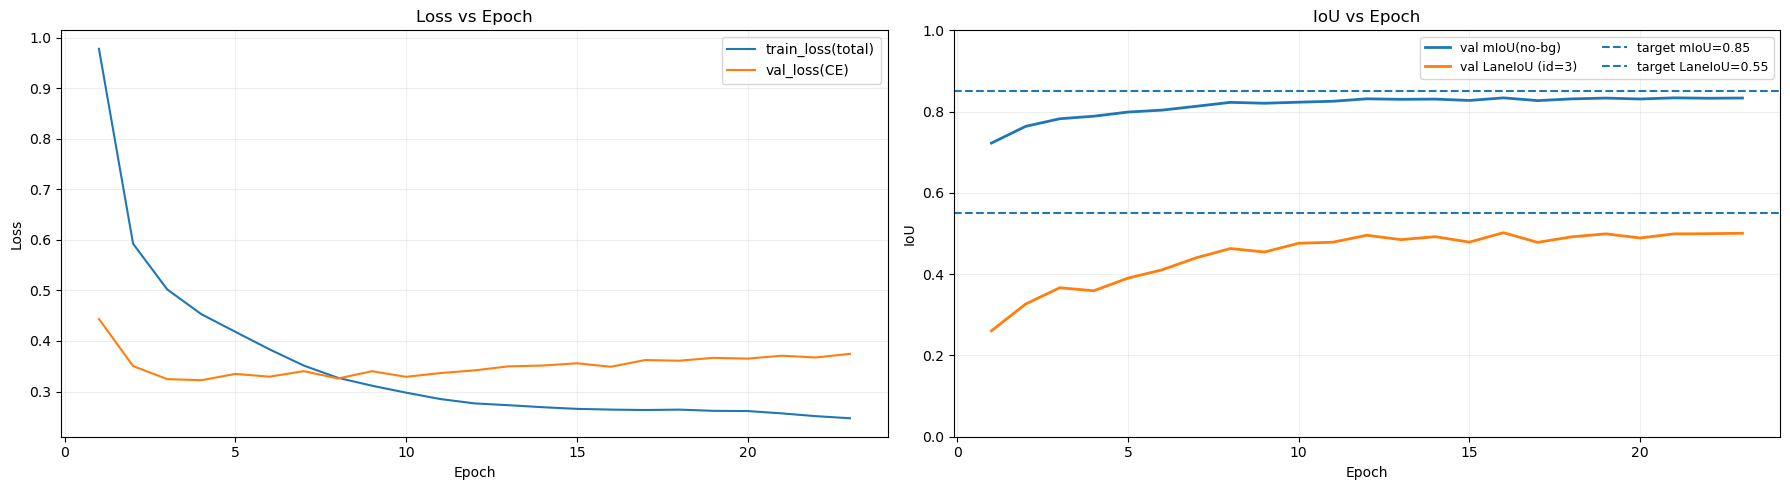

In [16]:
# ============================================================
# ONE CELL (vNext-2)
# DeepLabV3+ResNet50 + LaneDice(Linear Ramp) + LaneFocalBCE(weak) + LaneEmbReg(weak)
#
# 변화점(핵심)
# 1) LaneDice weight: 계단(0.2->0.4->0.6) 제거, 선형 램프 ✅
# 2) Lane Focal BCE를 아주 약하게 추가 ✅
# 3) score = mIoU + 0.8*LaneIoU (Lane 목표 우선) ✅
#
# [필수]
# - DEVICE, NUM_CLASSES=7, train_loader, val_loader
# - class_weights(선택), coco(선택), id2train(선택)
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# --------------------
# CONFIG
# --------------------
EPOCHS = 45
PATIENCE = 7

LR = 2e-4
WEIGHT_DECAY = 3e-4
LABEL_SMOOTH = 0.0

BEST_PATH = "best_deeplabv3_r50_lane_vnext2.pt"

IGNORE_BG = True
PRINT_BG_IOU = False

TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55
LANE_TRAIN_ID = 3

# ---- Lane Emb (약하게 유지) ----
EMB_DIM = 4
LAMBDA_EMB = 0.02
EMB_MARGIN = 1.0
EMB_MIN_PIXELS = 30

# ---- Lane Dice linear ramp ----
LANE_DICE_W_START = 0.20
LANE_DICE_W_END   = 0.55     # ✅ 0.60은 이번 로그에서 흔들림 유발. 0.55로 완만하게
LANE_DICE_RAMP_EPOCHS = 20   # 1~20ep 동안 천천히 증가 후 고정

# ---- Lane Focal BCE (아주 약하게) ----
LAMBDA_LANE_FOCAL = 0.08     # ✅ 작게 시작(0.05~0.12 범위)
FOCAL_ALPHA = 0.75
FOCAL_GAMMA = 2.0

# ---- score (early stopping 기준) ----
ALPHA_LANE = 0.8             # ✅ Lane 목표 우선

# (선택) backbone warmup freeze
FREEZE_BACKBONE_WARMUP_EPOCHS = 0

device = torch.device(DEVICE)

# --------------------
# CLASS NAME MAP
# --------------------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i+1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# --------------------
# MODEL
# --------------------
class DeepLabV3_WithLaneEmbedding(nn.Module):
    def __init__(self, num_classes: int, emb_dim: int = 4, backbone_pretrained=True, dropout_p=0.1):
        super().__init__()
        self.base = deeplabv3_resnet50(
            weights=None,
            weights_backbone="DEFAULT" if backbone_pretrained else None
        )
        cls_children = list(self.base.classifier.children())
        self.feat_extractor = nn.Sequential(*cls_children[:-1])  # -> (B,256,h,w)

        last = cls_children[-1]
        in_ch = getattr(last, "in_channels", 256)
        self.seg_head = nn.Conv2d(in_ch, num_classes, kernel_size=1)
        self.base.classifier = nn.Sequential(*cls_children[:-1], self.seg_head)

        self.embed_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_p),
            nn.Conv2d(256, emb_dim, 1),
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        feats = self.base.backbone(x)
        x_out = feats["out"]
        feat256 = self.feat_extractor(x_out)
        seg = self.seg_head(feat256)
        emb = self.embed_head(feat256)
        seg = F.interpolate(seg, size=input_shape, mode="bilinear", align_corners=False)
        emb = F.interpolate(emb, size=input_shape, mode="bilinear", align_corners=False)
        return {"seg": seg, "emb": emb}

model = DeepLabV3_WithLaneEmbedding(NUM_CLASSES, emb_dim=EMB_DIM).to(device)

# --------------------
# LOSSES
# --------------------
use_class_weight = True
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
ce_criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

def lane_dice_weight(epoch: int):
    # ✅ 선형 램프: 1~LANE_DICE_RAMP_EPOCHS 동안 0.20 -> 0.55로 증가, 이후 고정
    t = min(epoch, LANE_DICE_RAMP_EPOCHS) / max(1, LANE_DICE_RAMP_EPOCHS)
    return LANE_DICE_W_START + t * (LANE_DICE_W_END - LANE_DICE_W_START)

def dice_loss_binary_from_logits(logits, target01, eps=1e-6):
    prob = torch.sigmoid(logits)
    prob = prob.contiguous().view(prob.size(0), -1)
    tgt  = target01.contiguous().view(target01.size(0), -1).float()
    inter = (prob * tgt).sum(dim=1)
    denom = prob.sum(dim=1) + tgt.sum(dim=1)
    dice = (2 * inter + eps) / (denom + eps)
    return (1 - dice).mean()

def lane_dice_loss(seg_logits, y, lane_id):
    lane_logit = seg_logits[:, lane_id, :, :]         # (B,H,W)
    lane_tgt = (y == lane_id).float()                 # (B,H,W)
    return dice_loss_binary_from_logits(lane_logit, lane_tgt)

def focal_bce_with_logits(logits, targets01, alpha=0.75, gamma=2.0, eps=1e-6):
    # logits: (B,H,W), targets01: (B,H,W) float {0,1}
    bce = F.binary_cross_entropy_with_logits(logits, targets01, reduction="none")
    p = torch.sigmoid(logits)
    pt = p * targets01 + (1 - p) * (1 - targets01)
    w = alpha * targets01 + (1 - alpha) * (1 - targets01)
    focal = w * (1 - pt).clamp(min=0.0, max=1.0).pow(gamma) * bce
    return focal.mean()

def lane_focal_loss(seg_logits, y, lane_id):
    lane_logit = seg_logits[:, lane_id, :, :]
    lane_tgt = (y == lane_id).float()
    return focal_bce_with_logits(lane_logit, lane_tgt, alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA)

def lane_embedding_loss_simple(emb, y, lane_id: int, margin: float = 1.0, min_pixels: int = 30):
    B, D, H, W = emb.shape
    emb_hw = emb.permute(0, 2, 3, 1).contiguous().view(B, H * W, D)
    y_hw = y.view(B, H * W)
    total = emb.new_tensor(0.0)
    cnt = 0
    for b in range(B):
        lane_mask = (y_hw[b] == lane_id)
        non_mask = ~lane_mask
        if lane_mask.sum() < min_pixels or non_mask.sum() < min_pixels:
            continue
        lane_emb = emb_hw[b][lane_mask]
        non_emb = emb_hw[b][non_mask]
        lane_mean = lane_emb.mean(dim=0, keepdim=True)
        non_mean = non_emb.mean(dim=0, keepdim=True)
        pull = F.mse_loss(lane_emb, lane_mean.expand_as(lane_emb))
        dist = torch.norm(lane_mean - non_mean, p=2)
        push = F.relu(margin - dist)
        total = total + (pull + 0.1 * push)
        cnt += 1
    return total / cnt if cnt > 0 else emb.new_tensor(0.0)

def total_loss_fn(out, y, epoch):
    seg = out["seg"]
    emb = out["emb"]
    loss_ce = ce_criterion(seg, y)
    w_dice = lane_dice_weight(epoch)
    loss_dice = lane_dice_loss(seg, y, LANE_TRAIN_ID)
    loss_focal = lane_focal_loss(seg, y, LANE_TRAIN_ID)
    loss_emb = lane_embedding_loss_simple(emb, y, LANE_TRAIN_ID, margin=EMB_MARGIN, min_pixels=EMB_MIN_PIXELS)
    loss_total = loss_ce + w_dice * loss_dice + LAMBDA_LANE_FOCAL * loss_focal + LAMBDA_EMB * loss_emb
    return loss_total, loss_ce.detach(), loss_dice.detach(), loss_focal.detach(), loss_emb.detach(), float(w_dice)

# --------------------
# OPT / LR SCHED (warmup 1ep + cosine)
# --------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def lr_warmup_cosine(epoch, base_lr, warmup_epochs, total_epochs):
    if epoch <= warmup_epochs:
        return base_lr * (epoch / max(1, warmup_epochs))
    t = (epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
    return base_lr * 0.5 * (1 + np.cos(np.pi * t))

def set_backbone_trainable(model, trainable: bool):
    for p in model.base.backbone.parameters():
        p.requires_grad = trainable

# --------------------
# METRICS
# --------------------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount((num_classes * target[k] + pred[k]).to(torch.int64),
                          minlength=num_classes**2).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        seg_logits = model(x)["seg"]
        loss = ce_criterion(seg_logits, y)  # val은 CE 기준으로 일관
        total_loss += float(loss.item()); n += 1
        pred = seg_logits.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)
    hist = hist.float()
    diag = torch.diag(hist)
    denom = (hist.sum(1) + hist.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()
    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    return total_loss / max(n, 1), miou, iou

def train_one_epoch(model, loader, epoch):
    model.train()
    tot = tot_ce = tot_dice = tot_focal = tot_emb = 0.0
    n = 0
    for x, y in tqdm(loader, desc="train", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)
        loss, lce, ldice, lfocal, lemb, w_dice = total_loss_fn(out, y, epoch)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        tot += float(loss.item())
        tot_ce += float(lce.item())
        tot_dice += float(ldice.item())
        tot_focal += float(lfocal.item())
        tot_emb += float(lemb.item())
        n += 1
    return tot/max(n,1), tot_ce/max(n,1), tot_dice/max(n,1), tot_focal/max(n,1), tot_emb/max(n,1), w_dice

# --------------------
# HISTORY
# --------------------
history = dict(epoch=[], train_loss=[], train_ce=[], train_dice=[], train_focal=[], train_emb=[],
               val_loss=[], val_miou=[], val_iou_per_class=[], lane_dice_w=[])

# --------------------
# TRAIN LOOP (EarlyStopping: score)
# --------------------
best_score = -1e9
best_epoch = 0
pat = 0

print(f"DEVICE={DEVICE} | NUM_CLASSES={NUM_CLASSES} | LR={LR} | WD={WEIGHT_DECAY}")
print(f"LaneDice linear ramp: {LANE_DICE_W_START}->{LANE_DICE_W_END} over {LANE_DICE_RAMP_EPOCHS} ep")
print(f"LaneFocal: lambda={LAMBDA_LANE_FOCAL}, alpha={FOCAL_ALPHA}, gamma={FOCAL_GAMMA}")
print(f"Score = mIoU + {ALPHA_LANE}*LaneIoU | Lane id={LANE_TRAIN_ID}")
print(f"Save best to: {BEST_PATH}\n")

for epoch in range(1, EPOCHS + 1):
    if FREEZE_BACKBONE_WARMUP_EPOCHS > 0:
        set_backbone_trainable(model, trainable=(epoch > FREEZE_BACKBONE_WARMUP_EPOCHS))

    cur_lr = lr_warmup_cosine(epoch, LR, warmup_epochs=1, total_epochs=EPOCHS)
    for pg in optimizer.param_groups:
        pg["lr"] = cur_lr

    tr, tr_ce, tr_dice, tr_focal, tr_emb, w_dice = train_one_epoch(model, train_loader, epoch)
    va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)

    lane_iou = float(va_iou_pc[LANE_TRAIN_ID])
    score = va_miou + ALPHA_LANE * lane_iou

    history["epoch"].append(epoch)
    history["train_loss"].append(tr)
    history["train_ce"].append(tr_ce)
    history["train_dice"].append(tr_dice)
    history["train_focal"].append(tr_focal)
    history["train_emb"].append(tr_emb)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["val_iou_per_class"].append(va_iou_pc)
    history["lane_dice_w"].append(w_dice)

    tag = "no-bg" if IGNORE_BG else "with-bg"
    print(f"[{epoch:02d}] lr={cur_lr:.2e} | w_dice={w_dice:.3f} | score={score:.4f} | "
          f"train={tr:.4f} (ce={tr_ce:.4f}, dice={tr_dice:.4f}, focal={tr_focal:.4f}, emb={tr_emb:.4f}) | "
          f"val_loss={va_loss:.4f} | val_mIoU({tag})={va_miou:.4f} | laneIoU={lane_iou:.4f}")

    start_cid = 0 if PRINT_BG_IOU else 1
    for cid in range(start_cid, NUM_CLASSES):
        name = train2name.get(cid, str(cid))
        v = va_iou_pc[cid]
        txt = "nan" if np.isnan(v) else f"{v:.4f}"
        print(f"  IoU[{cid}] {name}: {txt}")

    improved = score > best_score + 1e-7
    if improved:
        best_score = score
        best_epoch = epoch
        pat = 0
        save_dict = {"model": model.state_dict(), "num_classes": NUM_CLASSES, "emb_dim": EMB_DIM}
        if "id2train" in globals():
            save_dict["id2train"] = id2train
        torch.save(save_dict, BEST_PATH)
        print(f"  ✅ improved! best_score={best_score:.4f} (mIoU={va_miou:.4f}) @ epoch {best_epoch} | patience {pat}/{PATIENCE} | saved\n")
    else:
        pat += 1
        remain = PATIENCE - pat
        print(f"  ❌ no improve | best_score={best_score:.4f} @ epoch {best_epoch} | patience {pat}/{PATIENCE} (remain {max(remain,0)})\n")
        if pat >= PATIENCE:
            print("Early stopping triggered.")
            break

print(f"Best epoch={best_epoch} | best_score={best_score:.6f}")

# --------------------
# LOAD BEST + FINAL VAL REPORT
# --------------------
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou_best = float(va_iou_pc[LANE_TRAIN_ID])
score_best = va_miou + ALPHA_LANE * lane_iou_best

print("\n[Best Model @ VAL]")
print(f"val_loss={va_loss:.4f} | val_mIoU(no-bg)={va_miou:.4f} | laneIoU={lane_iou_best:.4f} | score={score_best:.4f}")
for cid in range(1, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = va_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# --------------------
# VISUALIZATION
# --------------------
epochs = np.array(history["epoch"])
train_loss = np.array(history["train_loss"])
val_loss_arr = np.array(history["val_loss"])
val_miou_hist = np.array(history["val_miou"])
val_iou_stack = np.stack(history["val_iou_per_class"], axis=0)
lane_iou_hist = val_iou_stack[:, LANE_TRAIN_ID]
w_dice_hist = np.array(history["lane_dice_w"])

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

axes[0].plot(epochs, train_loss, label="train_loss(total)")
axes[0].plot(epochs, val_loss_arr, label="val_loss(CE)")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Epoch")
axes[0].grid(True, alpha=0.2)
axes[0].legend()

axes[1].plot(epochs, val_miou_hist, linewidth=2, label="val mIoU(no-bg)")
axes[1].plot(epochs, lane_iou_hist, linewidth=2, label=f"val LaneIoU (id={LANE_TRAIN_ID})")
axes[1].axhline(TARGET_MIOU, linestyle="--", linewidth=1.5, label=f"target mIoU={TARGET_MIOU}")
axes[1].axhline(TARGET_LANE_IOU, linestyle="--", linewidth=1.5, label=f"target LaneIoU={TARGET_LANE_IOU}")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("IoU")
axes[1].set_title("IoU vs Epoch")
axes[1].set_ylim(0.0, 1.0)
axes[1].grid(True, alpha=0.2)
axes[1].legend(ncol=2, fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# DeepLabV3+ResNet50 + Lane Embedding Head (Aux) + LaneDice 학습모델 평가
# - loads BEST_PATH
# - computes: test_loss(CE), test_mIoU(no-bg), laneIoU, per-class IoU
# - confusion matrix: no-bg(6x6), row-normalized + class names
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# ---------- config ----------
# BEST_PATH = "best_deeplabv3_r50_laneemb_laneDice_vnext.pt"
BEST_PATH = "best_deeplabv3_r50_lane_vnext2.pt"  # ✅ 학습 때 저장한 best로 바꾸세요

IGNORE_BG = True
PRINT_BG_IOU = False

LANE_TRAIN_ID = 3
TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55

LABEL_SMOOTH = 0.0
use_class_weight = True

device = torch.device(DEVICE)

# ---------- class name map (train_id -> name) ----------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i + 1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# ---------- model: DeepLabV3 + Lane Embedding ----------
class DeepLabV3_WithLaneEmbedding(nn.Module):
    """
    out["seg"]: (B, num_classes, H, W)
    out["emb"]: (B, emb_dim, H, W)  # 테스트에서는 emb는 사용 안 해도 됨
    """
    def __init__(self, num_classes: int, emb_dim: int = 4, backbone_pretrained=True, dropout_p=0.1):
        super().__init__()
        self.base = deeplabv3_resnet50(
            weights=None,
            weights_backbone="DEFAULT" if backbone_pretrained else None
        )

        cls_children = list(self.base.classifier.children())
        self.feat_extractor = nn.Sequential(*cls_children[:-1])  # -> (B,256,h,w)

        last = cls_children[-1]
        in_ch = getattr(last, "in_channels", 256)
        self.seg_head = nn.Conv2d(in_ch, num_classes, kernel_size=1)
        self.base.classifier = nn.Sequential(*cls_children[:-1], self.seg_head)

        self.embed_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_p),
            nn.Conv2d(256, emb_dim, 1),
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        feats = self.base.backbone(x)
        x_out = feats["out"]
        feat256 = self.feat_extractor(x_out)
        seg = self.seg_head(feat256)
        emb = self.embed_head(feat256)

        seg = F.interpolate(seg, size=input_shape, mode="bilinear", align_corners=False)
        emb = F.interpolate(emb, size=input_shape, mode="bilinear", align_corners=False)
        return {"seg": seg, "emb": emb}

# ---------- loss (for reporting) ----------
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

# ---------- load best ----------
ckpt = torch.load(BEST_PATH, map_location=device)

# emb_dim 추론(ckpt에 없으면 기본 4로)
EMB_DIM = int(ckpt.get("emb_dim", 4)) if isinstance(ckpt, dict) else 4

model = DeepLabV3_WithLaneEmbedding(
    num_classes=NUM_CLASSES,
    emb_dim=EMB_DIM,
    backbone_pretrained=True,
    dropout_p=0.1
).to(device)

# 저장 포맷 방어: {"model": state_dict} or state_dict 직접 저장
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state, strict=True)
model.eval()

# ---------- metrics ----------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount(
        (num_classes * target[k] + pred[k]).to(torch.int64),
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate_test(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0

    for x, y in tqdm(loader, desc="test", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)["seg"]  # ✅ 새 모델은 "seg"
        loss = criterion(out, y)
        total_loss += float(loss.item())
        n += 1

        pred = out.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)

    hist_f = hist.float()
    diag = torch.diag(hist_f)
    denom = (hist_f.sum(1) + hist_f.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()

    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    avg_loss = total_loss / max(n, 1)

    return avg_loss, miou, iou, hist.cpu().numpy()

# ---------- run test ----------
test_loss, test_miou, test_iou_pc, test_hist = evaluate_test(model, test_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou = float(test_iou_pc[LANE_TRAIN_ID])

tag = "no-bg" if IGNORE_BG else "with-bg"
print(f"[TEST] loss={test_loss:.4f} | mIoU({tag})={test_miou:.4f} | laneIoU(train_id={LANE_TRAIN_ID})={lane_iou:.4f}")
print(f"Targets: mIoU>={TARGET_MIOU}, LaneIoU>={TARGET_LANE_IOU}")

start_cid = 0 if PRINT_BG_IOU else 1
for cid in range(start_cid, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = test_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# ============================================================
# Confusion Matrix (No BG: (NUM_CLASSES-1)x(NUM_CLASSES-1))
# Row-normalized (GT 기준) + 클래스 이름 + 숫자 표시
# ============================================================

cm_no_bg = test_hist[1:, 1:].astype(np.float32)

row_sum = cm_no_bg.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_no_bg, row_sum, where=row_sum != 0)

class_names = [train2name.get(i, str(i)) for i in range(1, NUM_CLASSES)]

plt.figure(figsize=(9, 8))
plt.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)

plt.title("Pixel Confusion Matrix (No BG, Row-normalized)")
plt.xlabel("Pred")
plt.ylabel("GT")

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(
            j, i, f"{cm_norm[i, j]:.2f}",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > 0.5 else "black",
            fontsize=9
        )

plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

plt.colorbar()
plt.tight_layout()
plt.show()


test:   0%|          | 0/5 [00:00<?, ?it/s]